## Predicting Hospital Admission Risk.

This notebook explores a healthcare dataset to predict the likelihood of hospital admission based on patient behavior and claims data.

We will:

Perform data exploration and cleaning
Select and analyze relevant features
Train a baseline Logistic Regression model
Evaluate the model using classification metrics, confusion matrix, ROC curve, and Precision-Recall curve
Train an XGBoost classifier with hyperparameter tuning
Interpret the XGBoost model using SHAP values to understand feature importance and decision logic
Our goal is to build an interpretable and effective model for identifying patients at high risk of hospital admission.

In [2]:
# Libraries for reading the data
import numpy as np
import pandas as pd

# Visualisation libraries

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn learn librarie

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import shap

## Data Exploration

In [4]:
# Loading the dataset into a dataframe previewing the first five rows
df = pd.read_csv('DSY_DSU_LAB_SAMPLE_DATA.csv')
df.head()

MEM_NO  CHRONIC_1  CHRONIC_2  CHRONIC_3  CHRONIC_4  CHRONIC_5  VIT_1  \
0  71310082871          0          0          0          0          0      0   
1   2533699753          0          0          0          0          0      0   
2  36867130860          0          0          0          0          0      0   
3   2409570821          0          0          0          0          0      0   
4   3337711172          0          0          0          0          0      0   

   VIT_2  VIT_3  VIT_4  ...  DRUG_2  DRUG_3  DRUG_4  CONDITION_1  CONDITION_2  \
0      0      0      7  ...     0.0    0.05     0.0          0.0          0.0   
1      0      0      7  ...     0.0    0.00     0.0          0.0          0.0   
2      0      0      7  ...     0.0    0.00     0.0          0.0          0.0   
3      0      0      7  ...     0.0    0.05     0.0          0.0          0.0   
4      0      0      7  ...     0.0    0.00     0.0          0.0          0.0   

   CONDITION_3  CONDITION_4  CONDITION_5  CONDITION_6  LABEL  
0          0.0          0.0          0.0          0.0      0  
1          0.0          0.0          0.0          0.0      0  
2          0.0          0.0          0.0          0.0      0  
3          0.0          0.0          0.0          0.0      0  
4          0.0          0.0          0.0          0.0      0  

[5 rows x 45 columns]

In [5]:
# Check the data structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 45 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   MEM_NO                 1000000 non-null  int64  
 1   CHRONIC_1              1000000 non-null  int64  
 2   CHRONIC_2              1000000 non-null  int64  
 3   CHRONIC_3              1000000 non-null  int64  
 4   CHRONIC_4              1000000 non-null  int64  
 5   CHRONIC_5              1000000 non-null  int64  
 6   VIT_1                  1000000 non-null  int64  
 7   VIT_2                  1000000 non-null  int64  
 8   VIT_3                  1000000 non-null  int64  
 9   VIT_4                  1000000 non-null  int64  
 10  VIT_5                  1000000 non-null  int64  
 11  VIT_6                  1000000 non-null  int64  
 12  VIT_7                  1000000 non-null  int64  
 13  VIT_8                  1000000 non-null  float64
 14  VIT_9              

In [6]:
# Chek for missing values.
df.isnull().sum()

MEM_NO                   0
CHRONIC_1                0
CHRONIC_2                0
CHRONIC_3                0
CHRONIC_4                0
CHRONIC_5                0
VIT_1                    0
VIT_2                    0
VIT_3                    0
VIT_4                    0
VIT_5                    0
VIT_6                    0
VIT_7                    0
VIT_8                    0
VIT_9                    0
VIT_10                   0
CLAIMED_1                0
CLAIMED_2                0
CLAIMED_3                0
CLAIMED_4                0
CLAIMED_5                0
CLAIMED_6_1_MONTH        0
CLAIMED_6_3_MONTHS       0
PRACTICE_TYPE_1          0
PRACTICE_TYPE_2          0
PRACTICE_TYPE_3          0
PRACTICE_TYPE_4          0
PRACTICE_TYPE_5          0
AMOUT_PAID_1             0
AMT_PAID_2               0
AMT_PAID_3_PERCENTAGE    0
VISITS_1                 0
VISITS_2                 0
VISITS_3                 0
DRUG_1                   0
DRUG_2                   0
DRUG_3                   0
DRUG_4                   0
CONDITION_1              0
CONDITION_2              0
CONDITION_3              0
CONDITION_4              0
CONDITION_5              0
CONDITION_6              0
LABEL                    0
dtype: int64

In [7]:
# Checking for descriptive statistic of the numerical features.
df.describe().transpose()

count          mean           std      min  \
MEM_NO                 1000000.0  4.993681e+10  2.888721e+10  32444.0   
CHRONIC_1              1000000.0  2.250000e-02  1.483030e-01      0.0   
CHRONIC_2              1000000.0  4.370800e-02  2.044447e-01      0.0   
CHRONIC_3              1000000.0  3.471200e-02  1.830495e-01      0.0   
CHRONIC_4              1000000.0  7.608000e-03  8.689146e-02      0.0   
CHRONIC_5              1000000.0  2.213000e-03  4.699048e-02      0.0   
VIT_1                  1000000.0  1.989060e+02  1.515460e+03      0.0   
VIT_2                  1000000.0  2.344687e+03  8.758186e+03      0.0   
VIT_3                  1000000.0  3.593635e+02  1.922276e+03      0.0   
VIT_4                  1000000.0  6.618180e+00  1.223353e+00      1.0   
VIT_5                  1000000.0  6.623101e+00  1.280256e+00      2.0   
VIT_6                  1000000.0  6.619150e+00  1.244467e+00      2.0   
VIT_7                  1000000.0  6.648856e+00  1.226964e+00      2.0   
VIT_8                  1000000.0  3.538800e+01  2.157428e+01      0.0   
VIT_9                  1000000.0 -7.362670e-01  7.952563e-01     -1.0   
VIT_10                 1000000.0 -7.889420e-01  6.780553e-01     -1.0   
CLAIMED_1              1000000.0  1.269605e+00  2.065718e+00      0.0   
CLAIMED_2              1000000.0  8.110202e-01  1.944911e+00      0.0   
CLAIMED_3              1000000.0  8.192761e-01  1.136100e+00      0.0   
CLAIMED_4              1000000.0  2.368430e-01  4.711396e+00      0.0   
CLAIMED_5              1000000.0  2.791495e-01  5.109539e+00      0.0   
CLAIMED_6_1_MONTH      1000000.0  3.855000e-03  6.443713e-02      0.0   
CLAIMED_6_3_MONTHS     1000000.0  5.225000e-03  7.416000e-02      0.0   
PRACTICE_TYPE_1        1000000.0  8.363906e-01  1.145487e+00      0.0   
PRACTICE_TYPE_2        1000000.0  2.293328e-01  1.618393e+00      0.0   
PRACTICE_TYPE_3        1000000.0  1.115523e-02  1.658466e-01      0.0   
PRACTICE_TYPE_4        1000000.0  0.000000e+00  0.000000e+00      0.0   
PRACTICE_TYPE_5        1000000.0  9.620042e-01  2.597370e+00      0.0   
AMOUT_PAID_1           1000000.0  9.870419e+03  5.731316e+04      0.0   
AMT_PAID_2             1000000.0  9.878158e+03  5.645551e+04      0.0   
AMT_PAID_3_PERCENTAGE  1000000.0  3.354324e-01  3.872796e-01      0.0   
VISITS_1               1000000.0  1.403951e+01  2.347608e+01      0.0   
VISITS_2               1000000.0  1.170030e+01  1.500853e+01      0.0   
VISITS_3               1000000.0  2.336000e-01  1.156542e+00      0.0   
DRUG_1                 1000000.0  1.406205e-02  8.691265e-02      0.0   
DRUG_2                 1000000.0  2.568300e-02  9.853724e-02      0.0   
DRUG_3                 1000000.0  1.740440e-02  5.898716e-02      0.0   
DRUG_4                 1000000.0  4.101200e-03  3.440205e-02      0.0   
CONDITION_1            1000000.0  1.993364e-01  7.418026e+00      0.0   
CONDITION_2            1000000.0  1.714572e-01  4.116014e+00      0.0   
CONDITION_3            1000000.0  1.366560e-01  1.590798e+00      0.0   
CONDITION_4            1000000.0  9.754008e-02  6.602729e-01      0.0   
CONDITION_5            1000000.0  2.096078e-02  4.452494e-01      0.0   
CONDITION_6            1000000.0  1.695000e-02  7.420446e-01      0.0   
LABEL                  1000000.0  2.385500e-02  1.525974e-01      0.0   

                                25%           50%           75%           max  
MEM_NO                 2.494060e+10  4.990147e+10  7.496640e+10  9.999992e+10  
CHRONIC_1              0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
CHRONIC_2              0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
CHRONIC_3              0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
CHRONIC_4              0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
CHRONIC_5              0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
VIT_1                  0.000000e+00  0.000000e+00  0.000000e+00  3.372200e+05  
VIT_2                  0.000

From the .describe() output, several important patterns emerge:

Chronic Illness Indicators (e.g., CHRONIC_1 to CHRONIC_5)
These features have very low mean values, indicating that only a small proportion of members are diagnosed with these chronic conditions. This aligns with the rarity of some diseases in the general population.

Claims and Payments (e.g., CLAIMED_*, AMOUNT_PAID_*)

There is a large disparity between the mean and maximum values, suggesting the presence of high-cost outliers. While most members submit small to moderate claims, a few incur very large healthcare expenses, a common phenomenon in healthcare datasets (e.g., due to hospitalizations or specialist treatments).

Visits and Medication Usage

The number of healthcare visits and medication items used varies widely across the population. This variability reflects differing healthcare needs, from preventive care to chronic disease management.
Low-Variance Features (e.g., VIT_4 to VIT_7)

Some features show very little variation, suggesting they may be uninformative or redundant. These variables should be considered for removal or transformation during preprocessing.
Target Variable: LABEL

The target is highly imbalanced, with only about 2.4% of members labeled as positive. This confirms that we are working with a rare-event classification problem, which will require specific strategies such as resampling, adjusted evaluation metrics, or specialised models to address the imbalance.

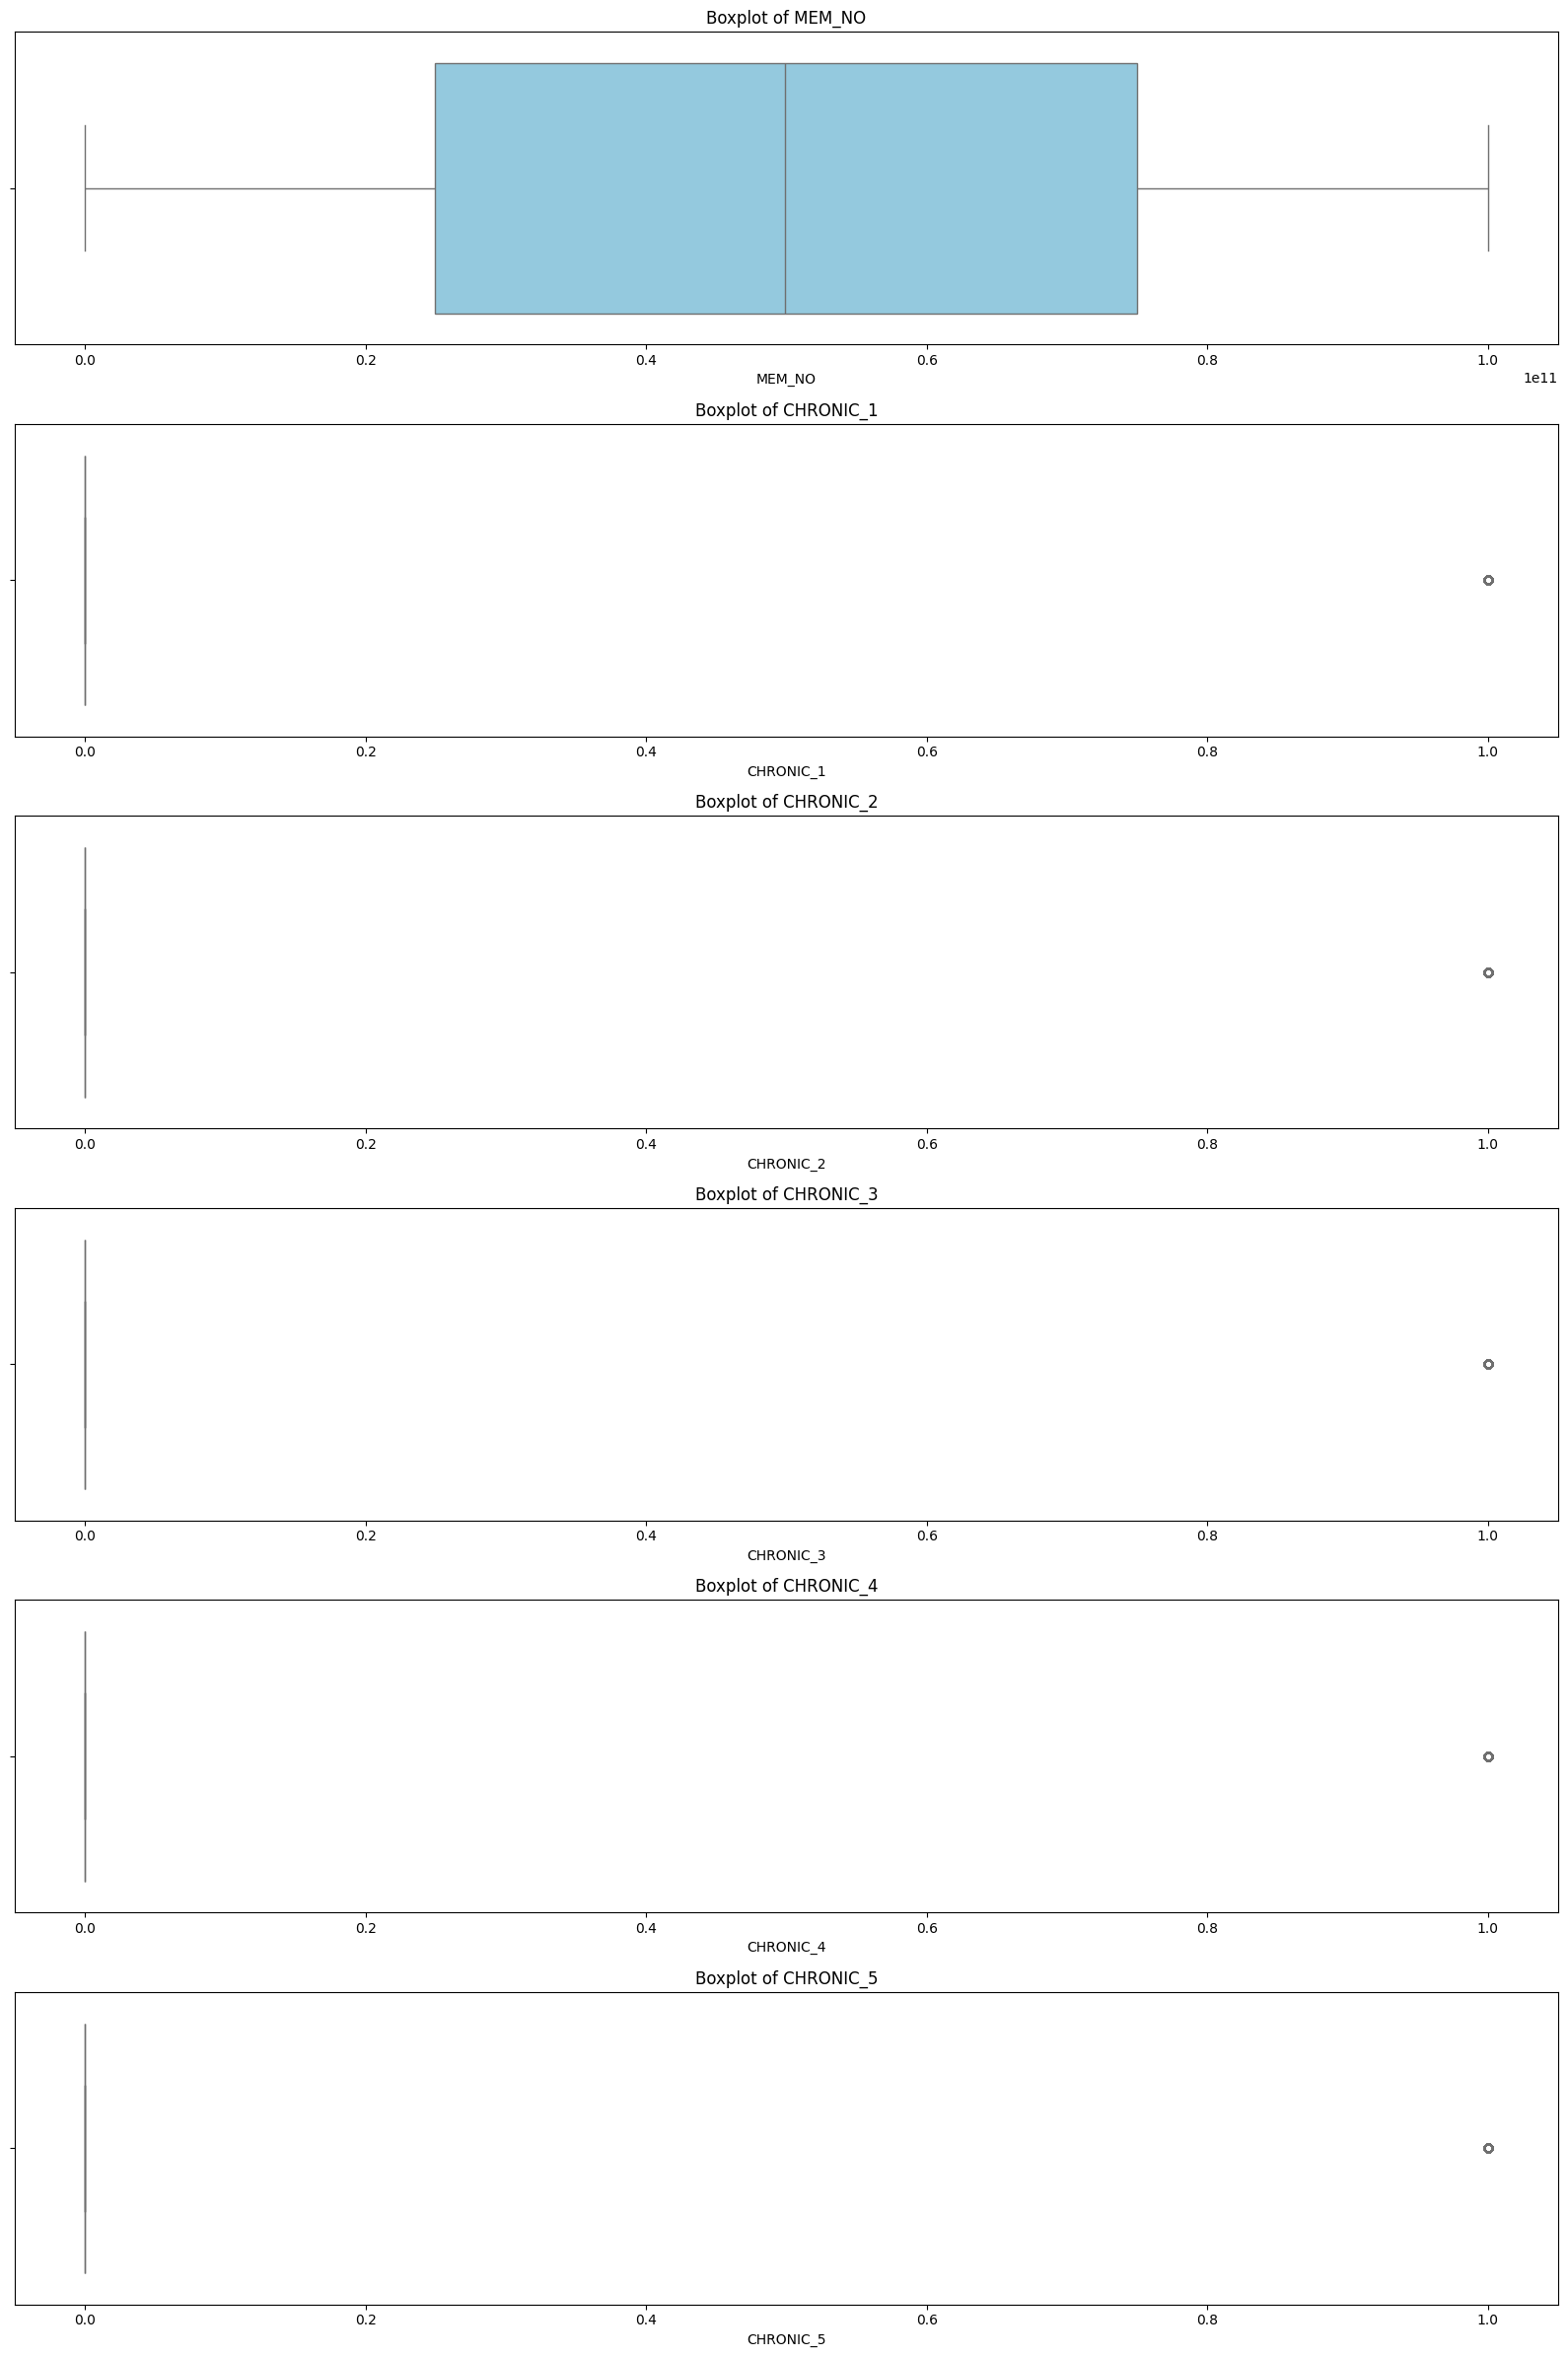

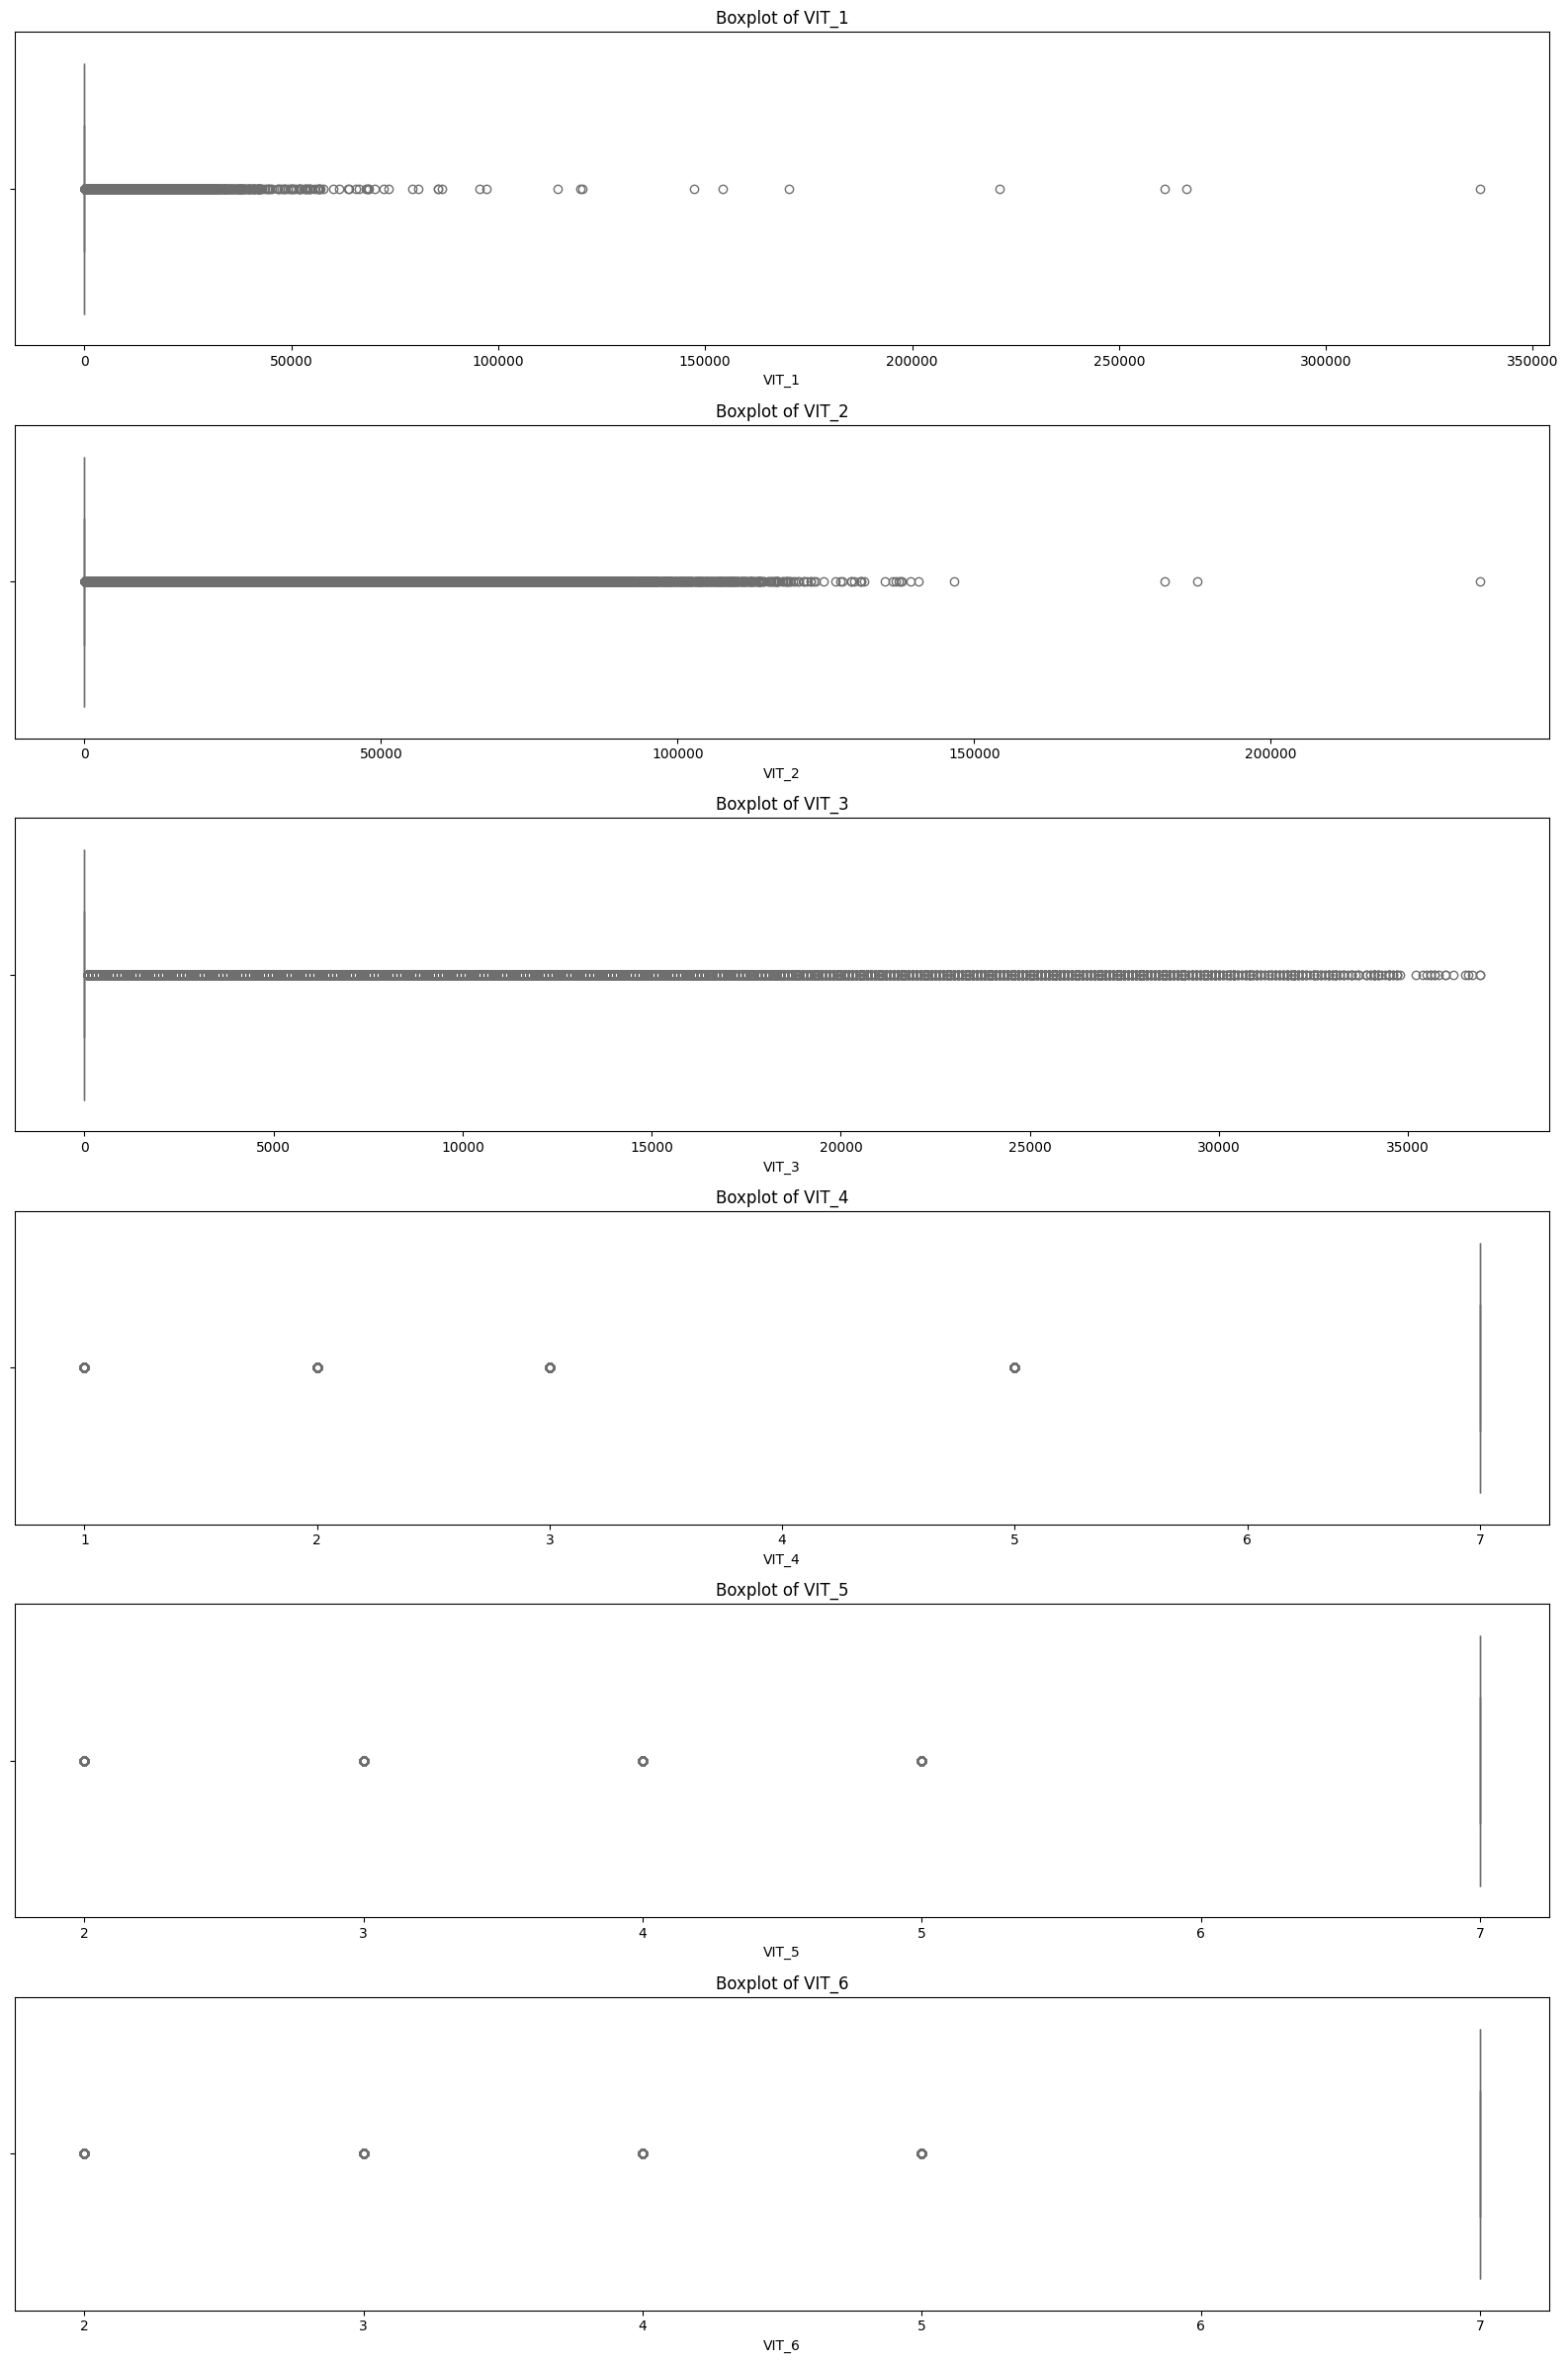

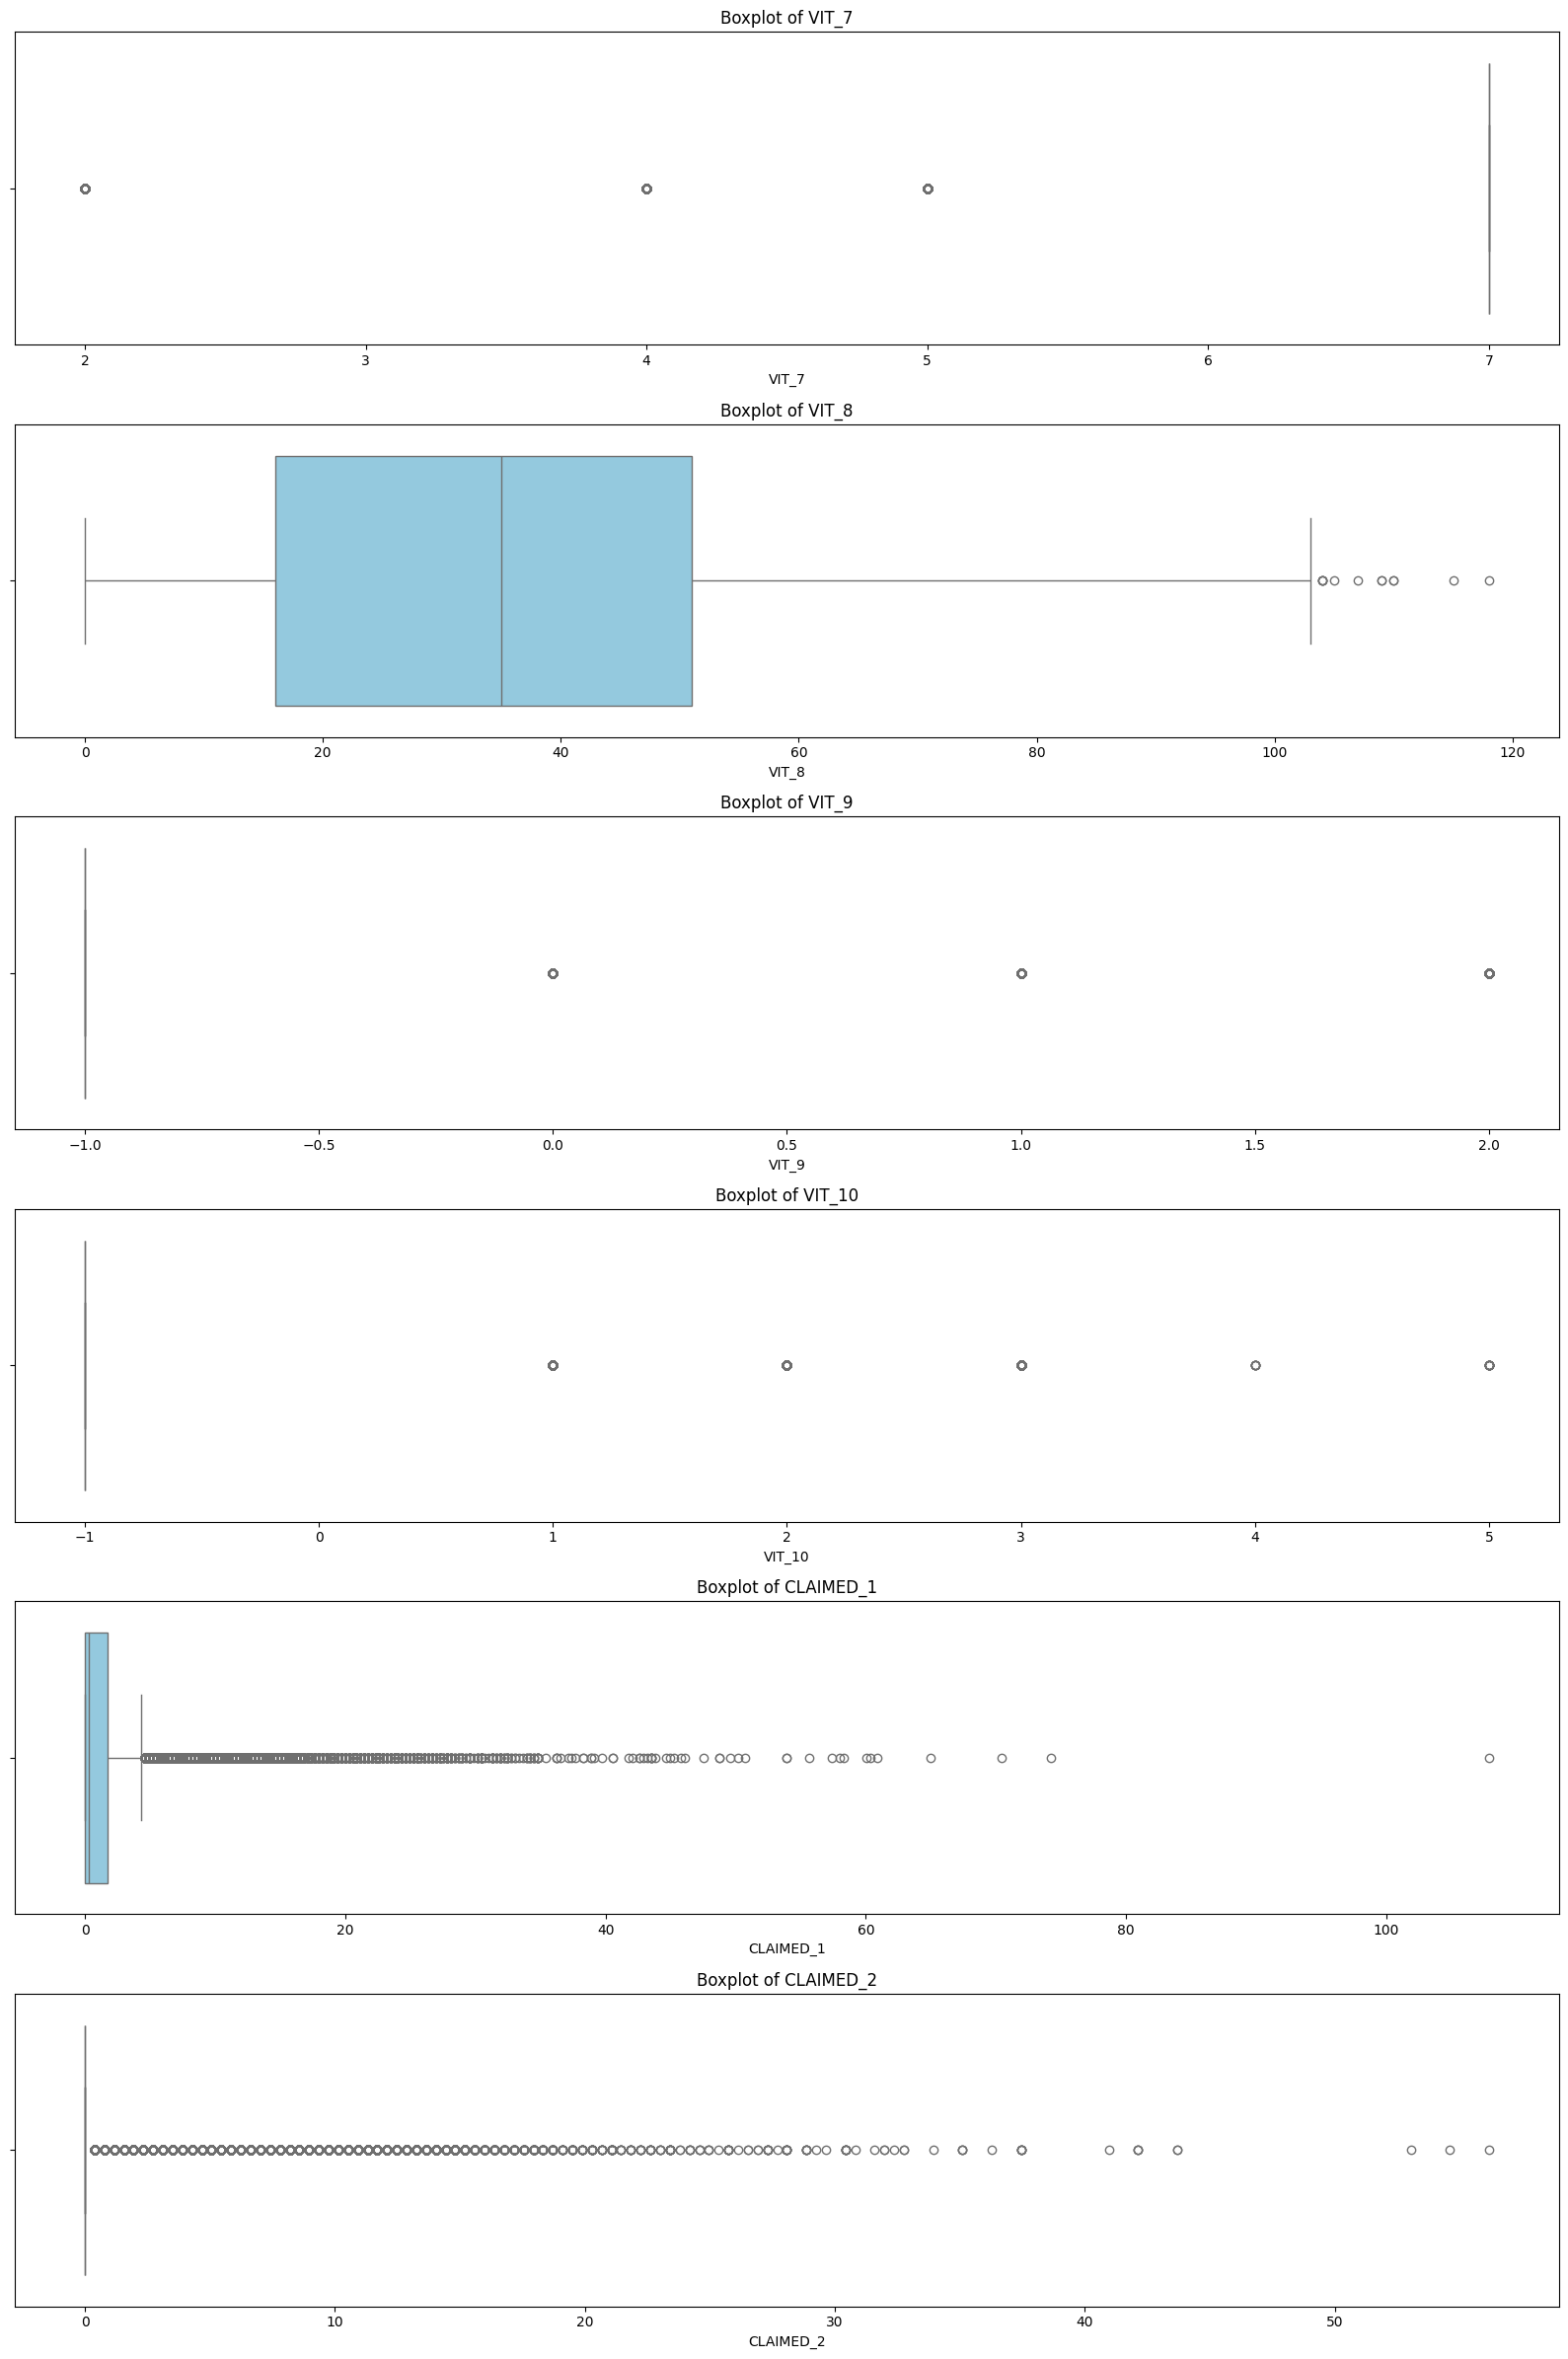

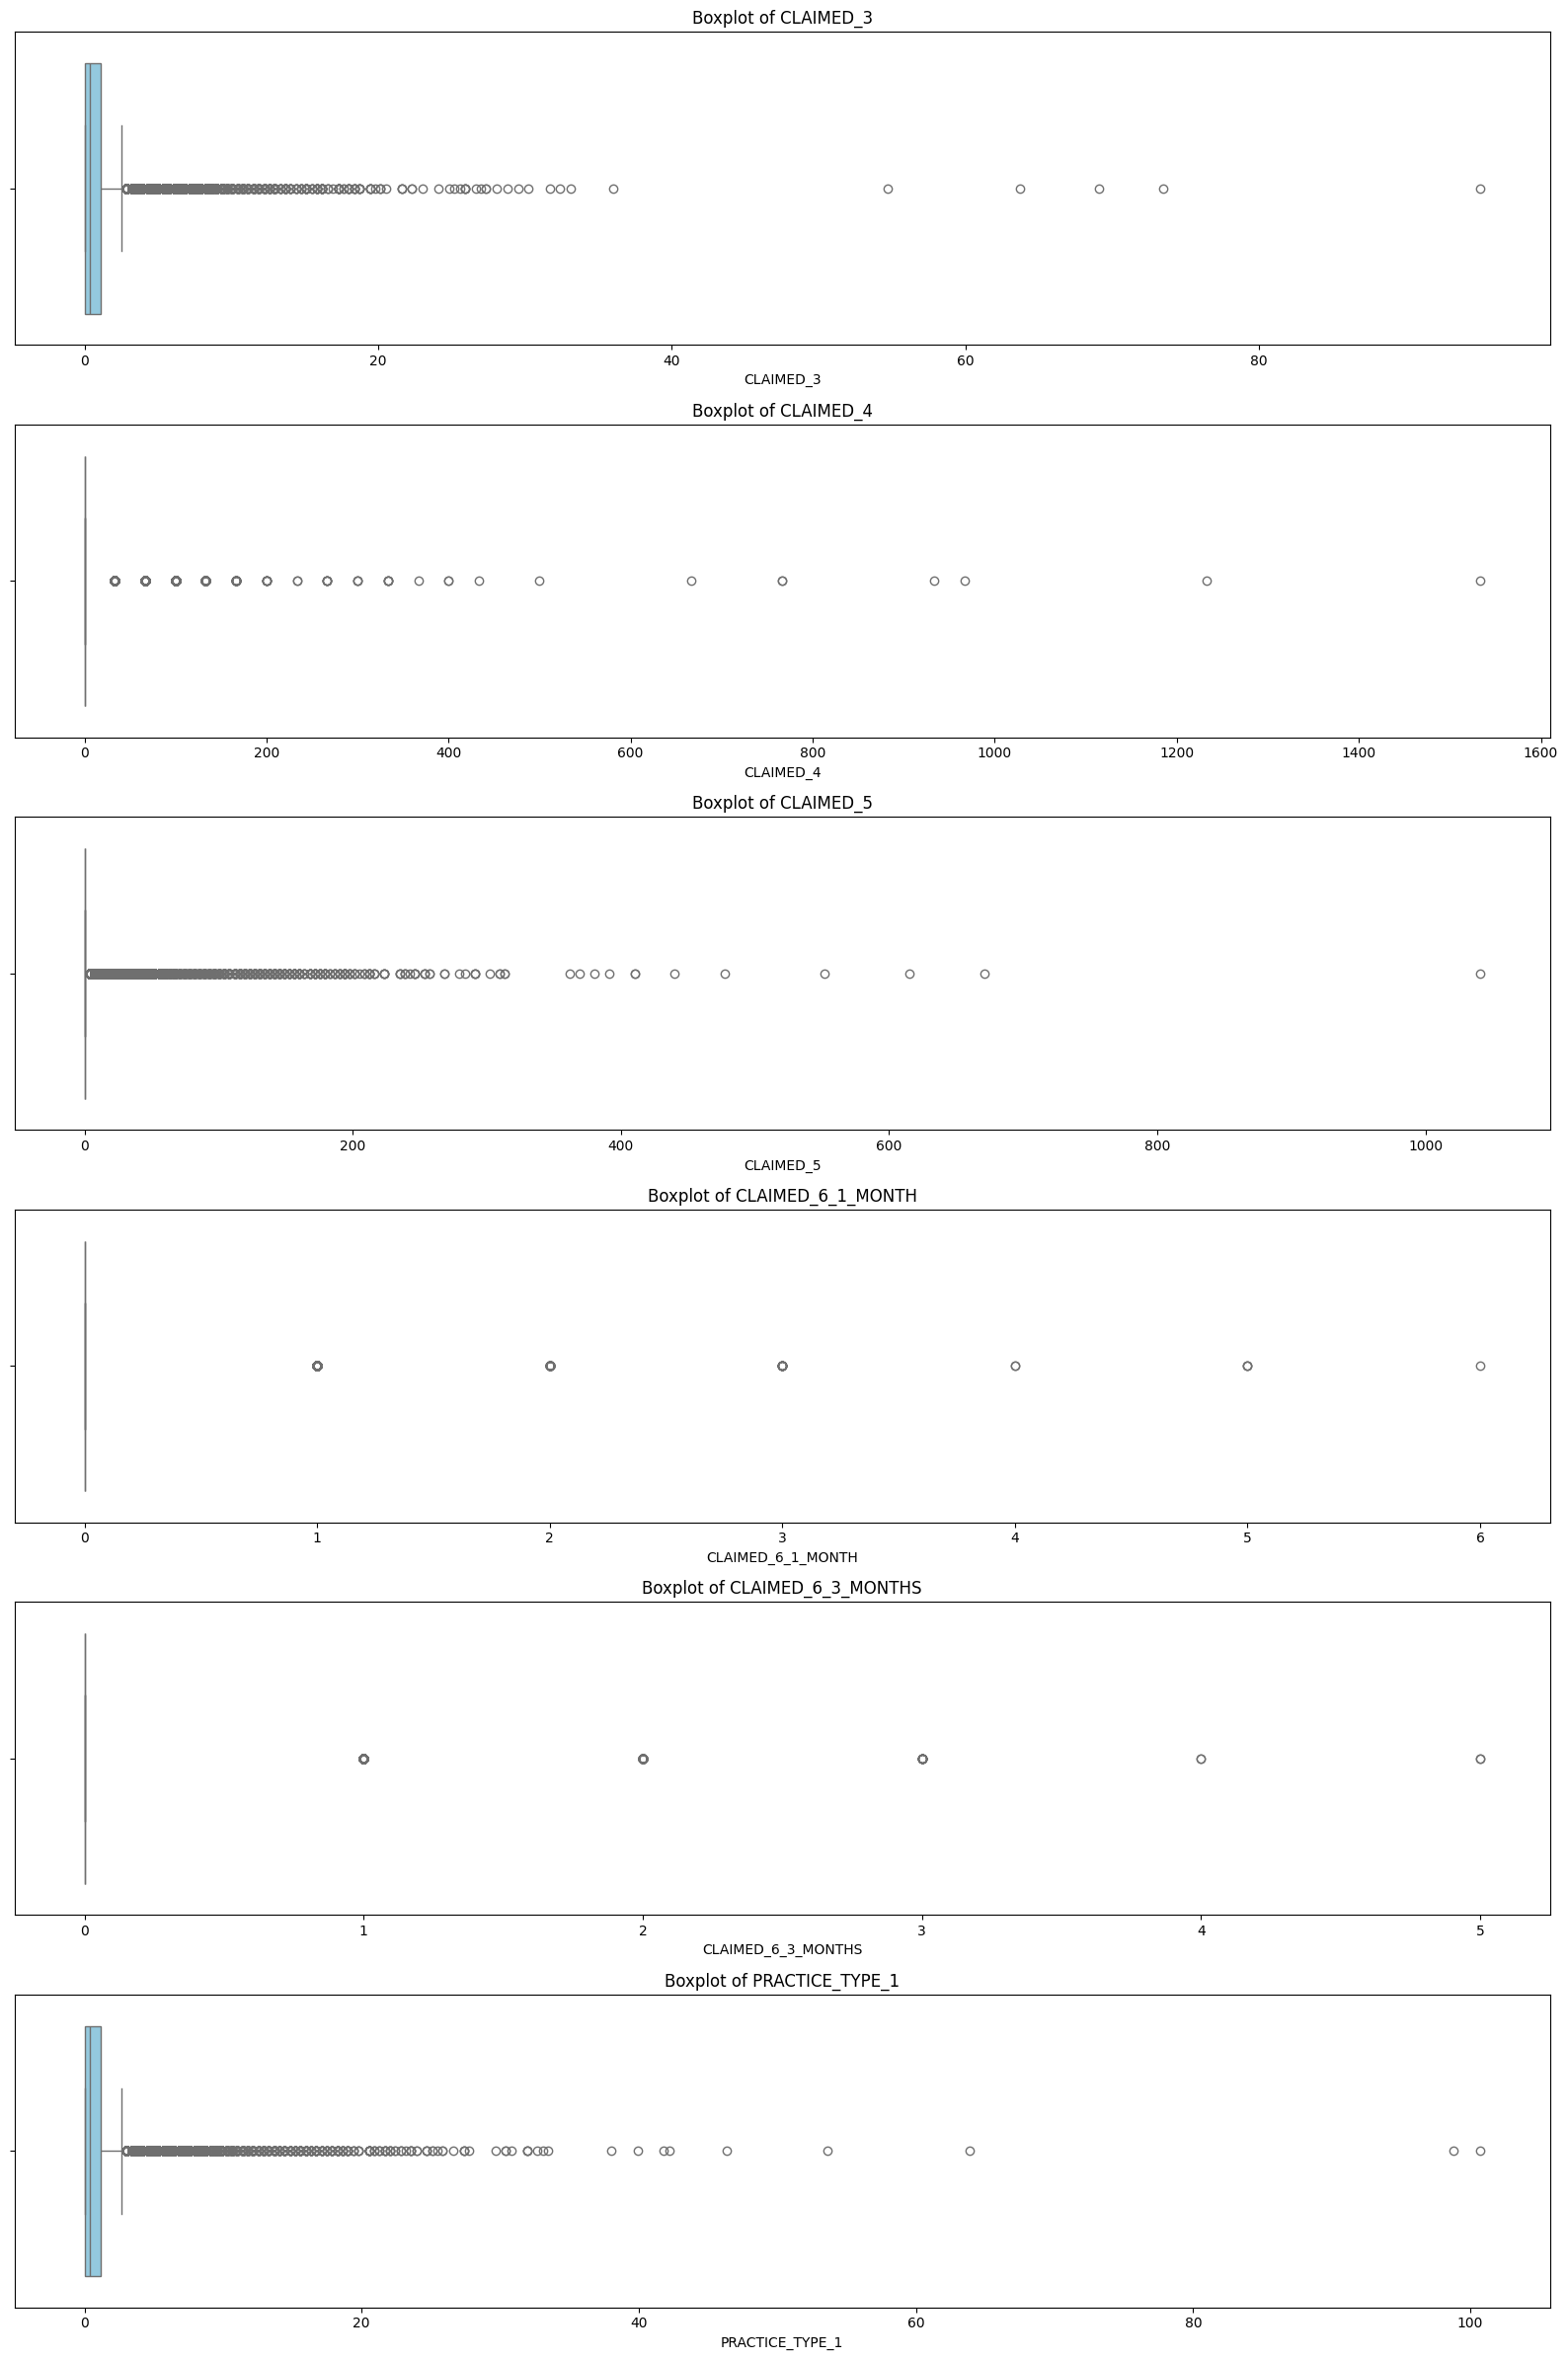

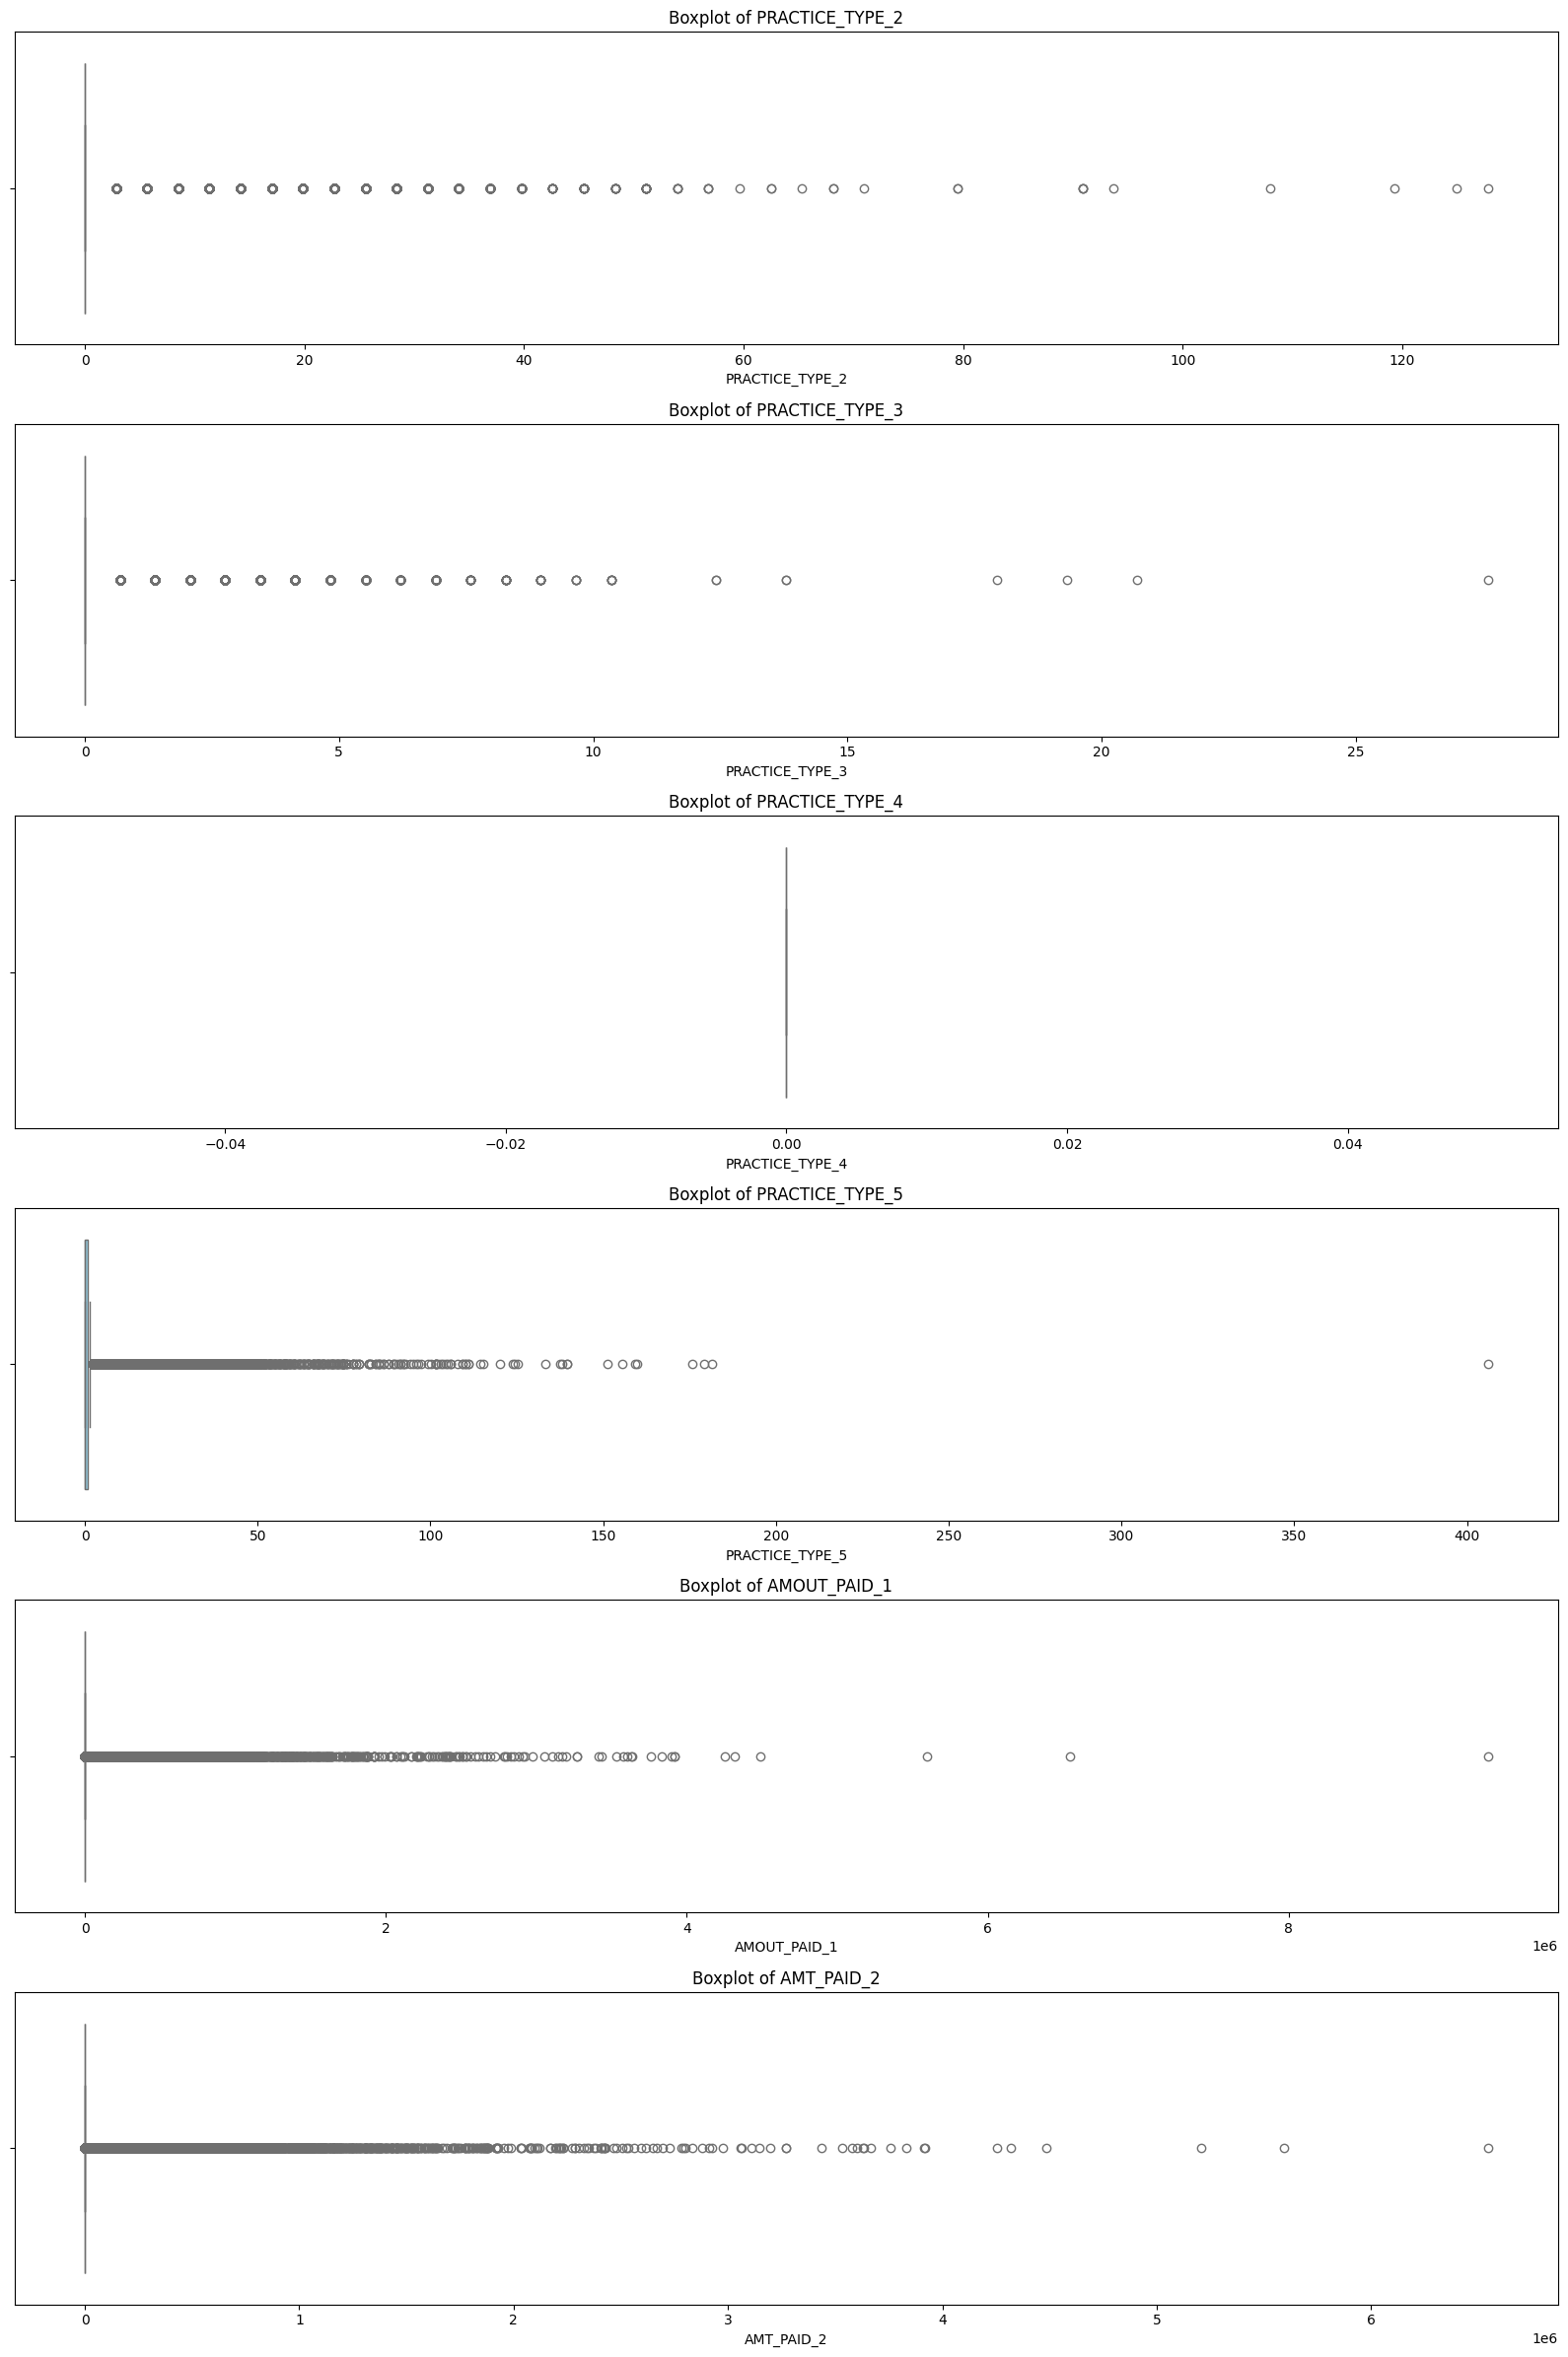

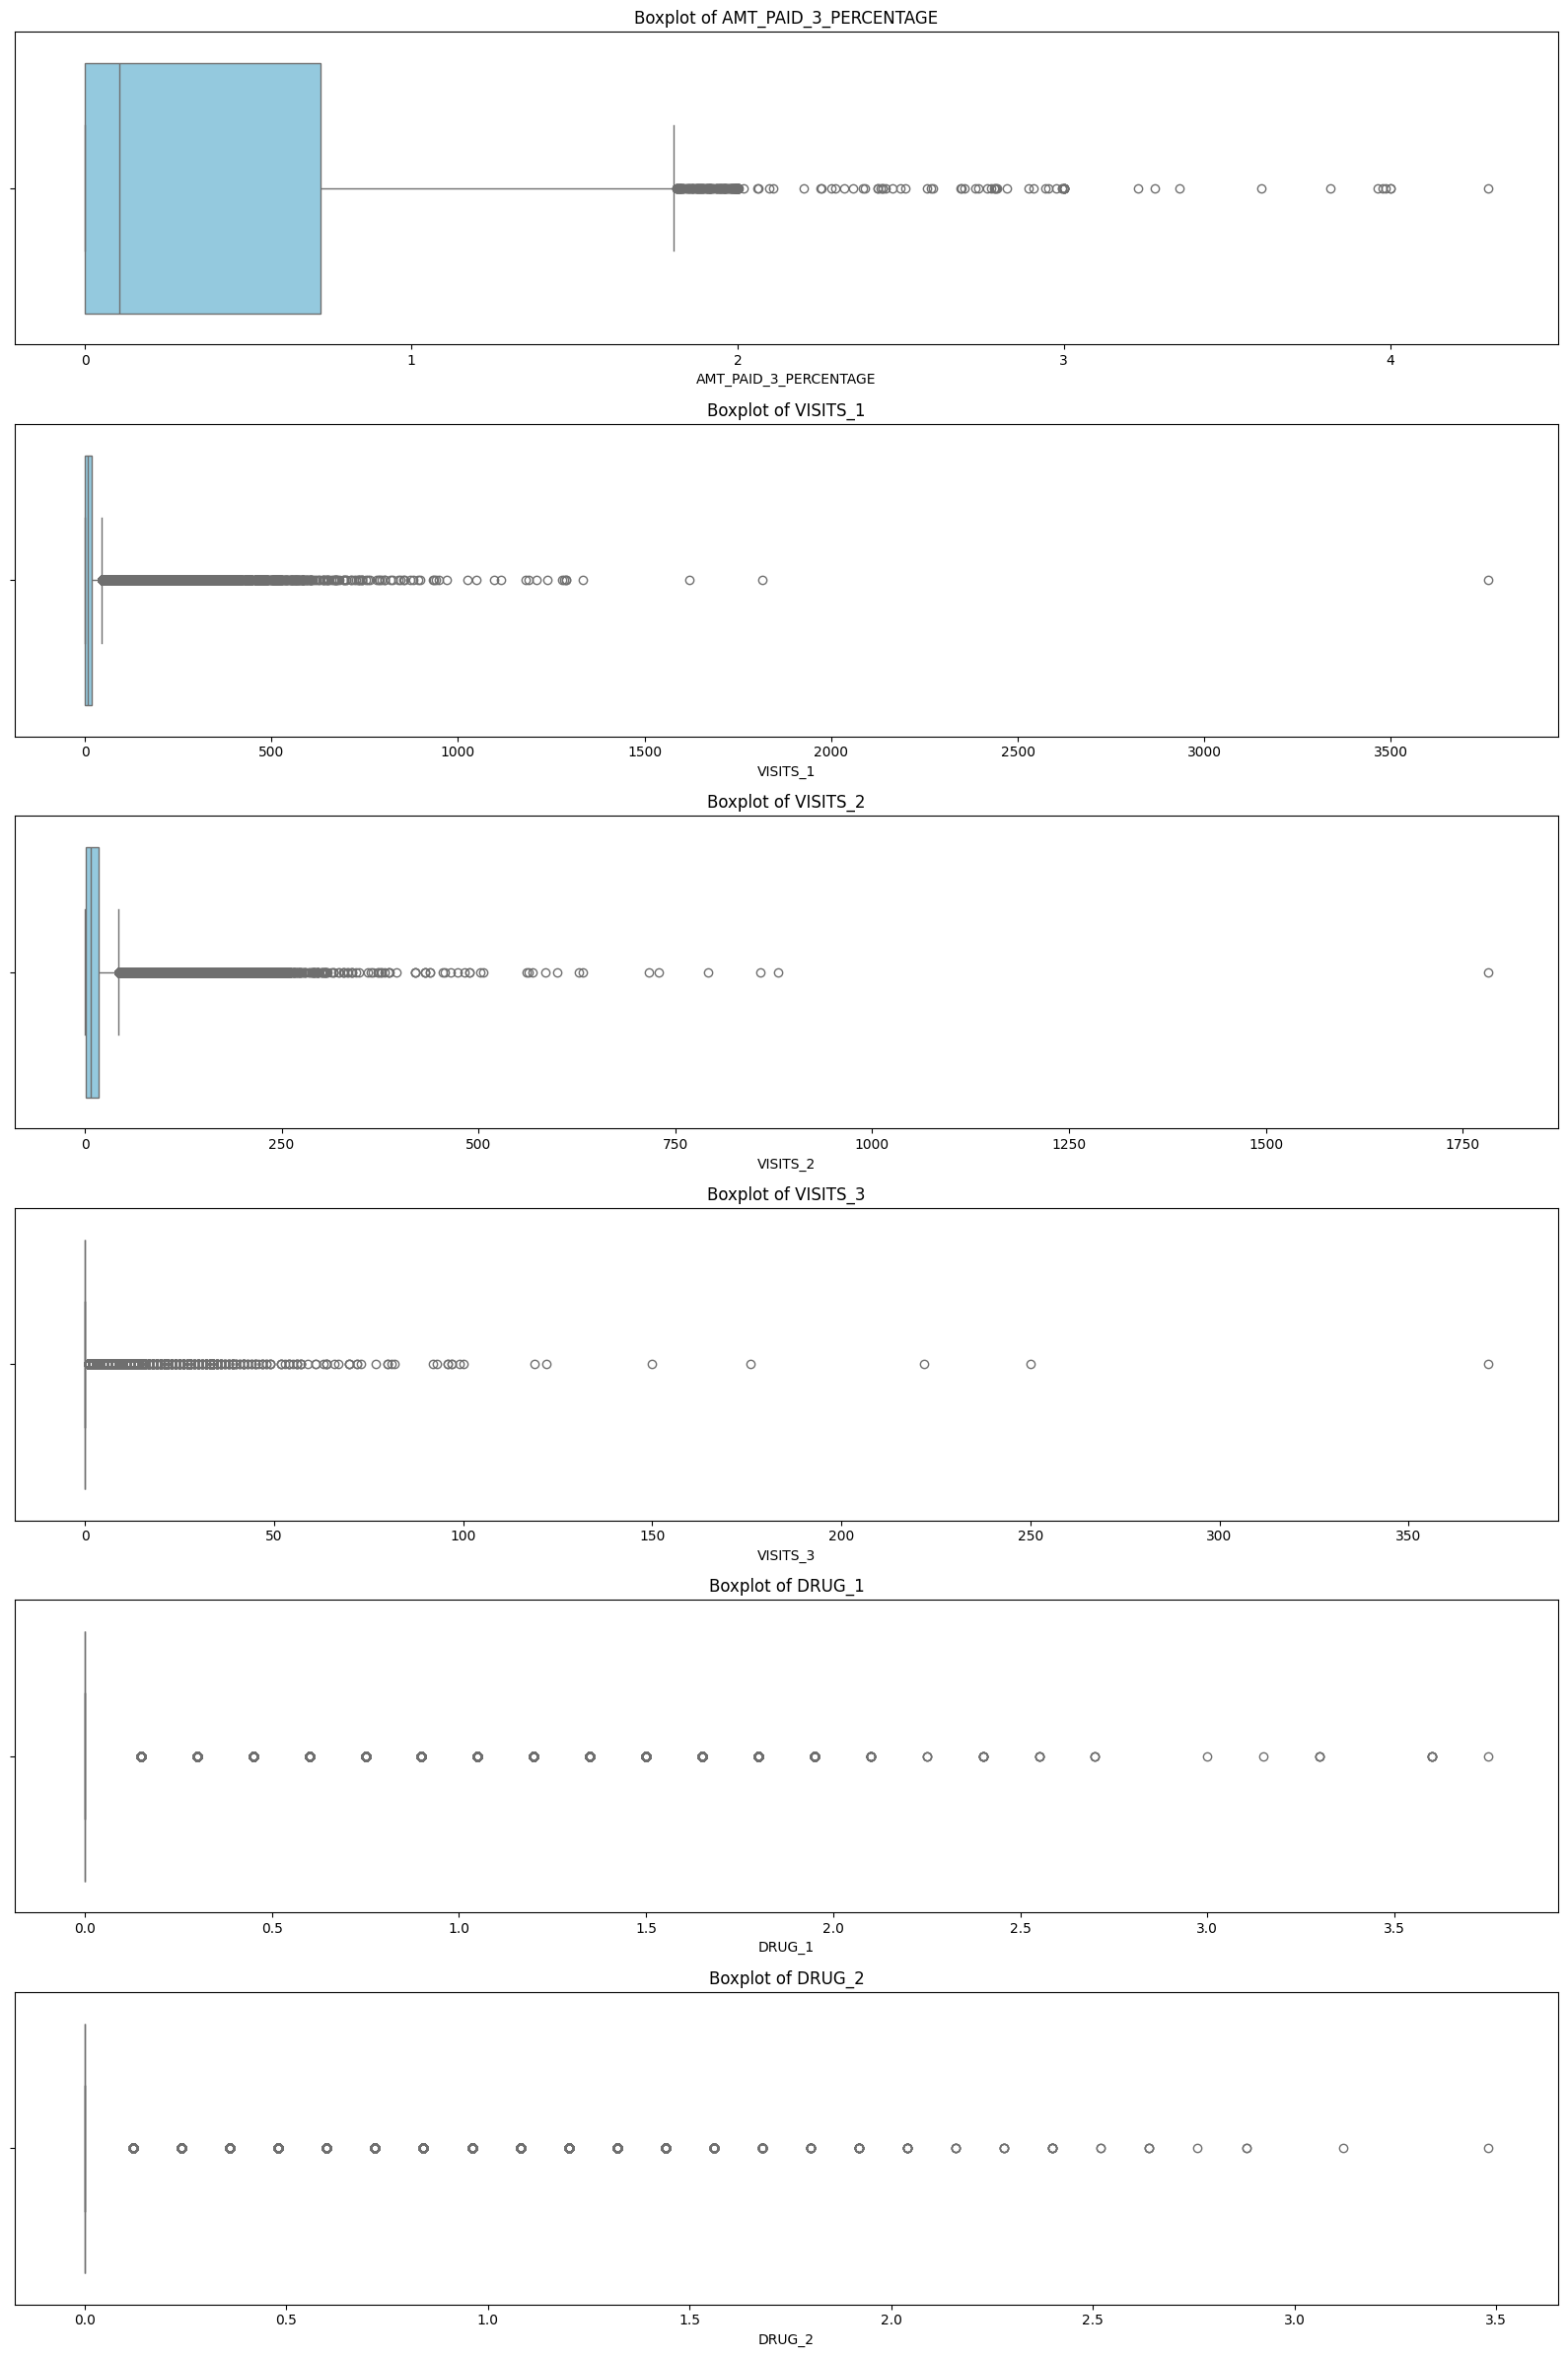

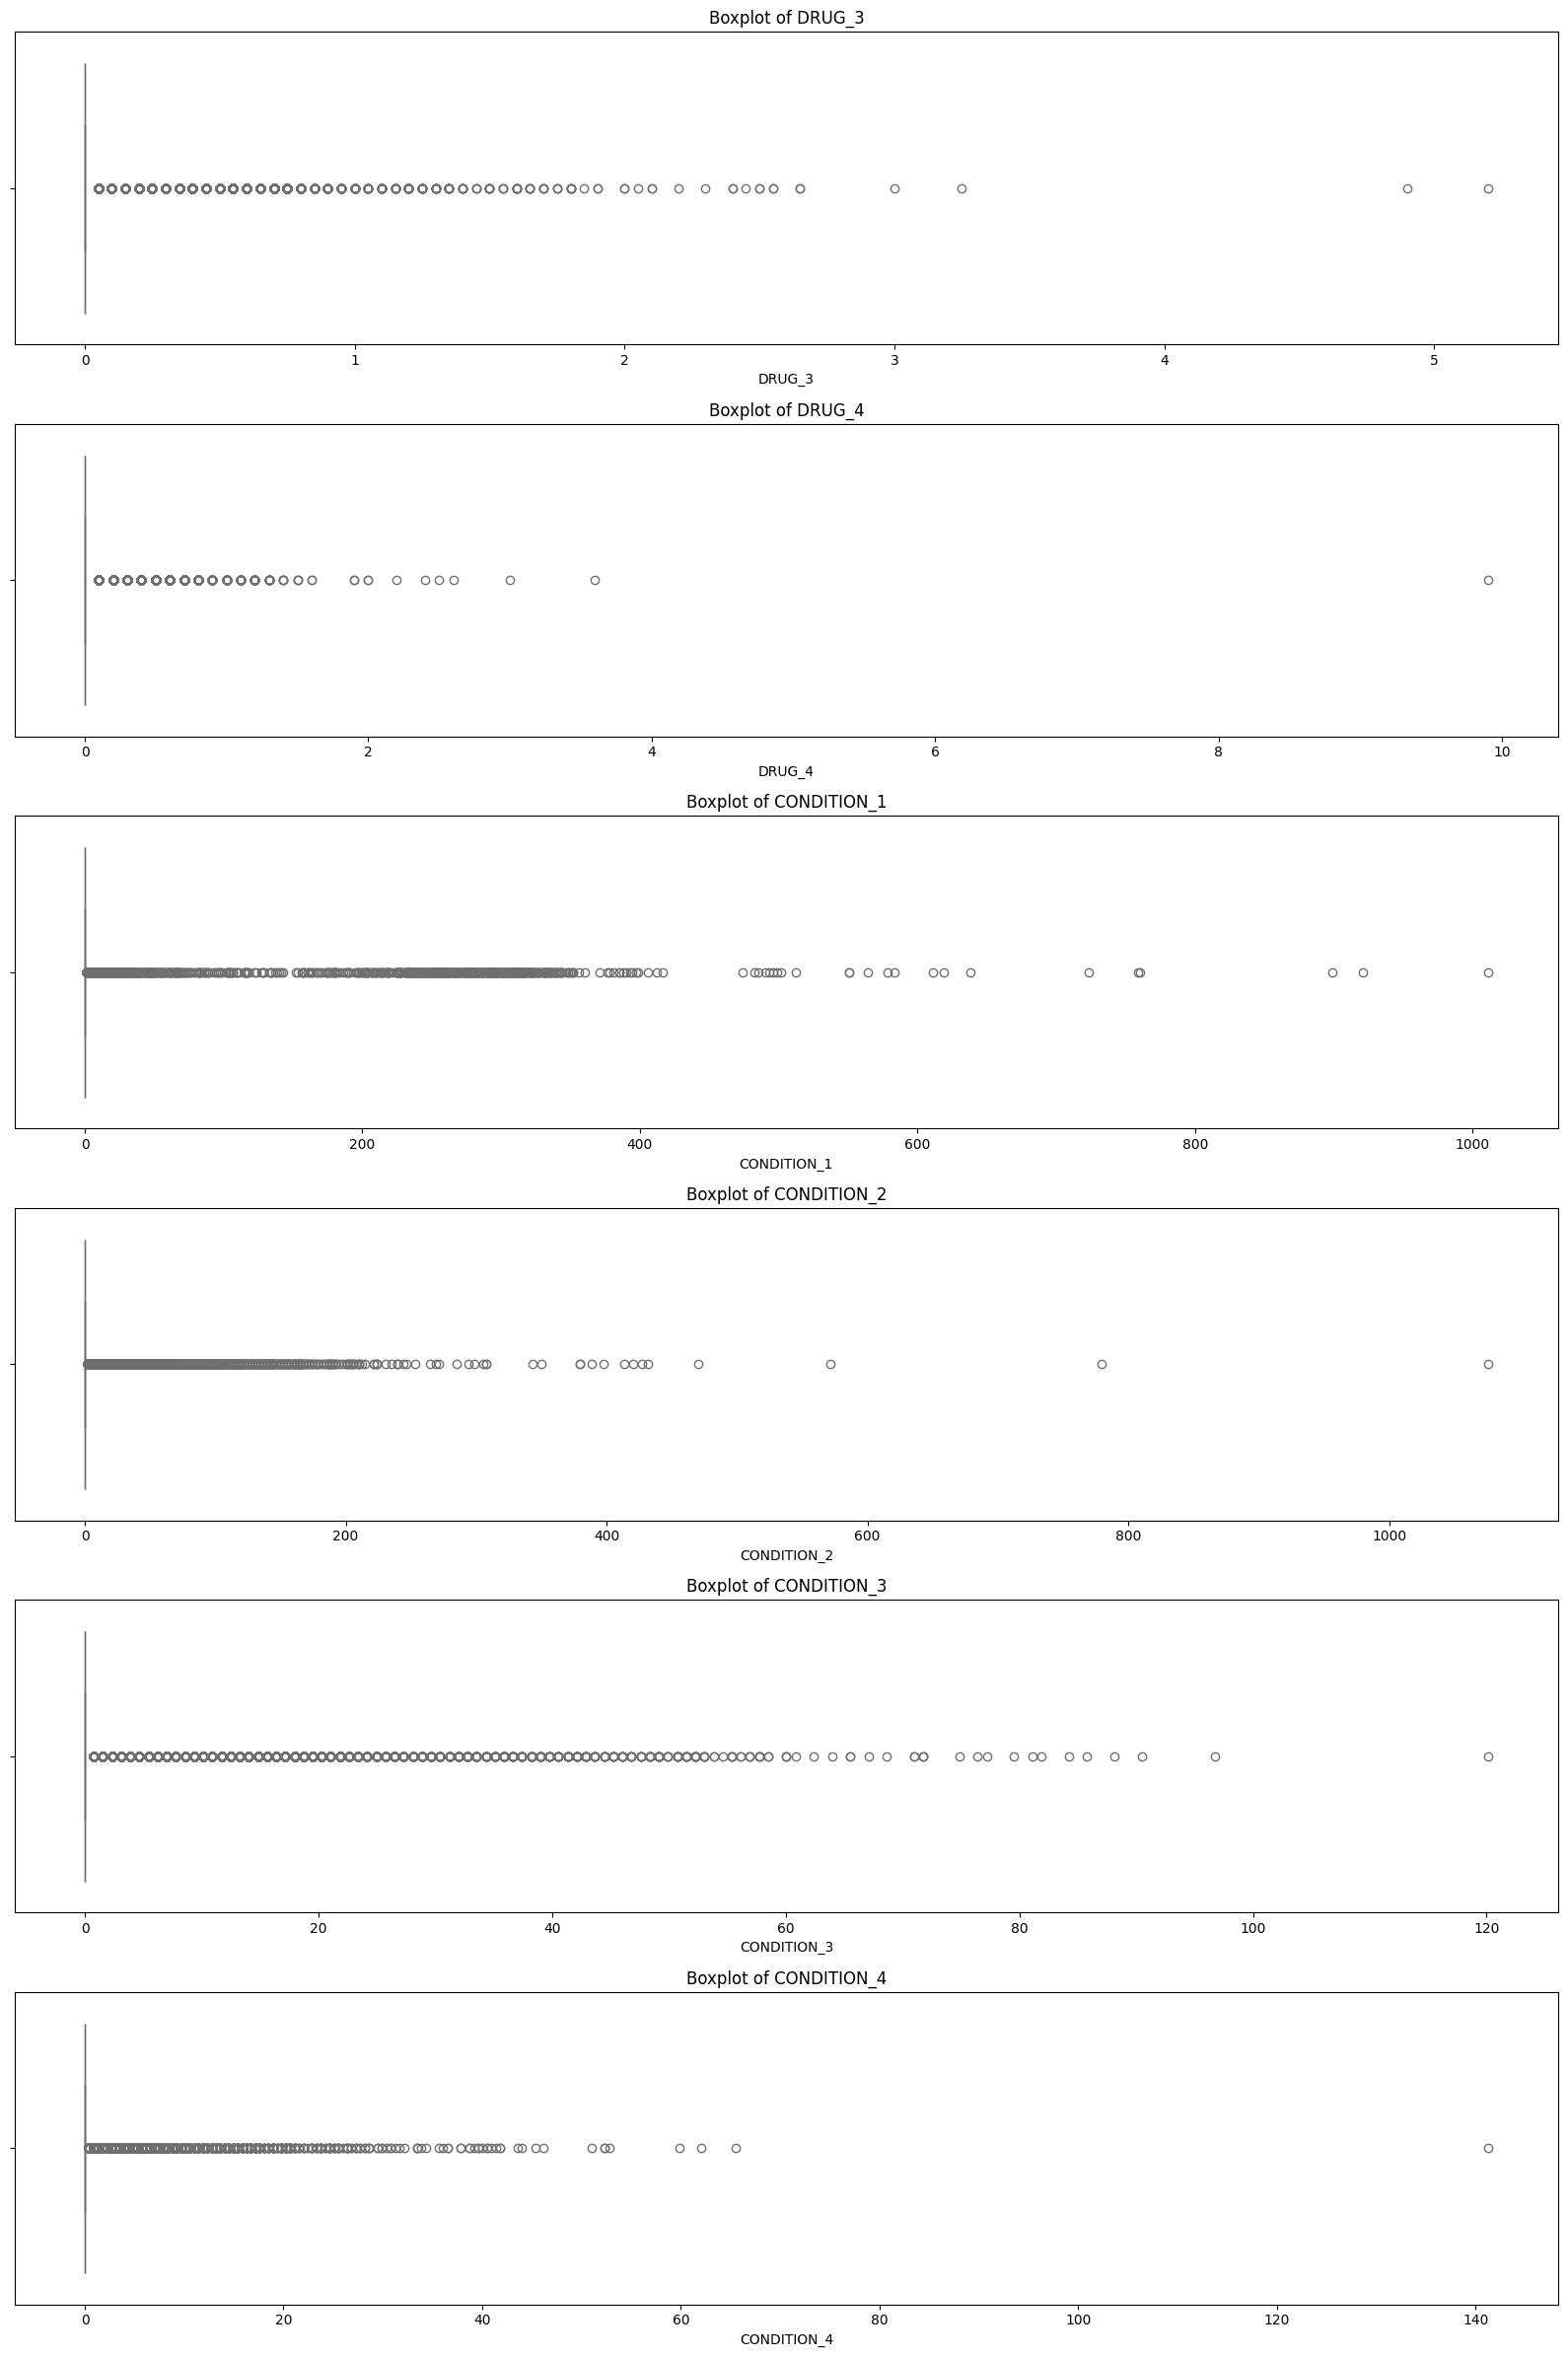

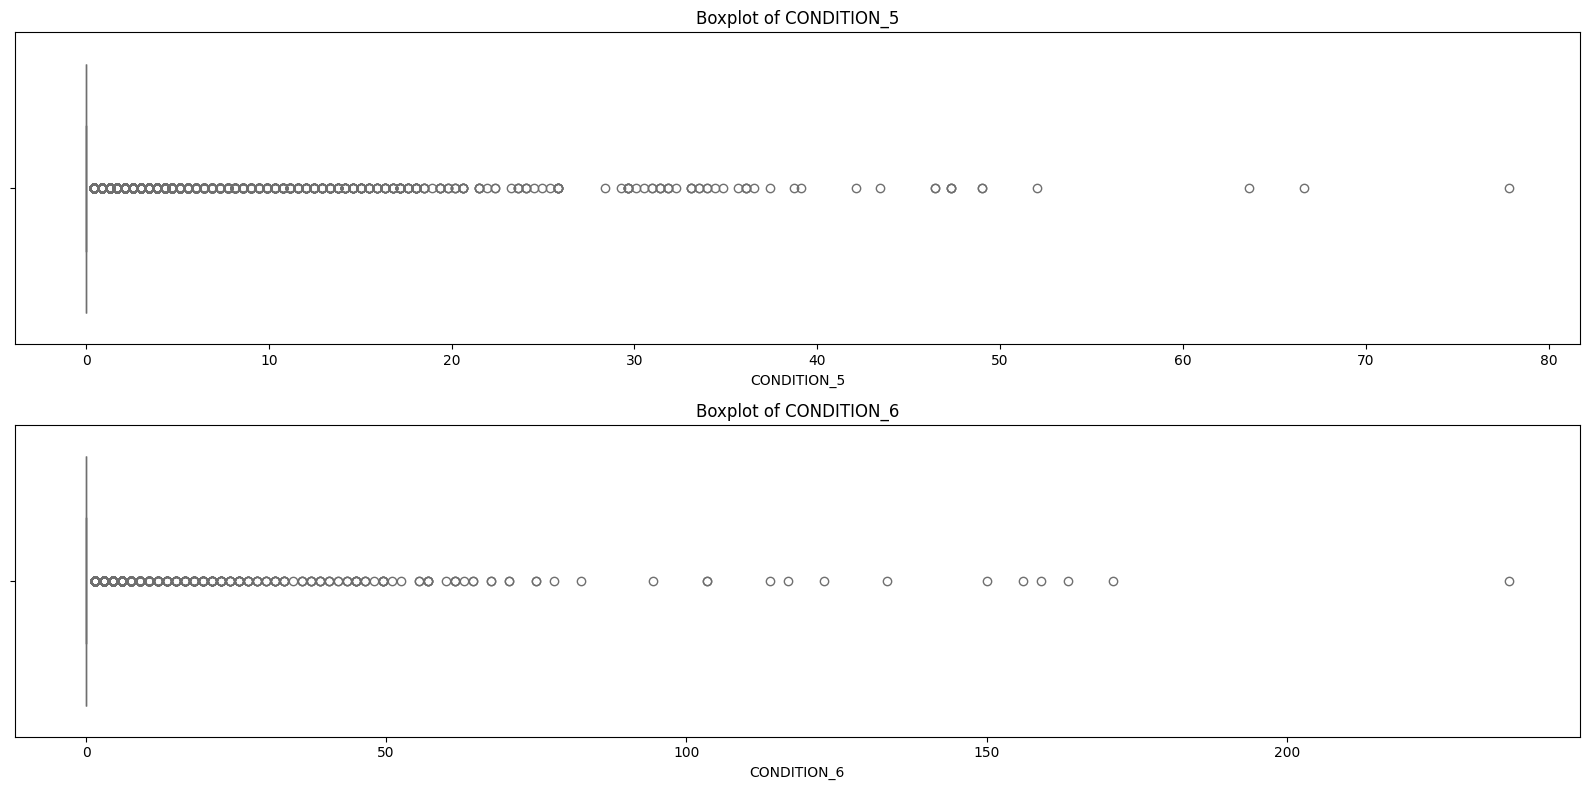

In [8]:
# Select all numeric columns except the target variable.
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('LABEL', errors='ignore')

# Plot boxplots in batches for readability (e.g., 6 per figure)
def plot_boxplots(df, cols, batch_size=6):
    for i in range(0, len(cols), batch_size):
        batch = cols[i:i+batch_size]
        plt.figure(figsize=(16, 4 * len(batch)))
        for j, col in enumerate(batch, 1):
            plt.subplot(len(batch), 1, j)
            sns.boxplot(x=df[col], color='skyblue')
            plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

plot_boxplots(df, numeric_cols.tolist())

Across all the provided box plots, a consistent pattern emerges: the features exhibit numerous outliers, predominantly on the higher end of their respective scales.

Many features, such as 'CLAIMED_3', 'CLAIMED_5', 'PRACTICE_TYPE_1', 'CLAIMED_1', and 'CLAIMED_2', show highly compressed boxes at lower values, indicating that the bulk of their data is concentrated there, while a significant number of individual points extend far out, representing rare but much larger values. Specifically, 'CLAIMED_4' and 'CLAIMED_2' display particularly extreme outliers, reaching very high numerical values that are far removed from the general data distribution.

For the 'VIT' features, 'VIT_7', 'VIT_9', and 'VIT_10' appear to be discrete or categorical with scattered outlier points, while 'VIT_8' has a more continuous distribution but still shows some outliers.

The 'CHRONIC' features ('CHRONIC_1' through 'CHRONIC_5') are notably concentrated at zero, with '1' values appearing as outliers, suggesting they are binary indicators where the presence of a condition is a rare event.

Overall, the pervasive presence of outliers across these features highlights data distributions that are often heavily skewed, with a small proportion of observations having disproportionately high or distinct values.

In [10]:
# Make a copy of the dataset
log_df = df.copy()
log_cols = numeric_cols  # Assuming numeric_cols is already defined

# Apply log1p only to non-negative values; otherwise set to NaN
for col in log_cols:
    log_df[f'{col}_log'] = log_df[col].apply(lambda x: np.log1p(x) if x >= 0 else np.nan)

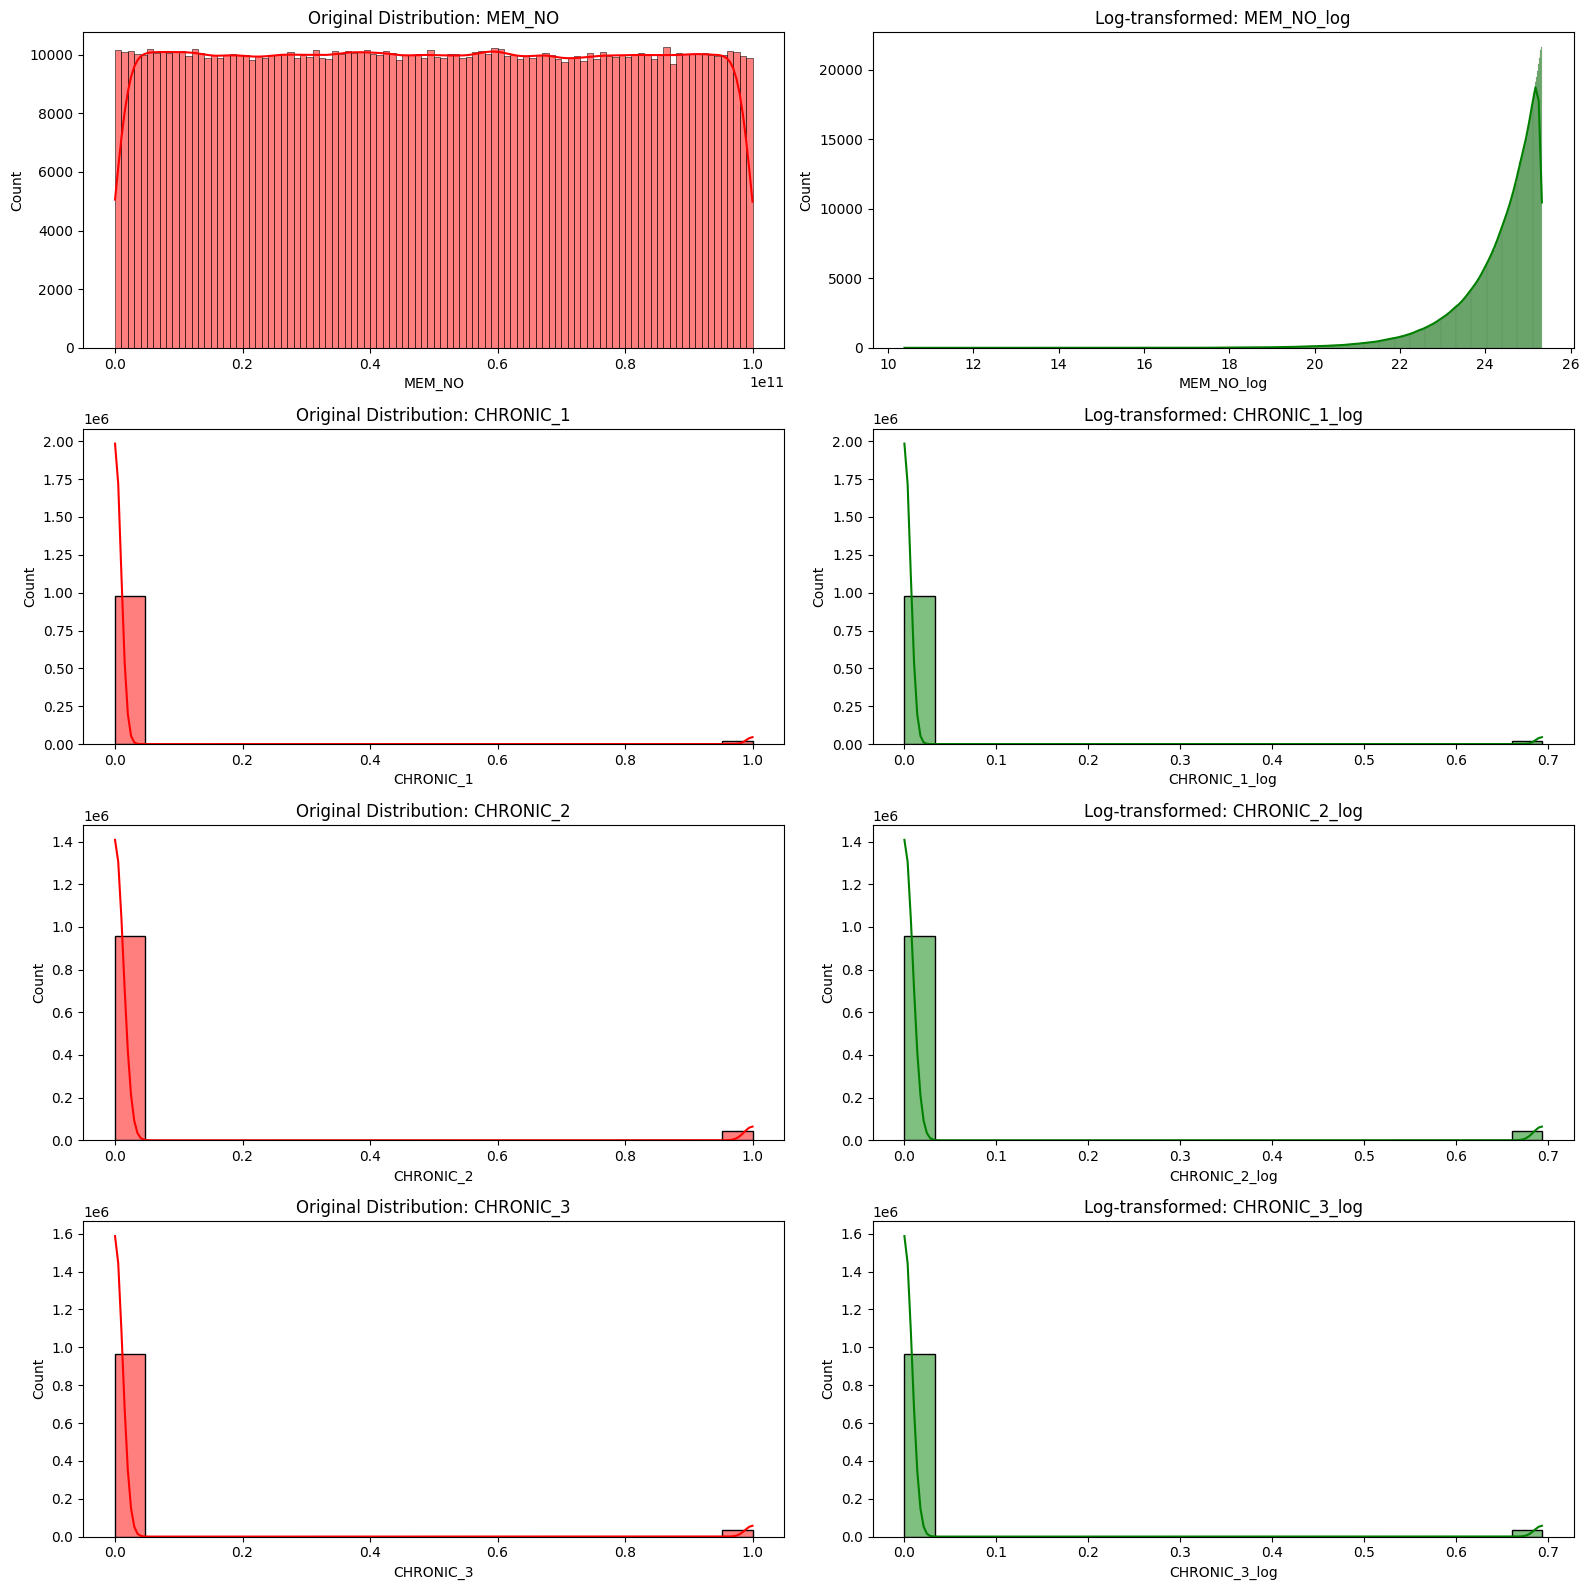

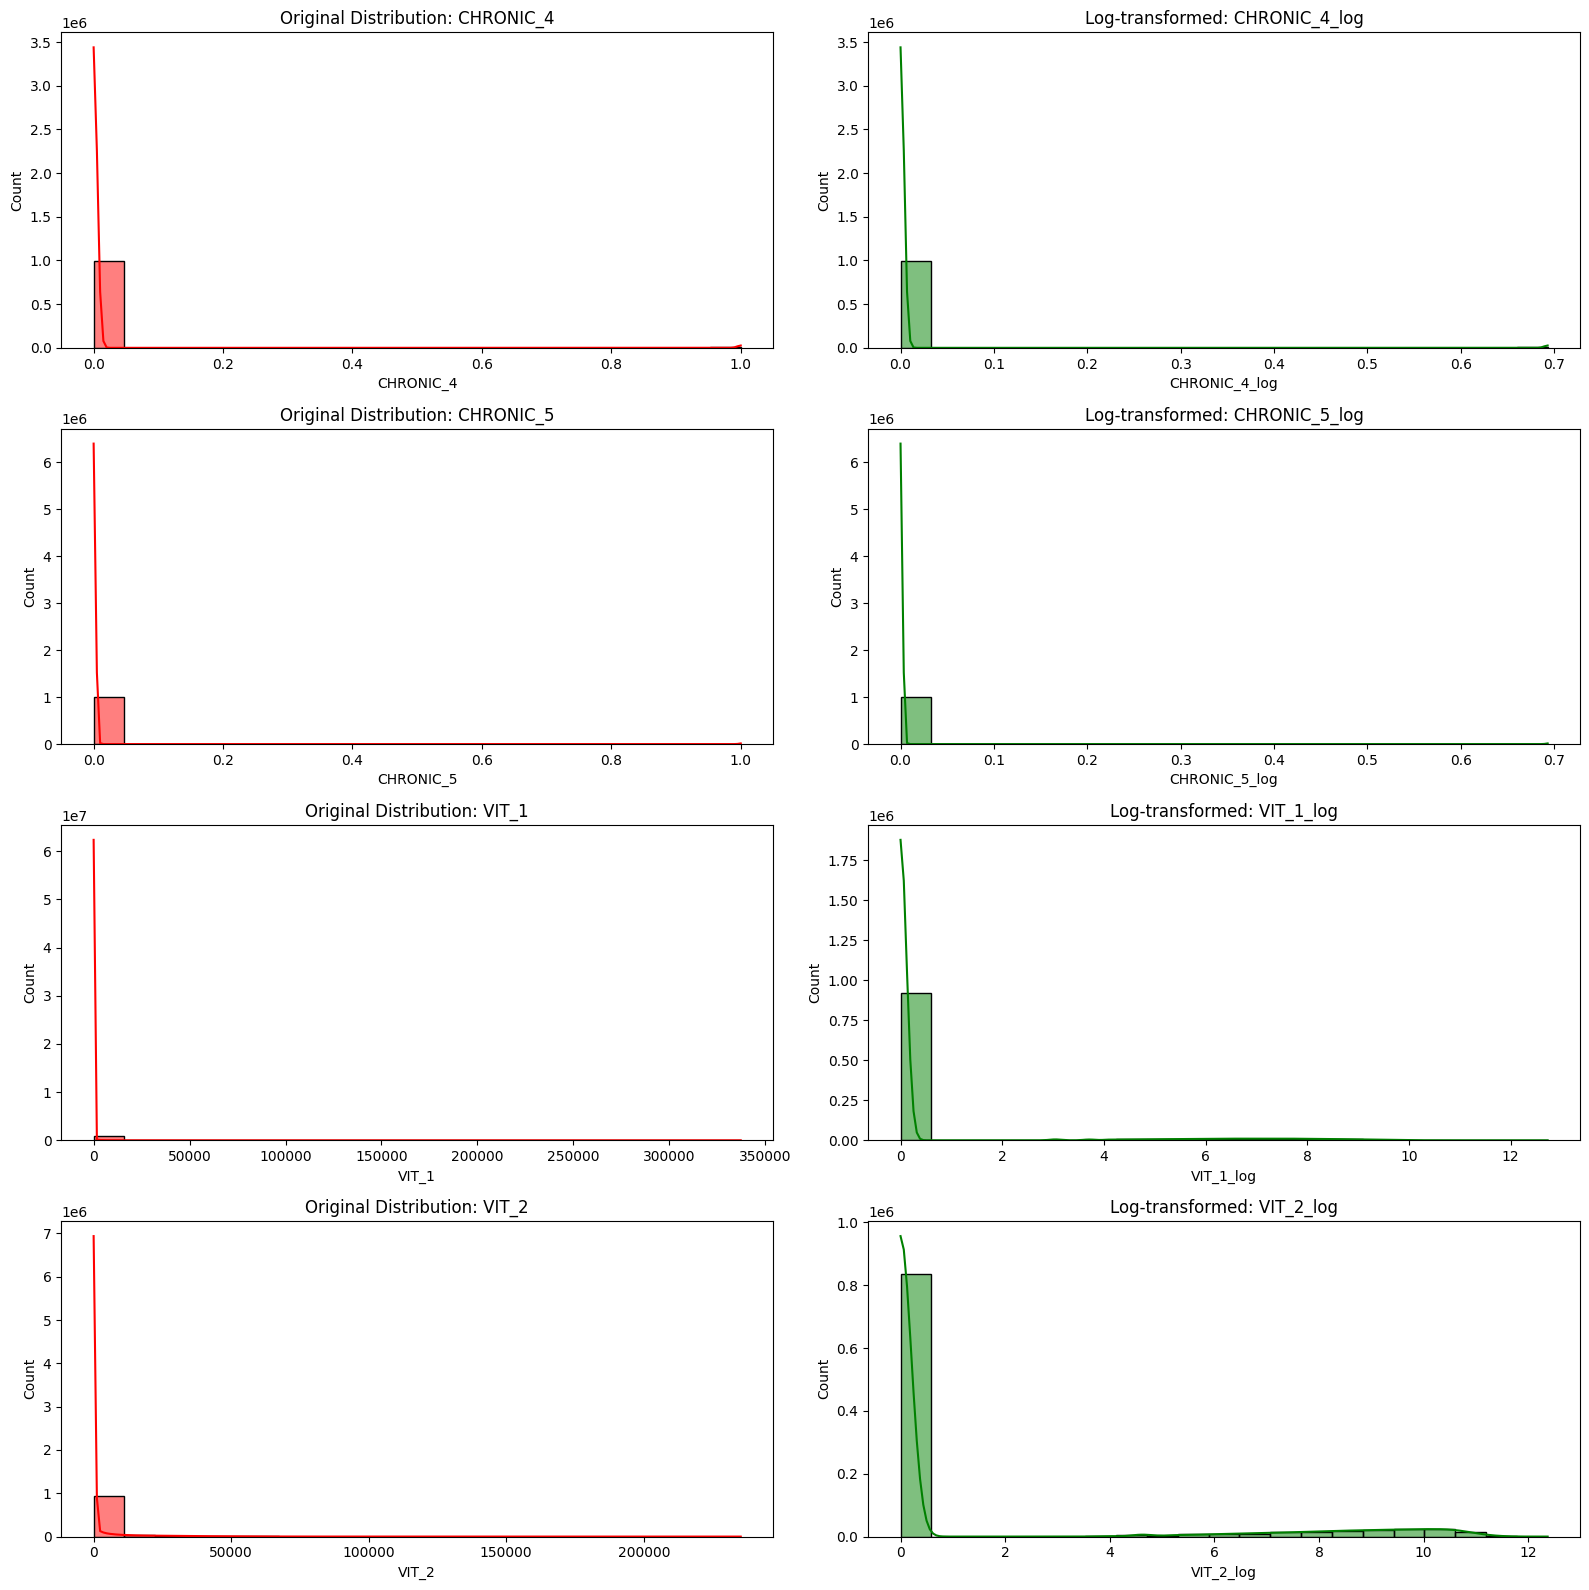

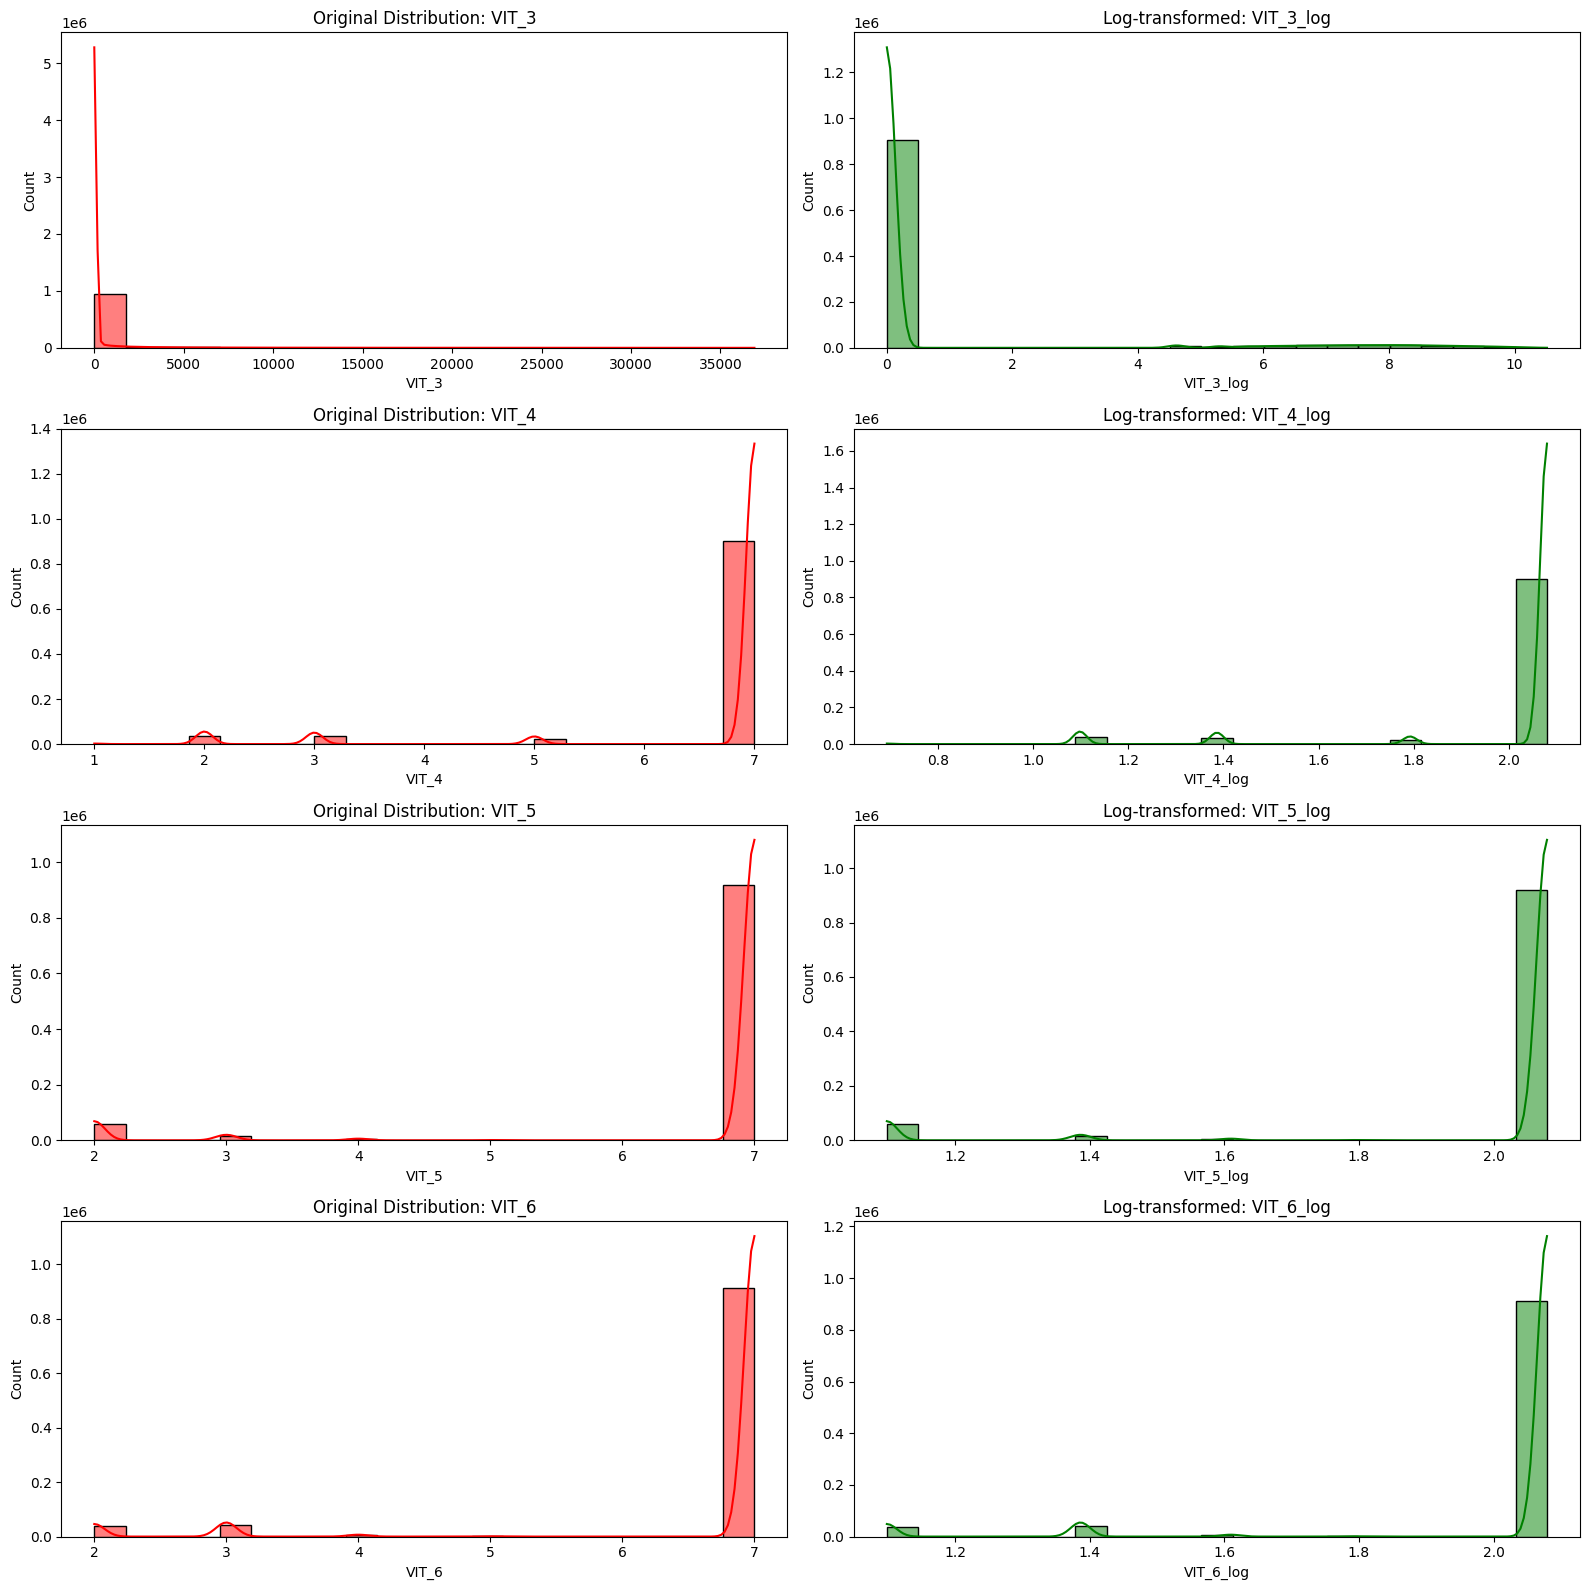

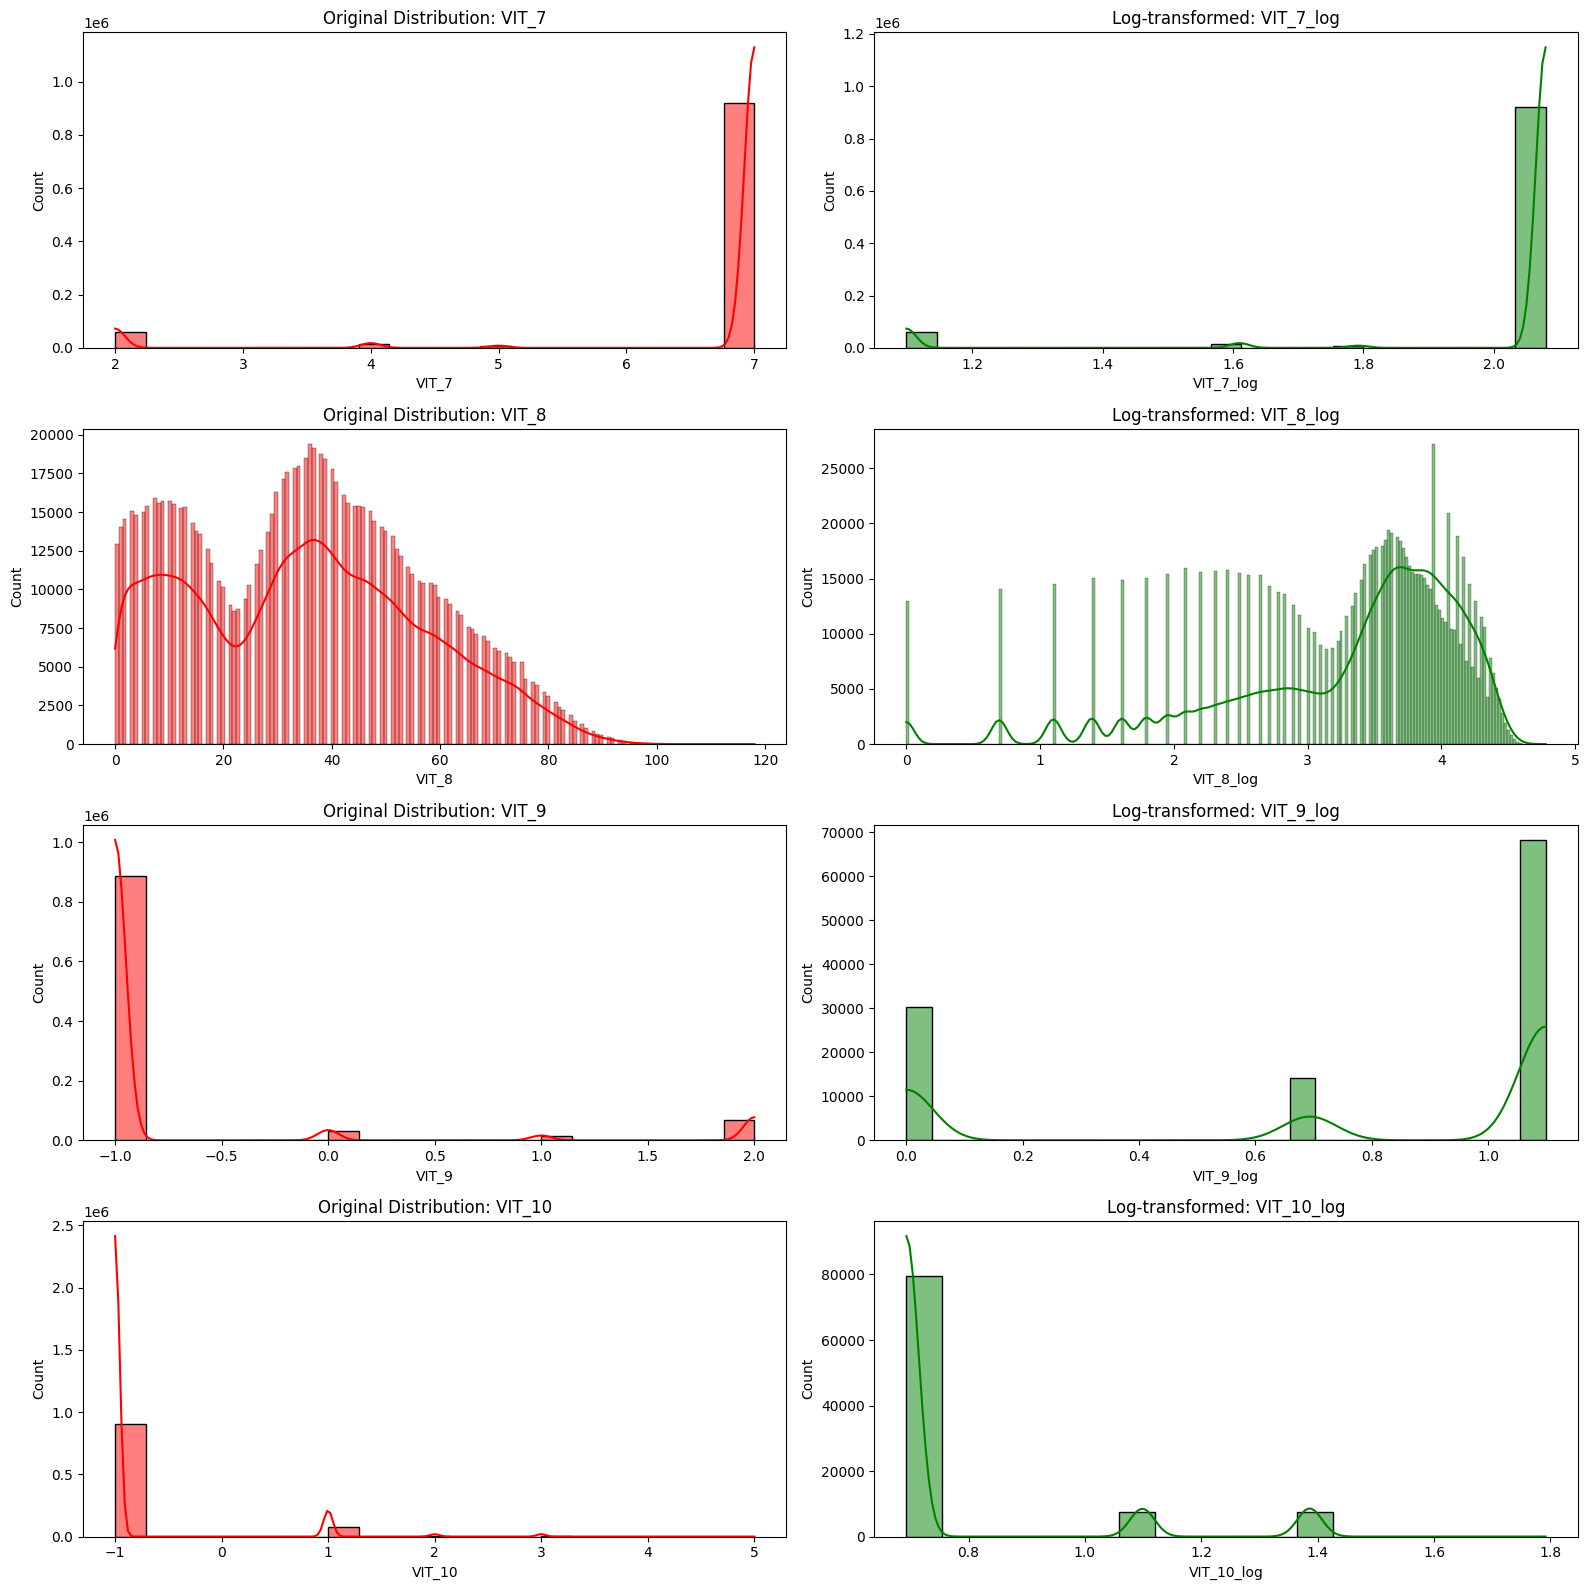

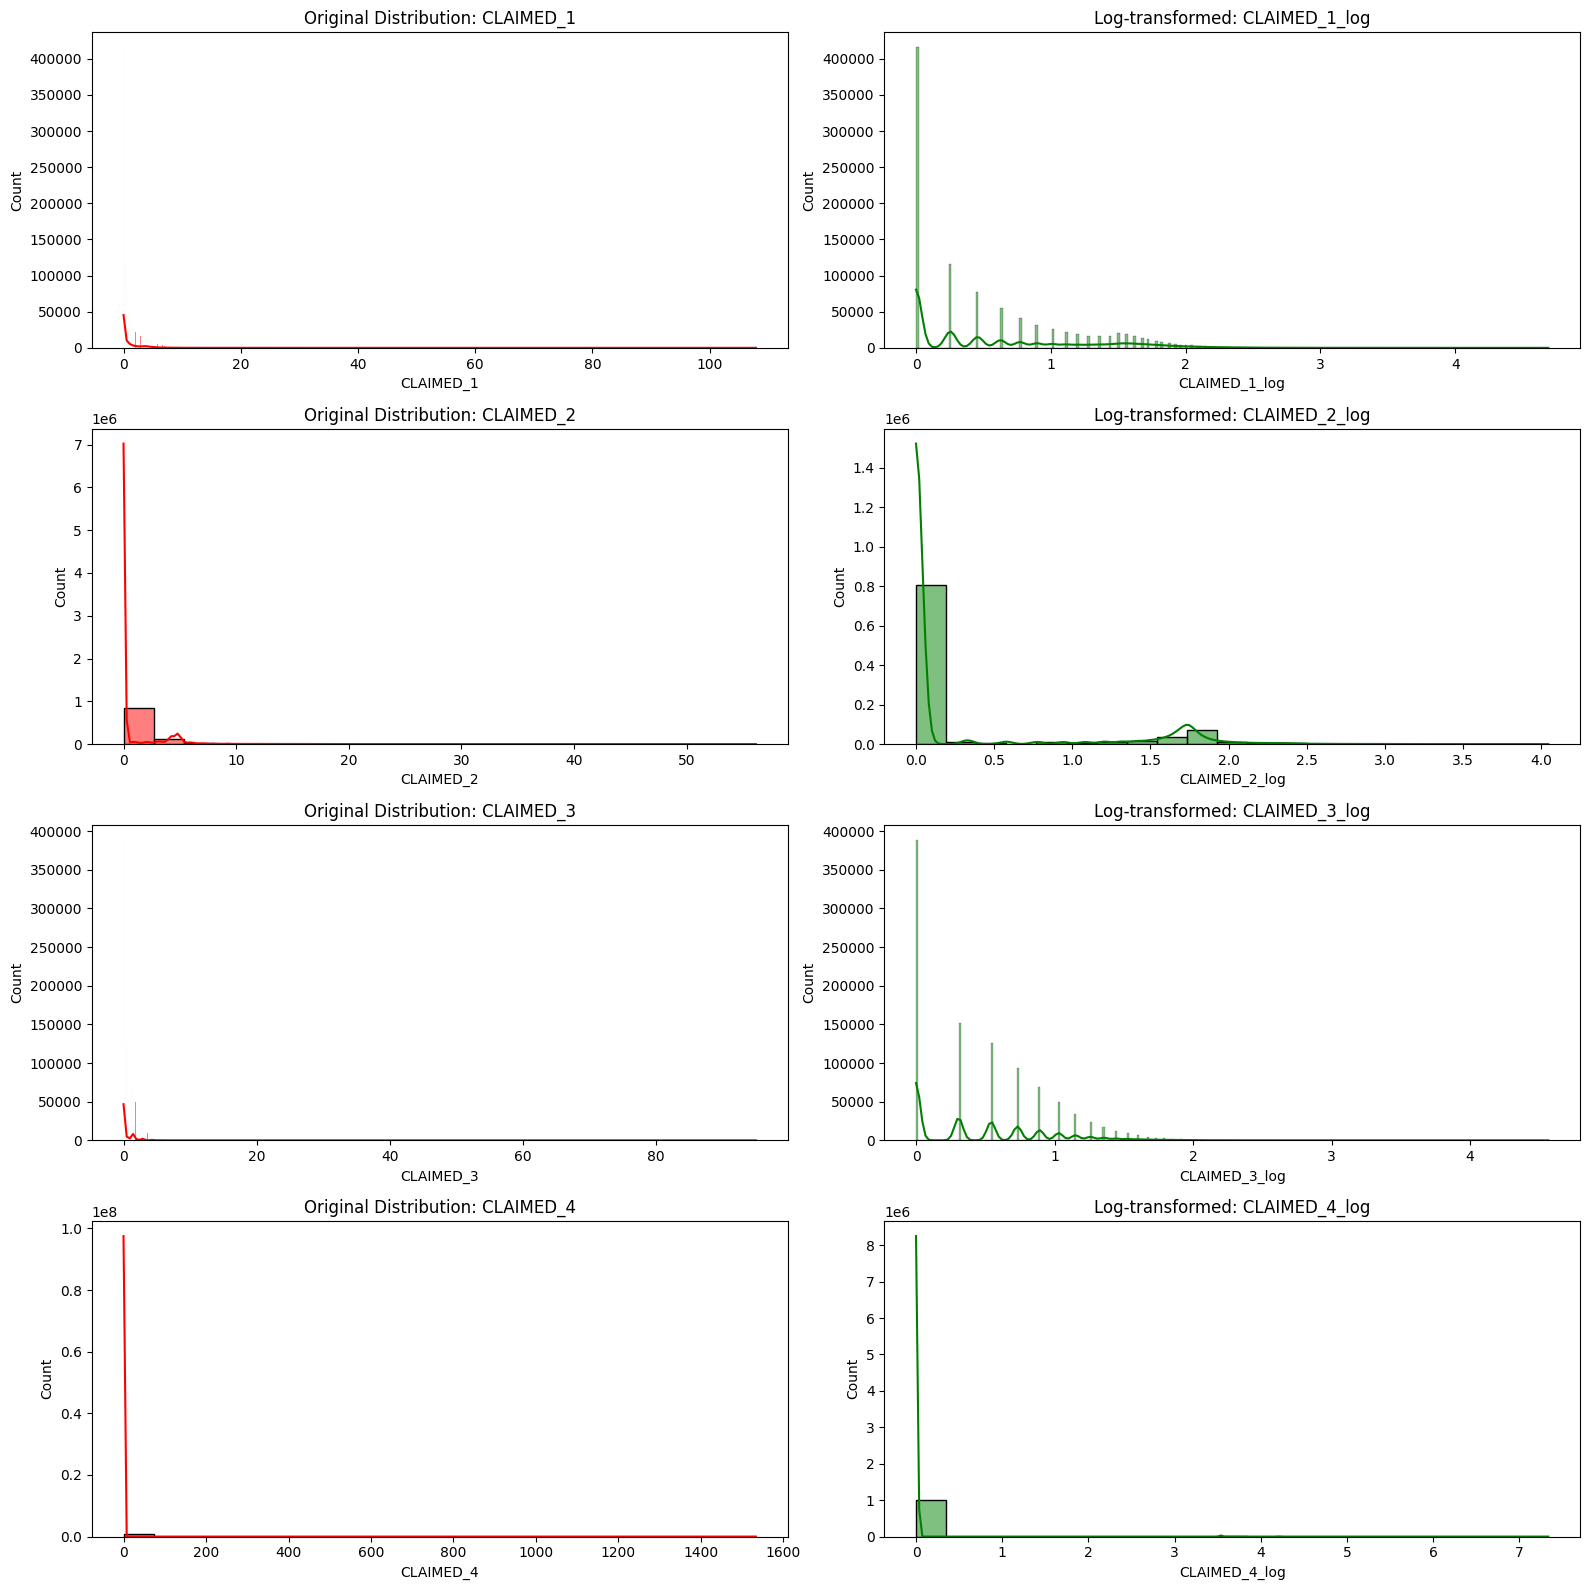

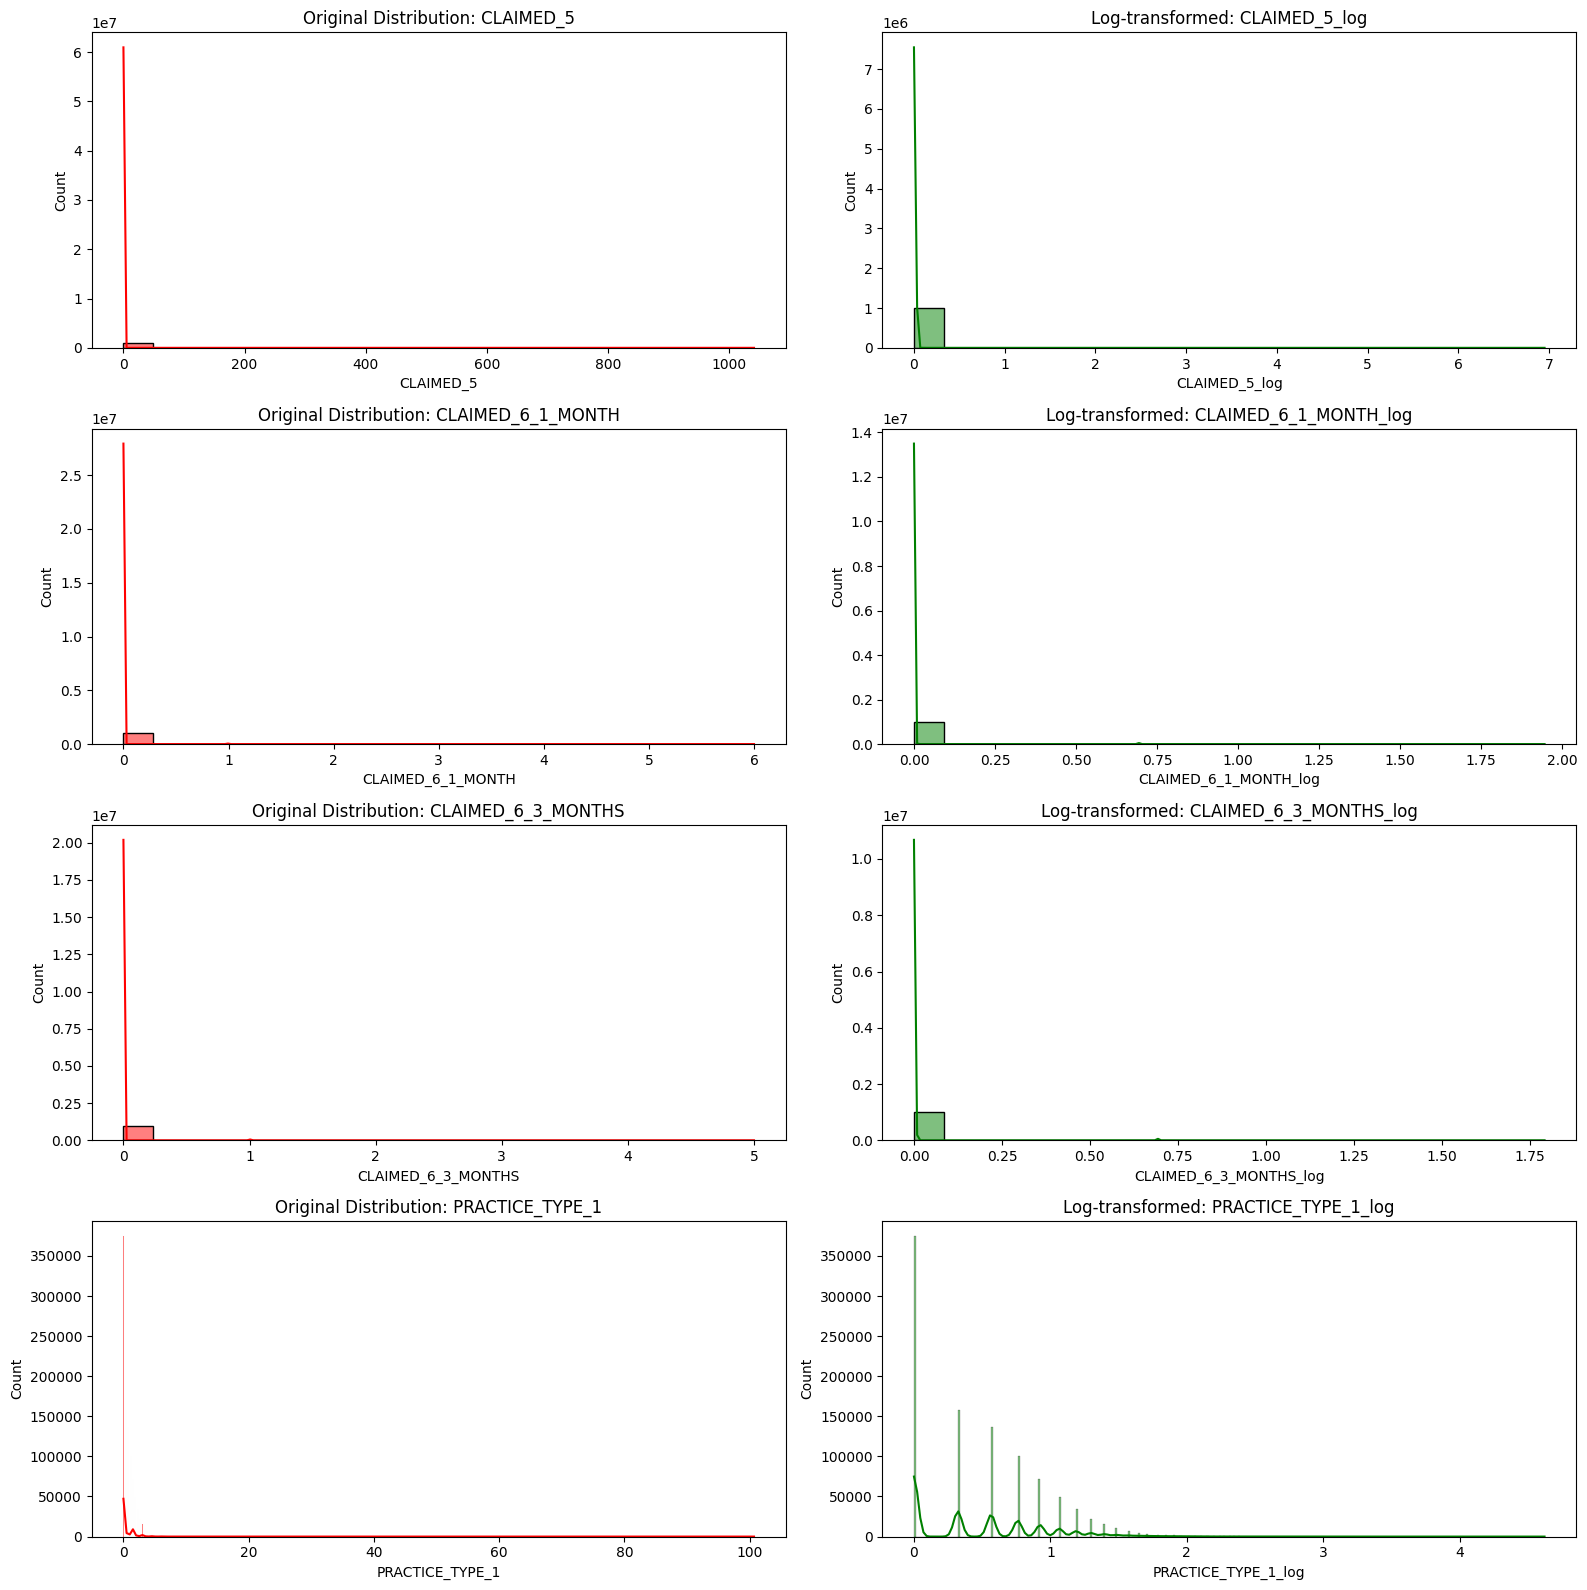

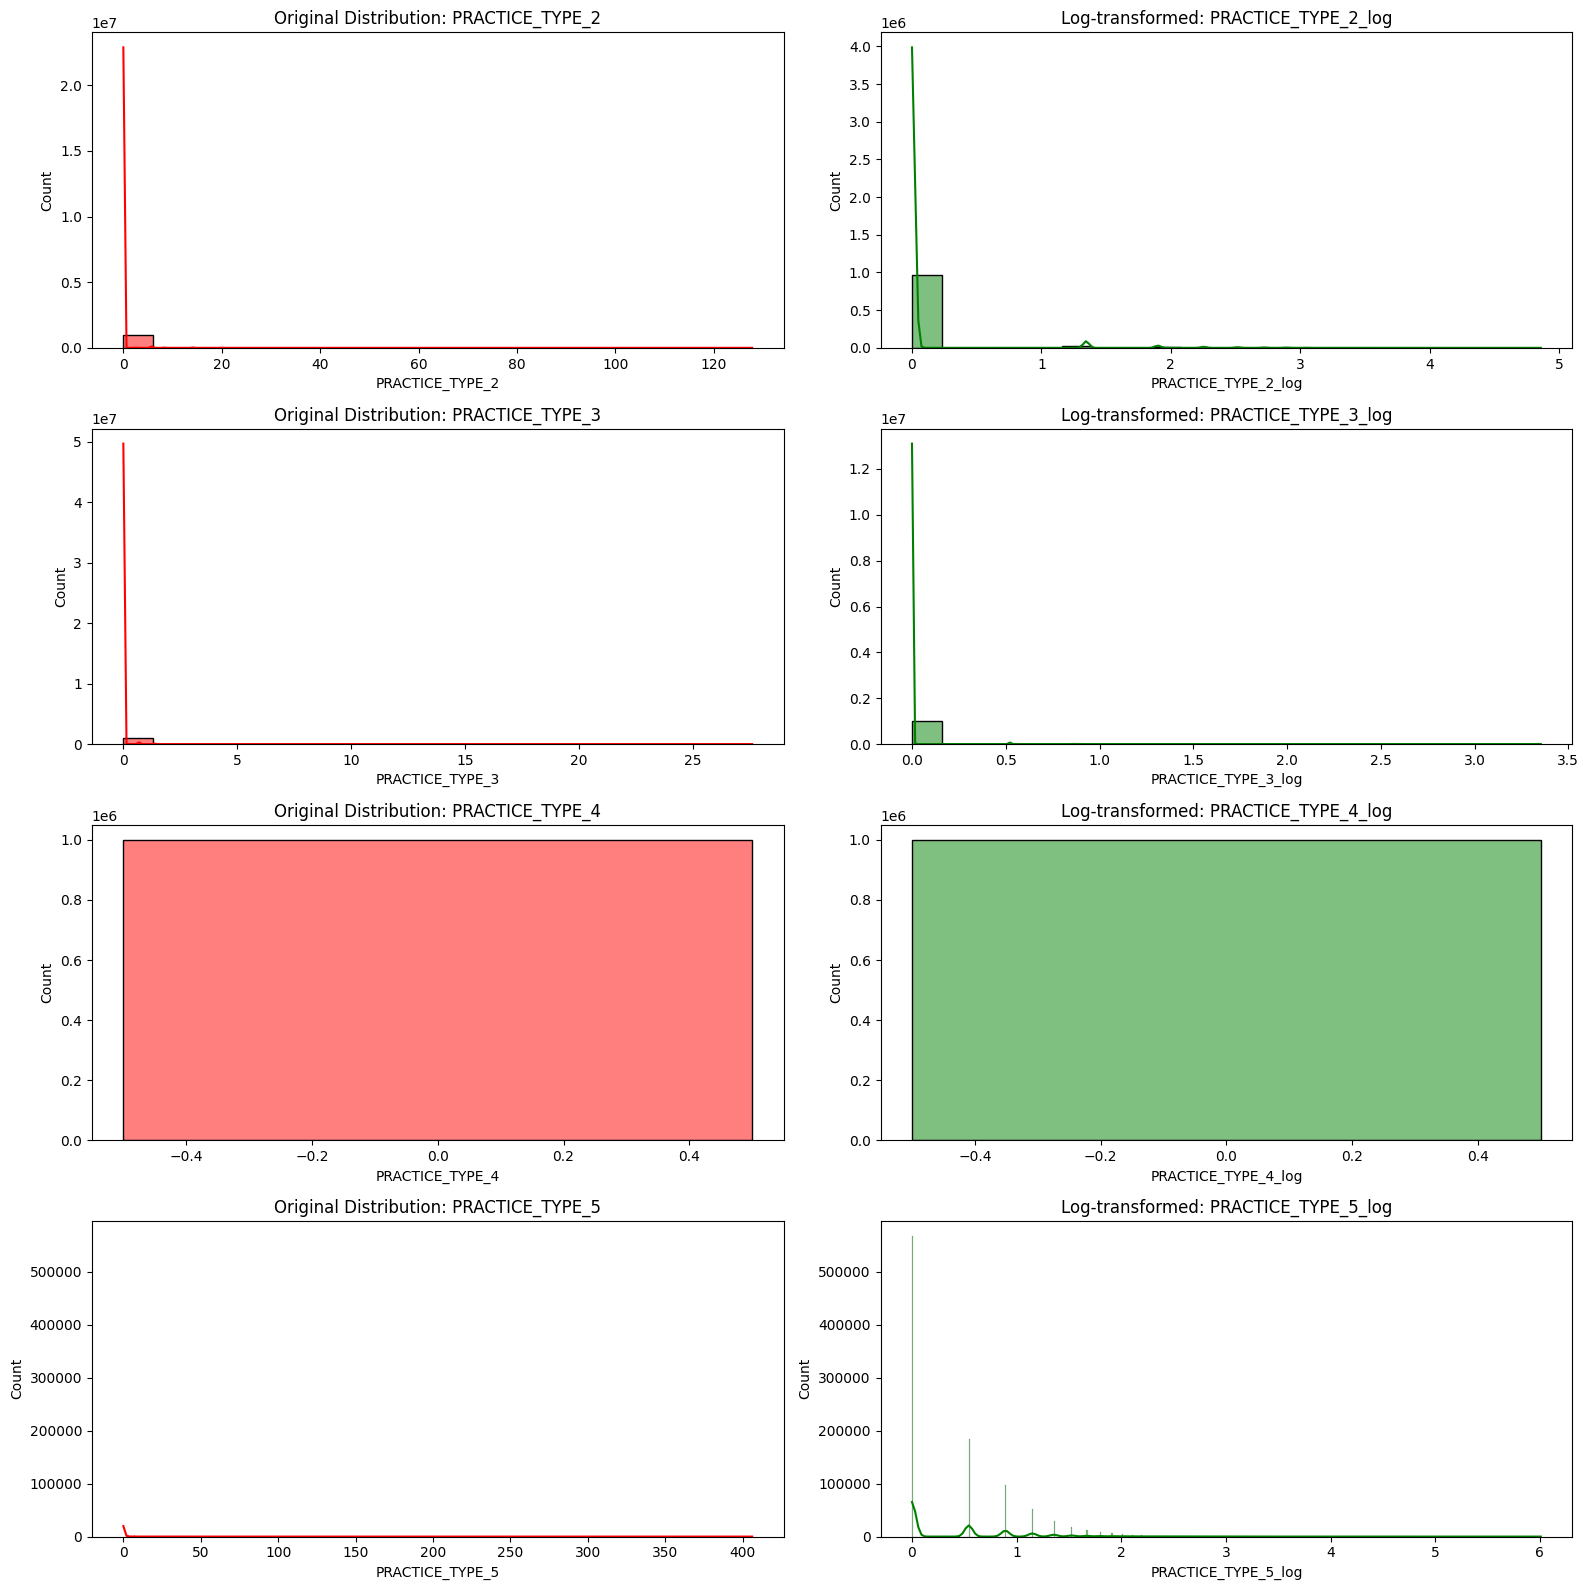

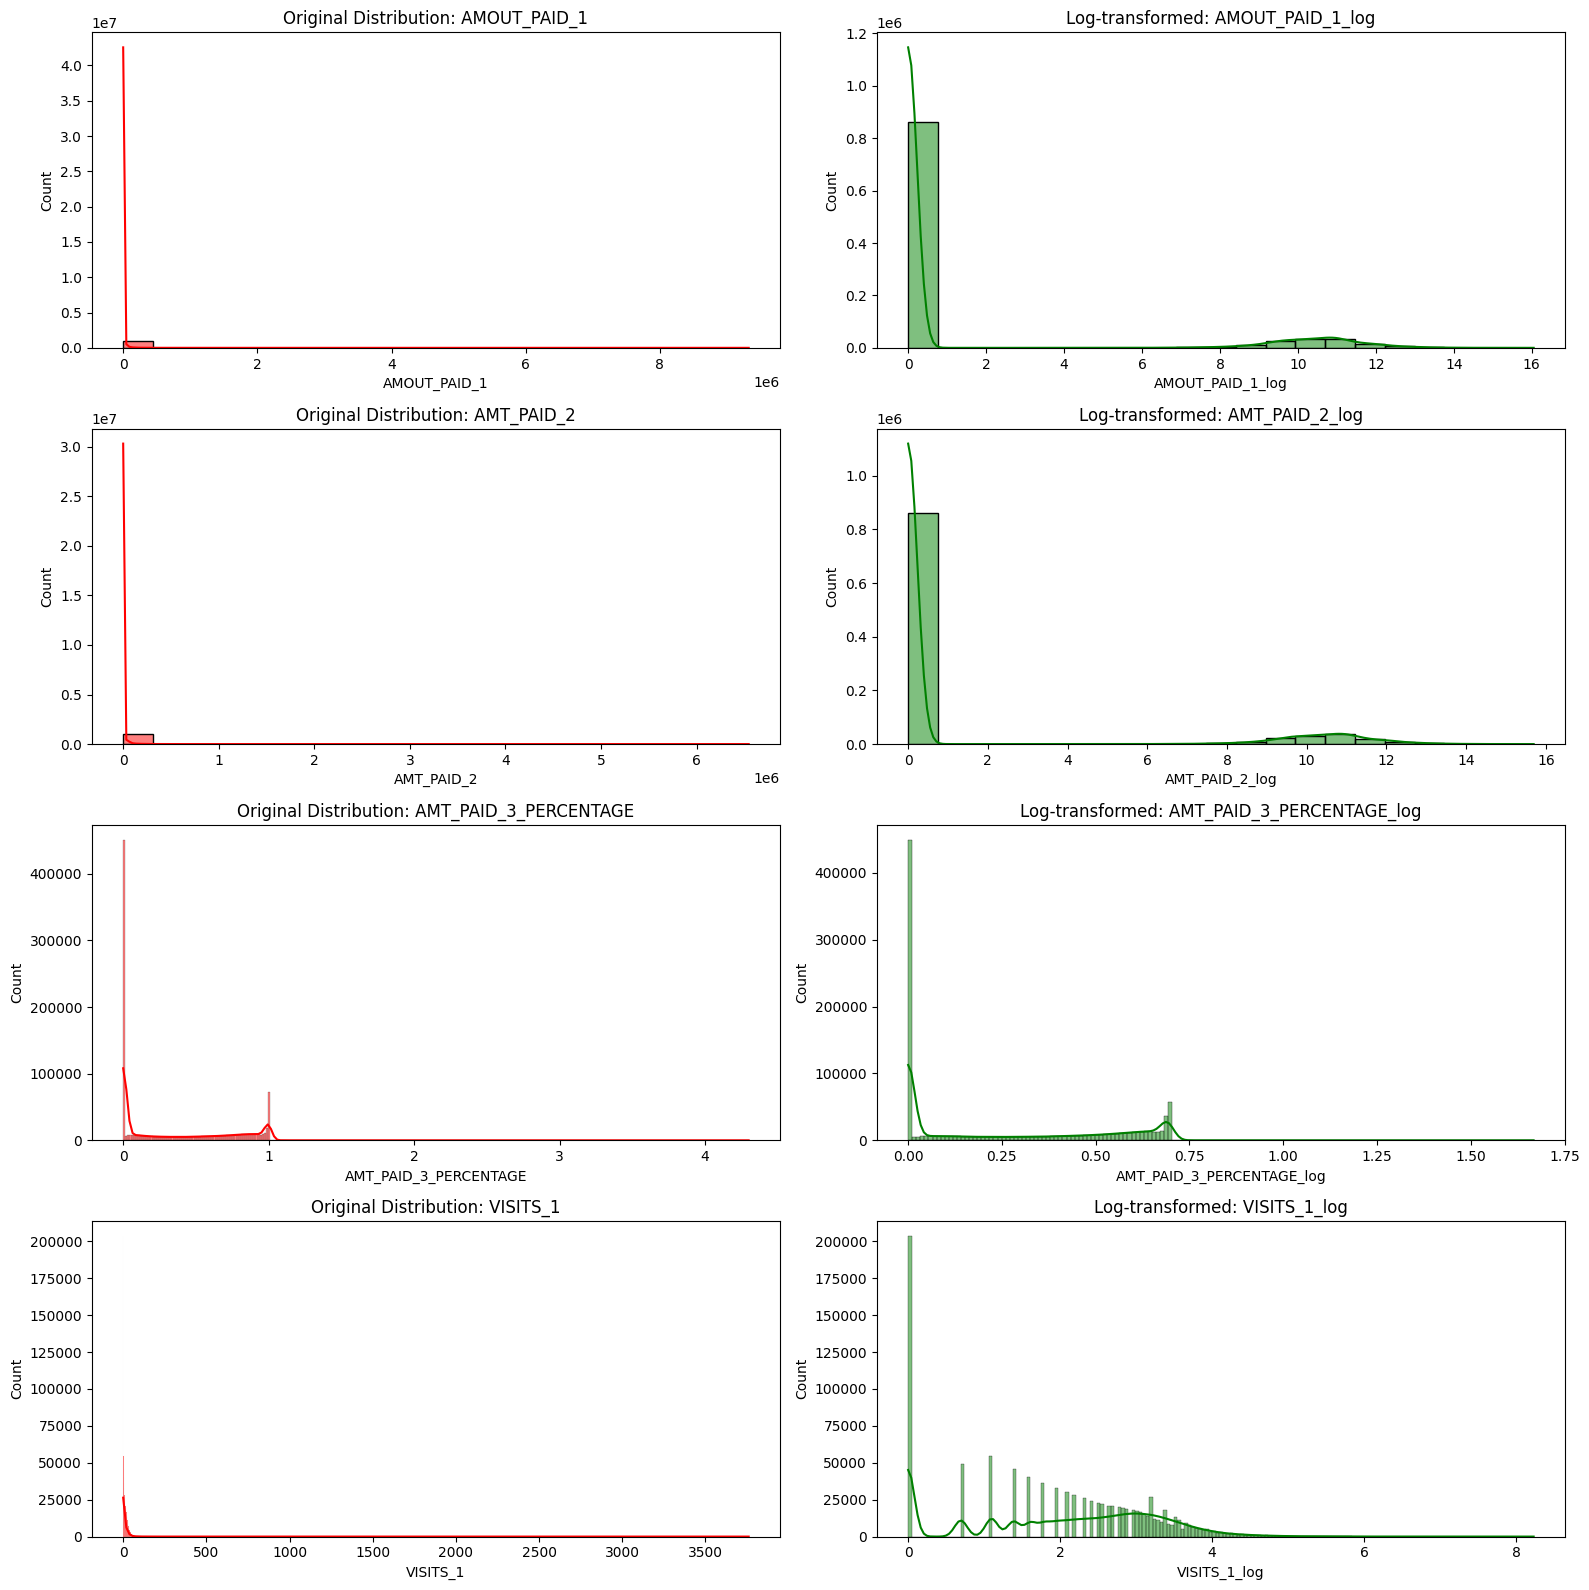

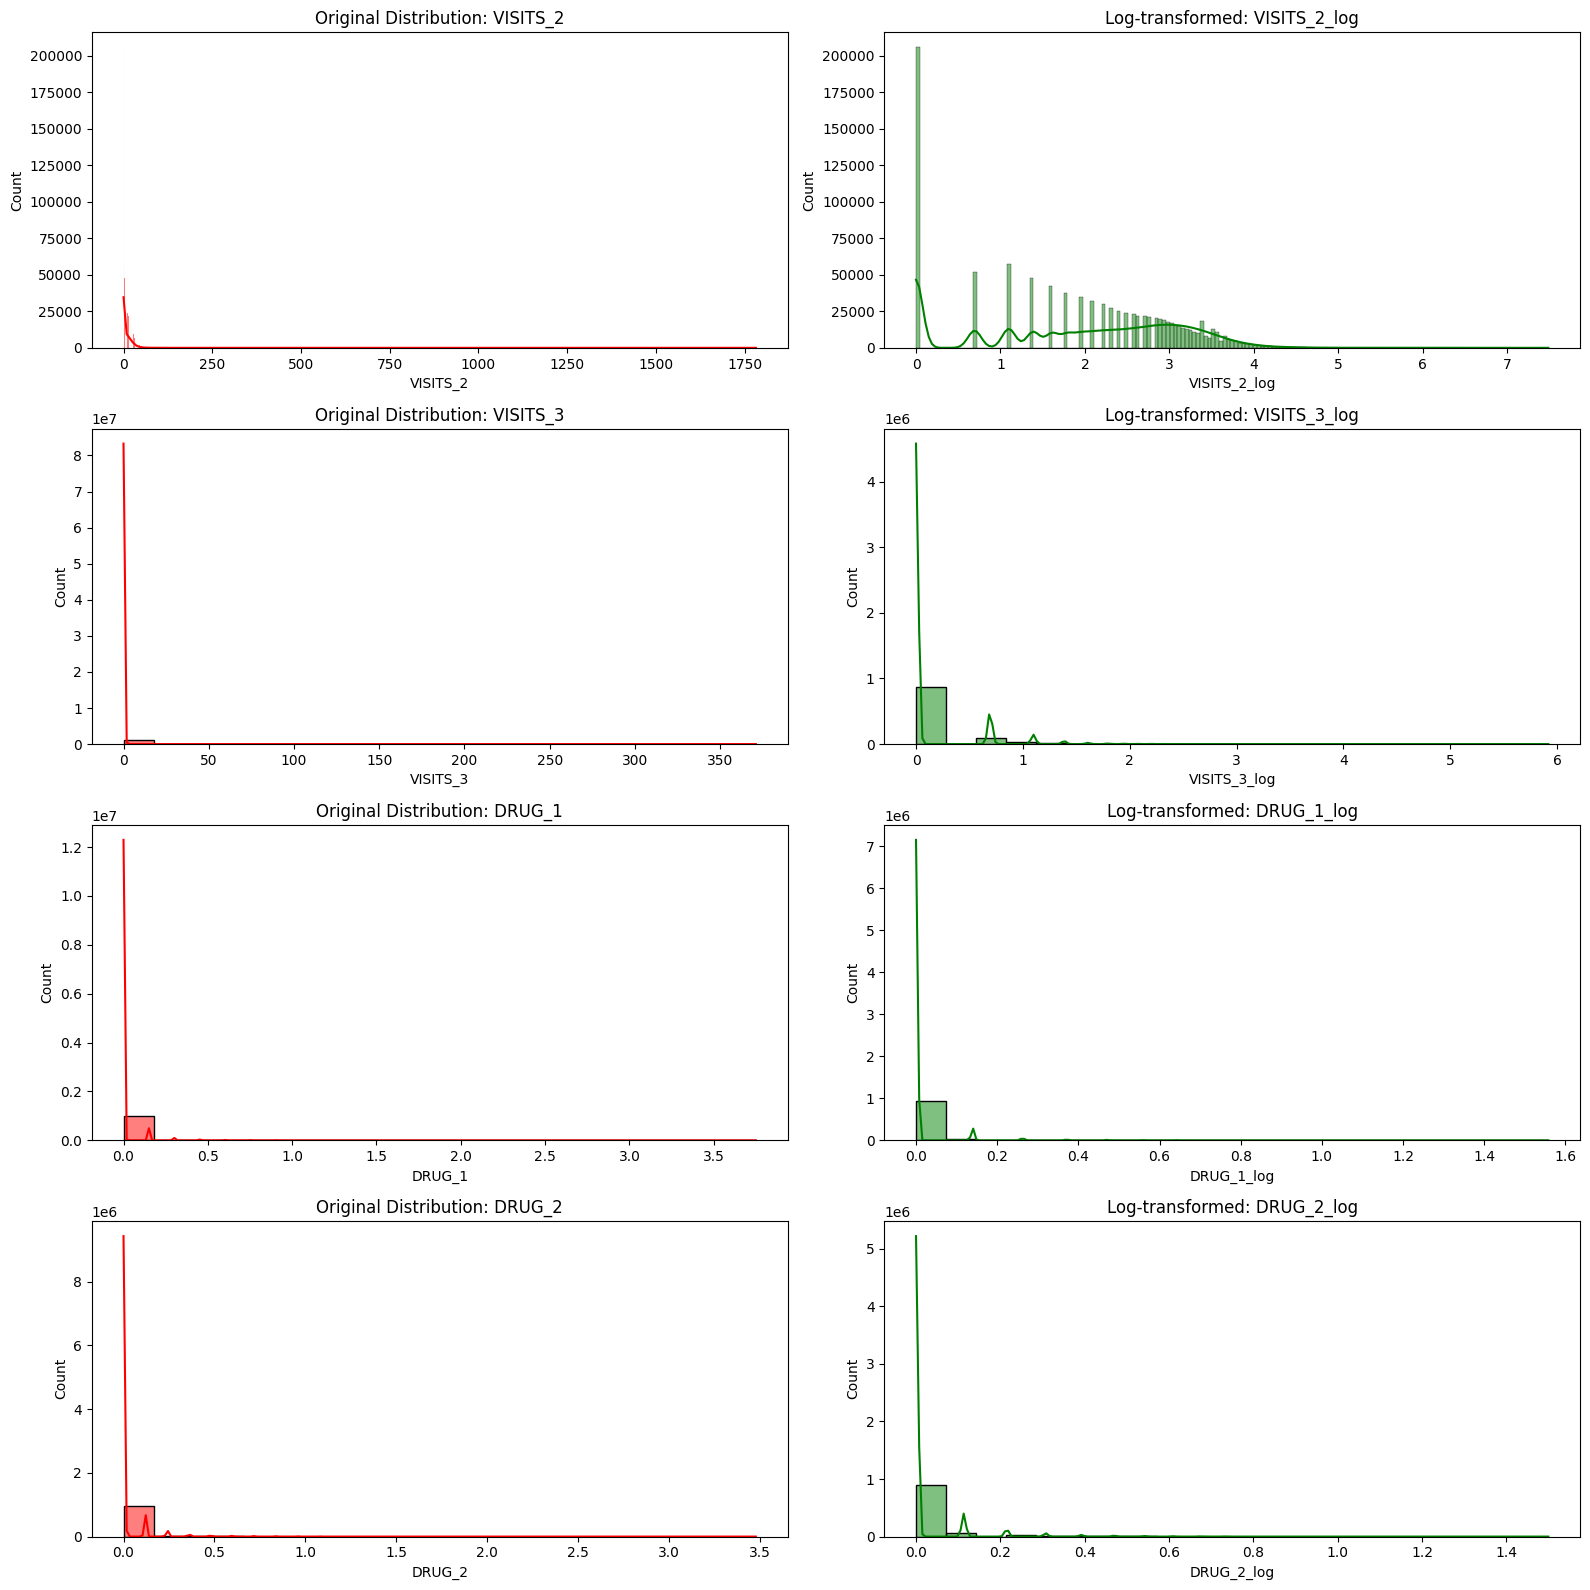

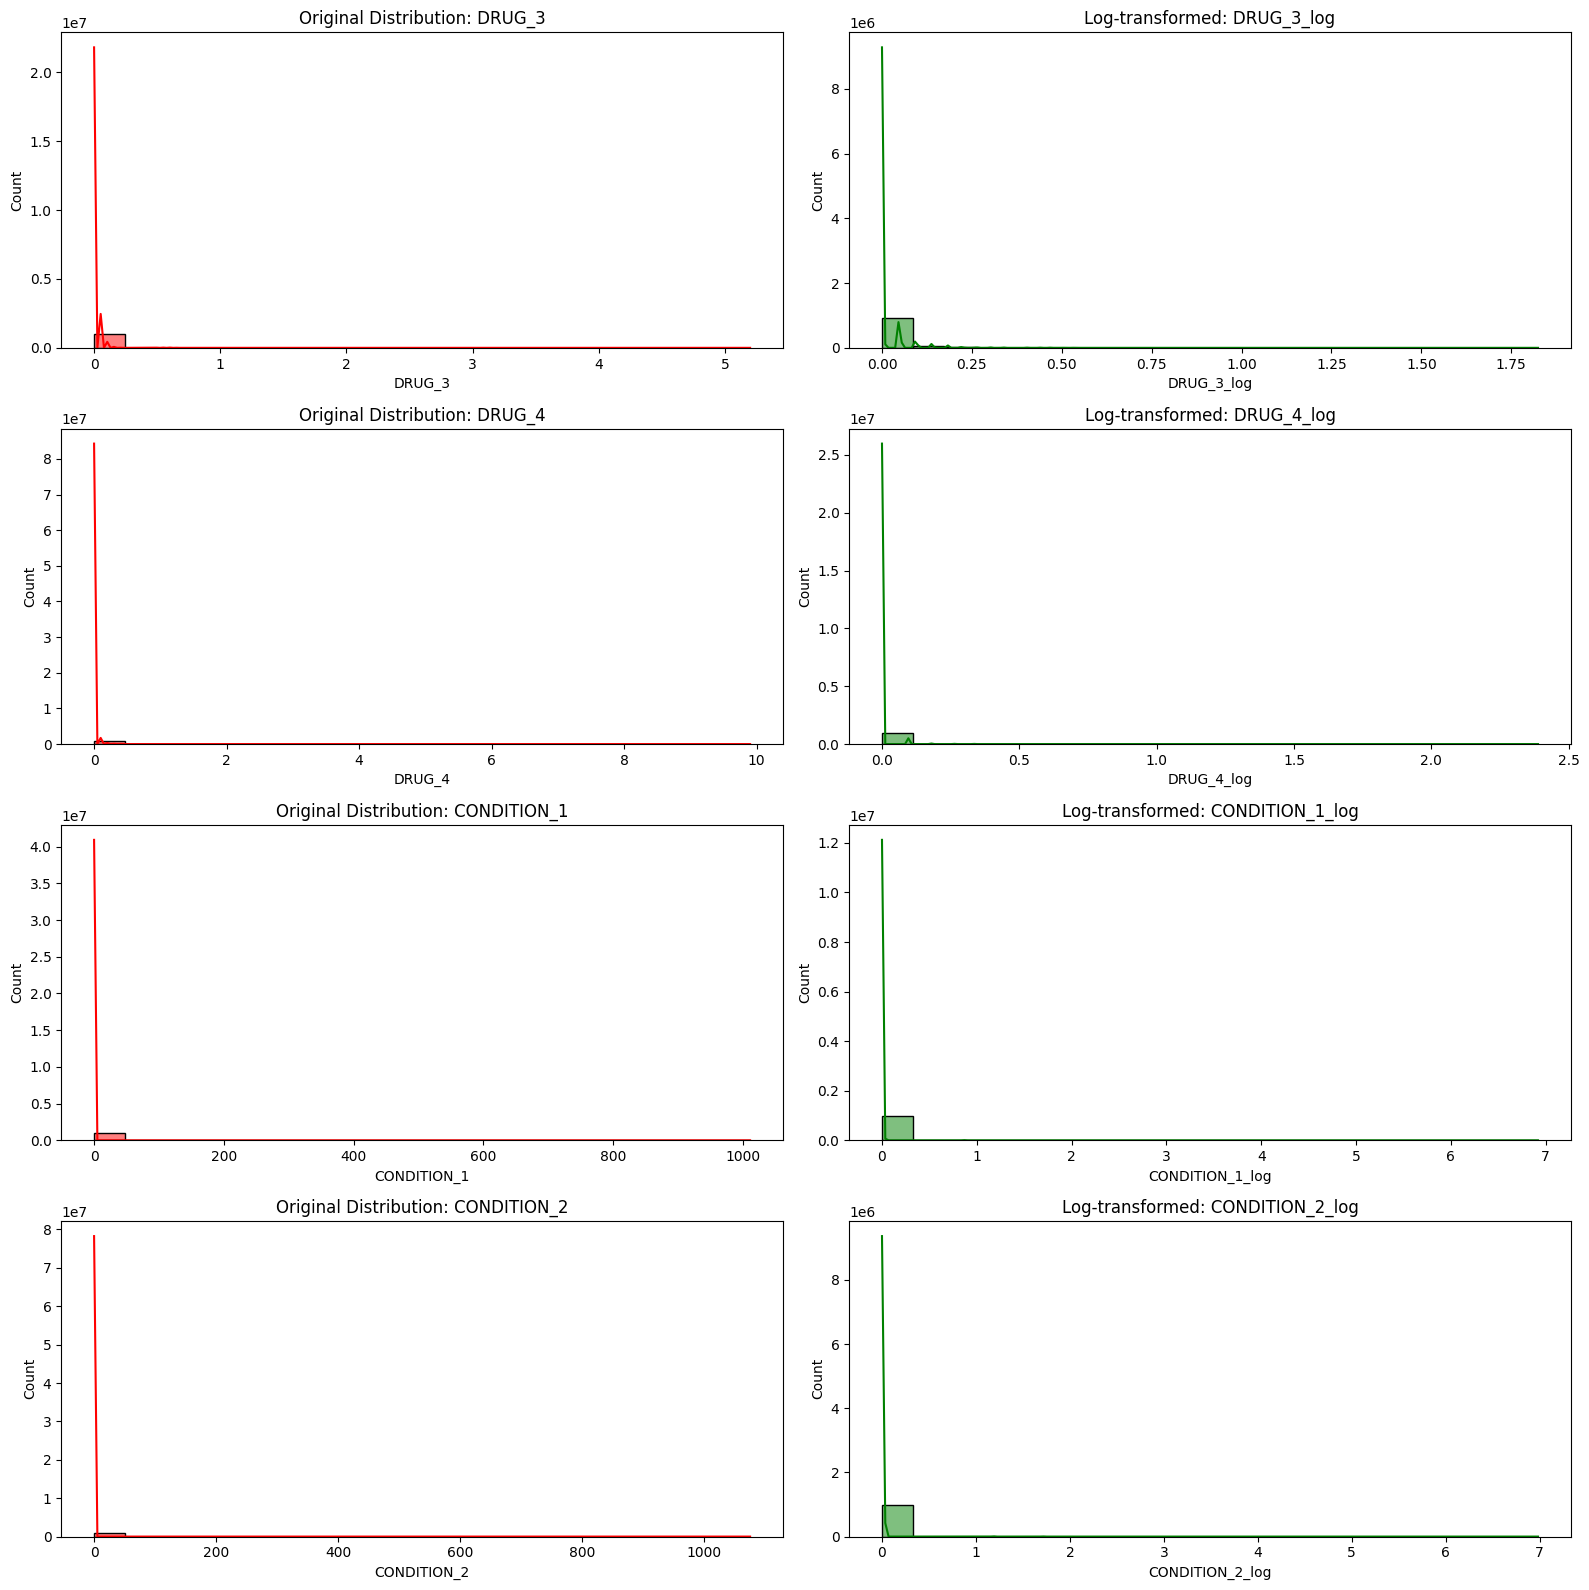

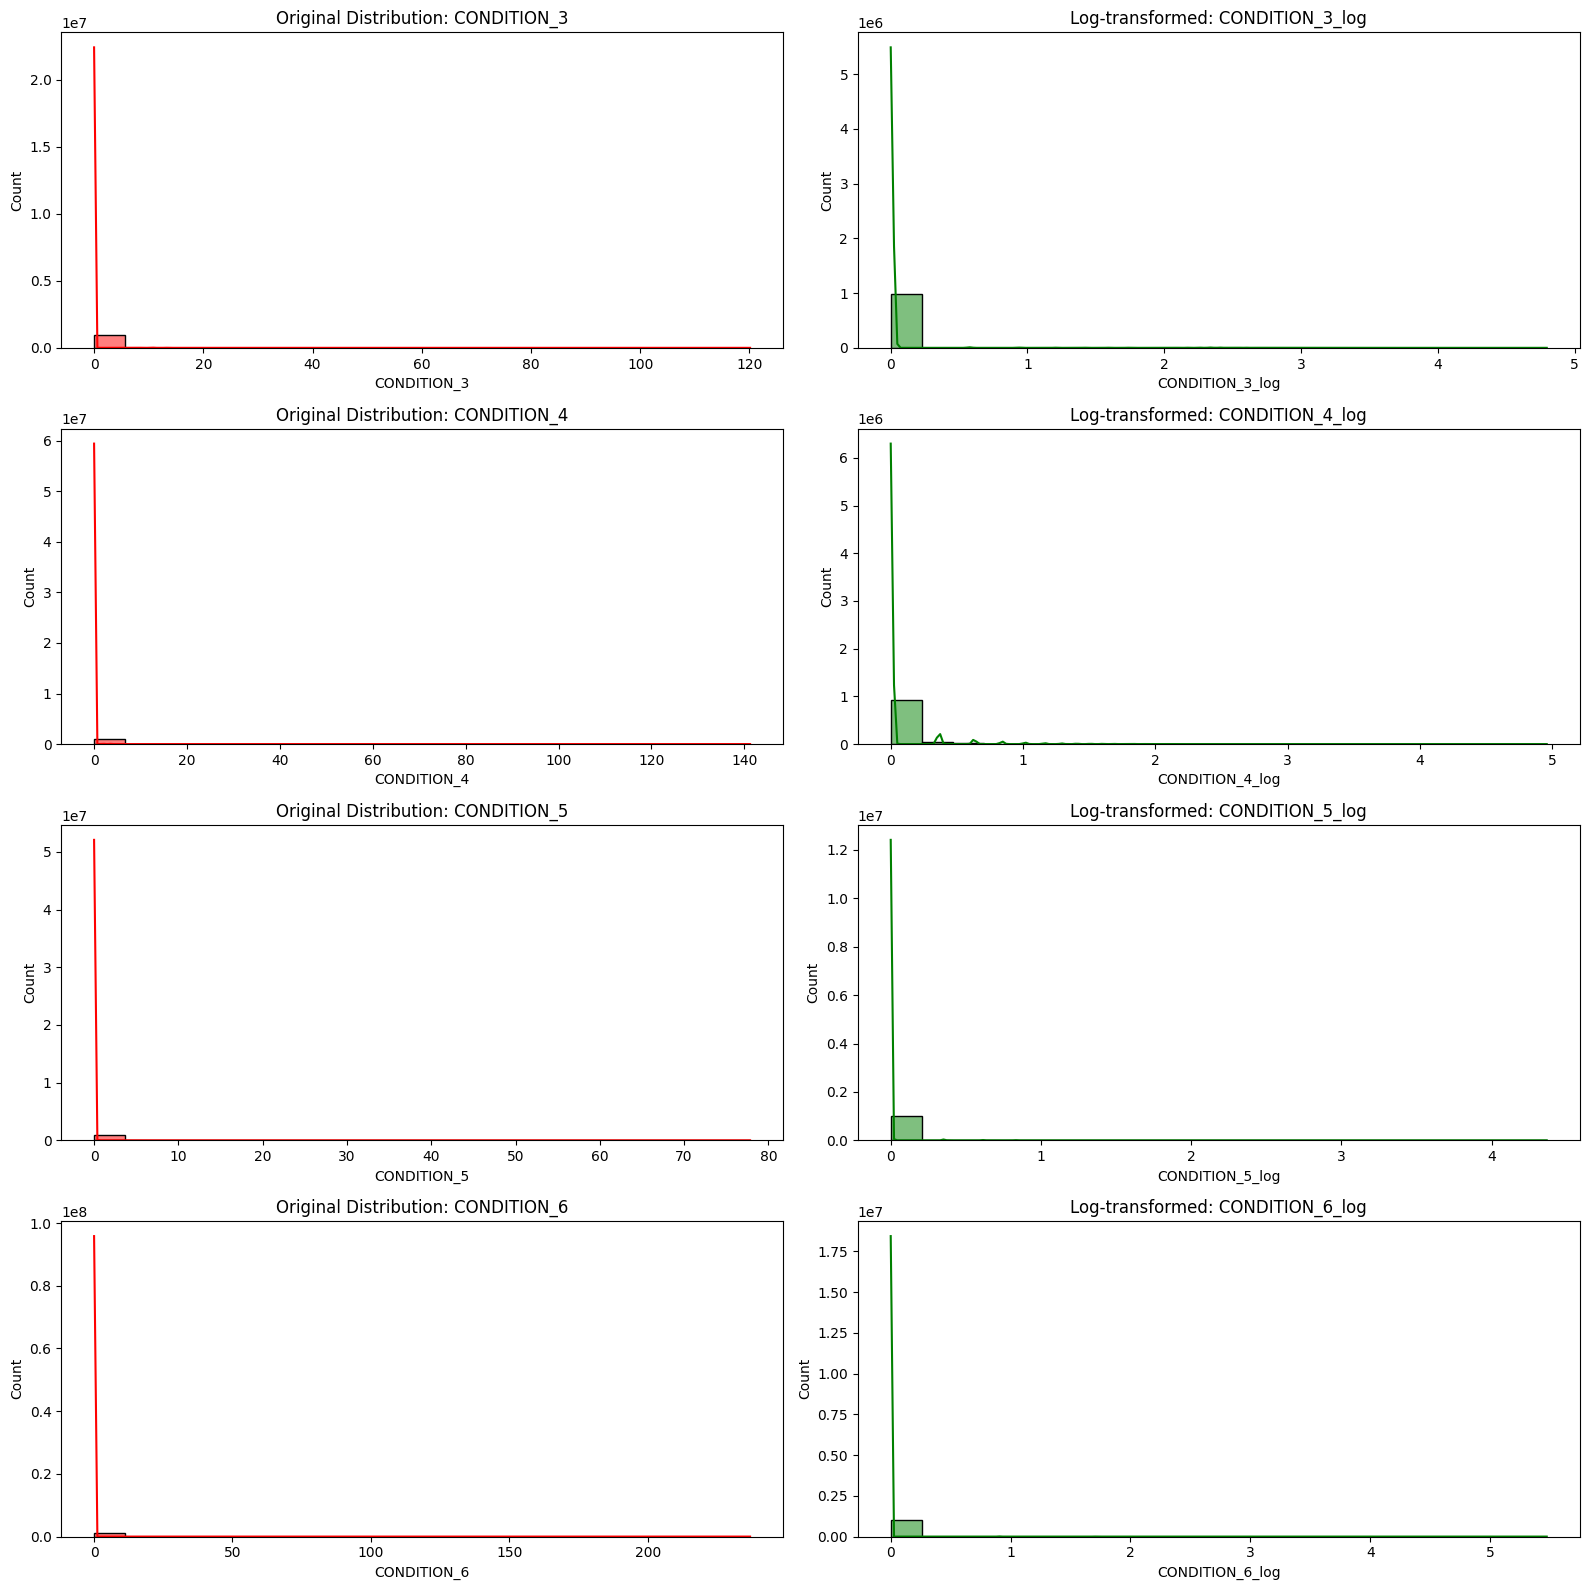

In [11]:
# Visualize histograms for features before and after log transformation
def plot_log_transforms(original_df, log_df, cols, batch_size=4):
    for i in range(0, len(cols), batch_size):
        batch = cols[i:i+batch_size]
        plt.figure(figsize=(16, 4 * len(batch)))
        for j, col in enumerate(batch, 1):
            plt.subplot(len(batch), 2, 2*j - 1)
            sns.histplot(original_df[col], kde=True, color='red')
            plt.title(f'Original Distribution: {col}')

            plt.subplot(len(batch), 2, 2*j)
            sns.histplot(log_df[f'{col}_log'], kde=True, color='green')
            plt.title(f'Log-transformed: {col}_log')
        plt.tight_layout()
        plt.show()

plot_log_transforms(df, log_df, log_cols.tolist())


From the results of the log transformations, we've learned that this technique is highly effective in mitigating the severe positive skewness present in continuous, non-binary features like the 'CLAIMED' features.

While the distributions are not perfectly normal, the log transformation successfully compressed the wide range of values and reduced the disproportionate influence of extreme outliers, bringing the data points closer together.

However, the transformations also reinforced that they are unsuitable for binary or categorical features, as seen with the 'CHRONIC' variables, where their fundamental zero-or-one nature remains unchanged.

Given these adjusted distributions, correlation analysis is the ideal next step because the transformation often linearizes underlying relationships, making Pearson correlation a more reliable and accurate measure of association between variables.

Re-evaluating feature-to-feature and feature-to-target correlations on the transformed data will provide a clearer, more robust understanding of their linear dependencies, which is crucial for refining feature selection and ensuring model stability.

In [13]:
# Renaming the tranformed dataframe back to df, i find easier to work with df.
df = log_df

In [14]:
# check if the are no other entries in the label beside 1 and 0.
df['LABEL'].unique()

array([0, 1])

Pearson correlation is particularly well-suited for this analysis because it directly quantifies the strength and direction of linear relationships between continuous variables. Following the log transformation, the previously skewed distributions of features become more symmetrical, often linearizing their underlying associations.

This preprocessing step makes the Pearson correlation a more reliable and accurate metric, as its sensitivity to extreme outliers in raw, skewed data is mitigated.

Furthermore, the resulting correlation coefficients are easily interpretable, providing a standardized measure that aids in understanding complex feature interactions and their relevance to the target variable, which is crucial for effective multicollinearity assessment and refined feature selection.

In [15]:
# Calculate Pearson correlation matrix
pearson_corr = df.corr(method='pearson')

# Display the full correlation matrix
print(pearson_corr)

                   MEM_NO  CHRONIC_1  CHRONIC_2  CHRONIC_3  CHRONIC_4  \
MEM_NO           1.000000  -0.000189   0.000166   0.000685   0.000043   
CHRONIC_1       -0.000189   1.000000   0.191973   0.021843   0.247692   
CHRONIC_2        0.000166   0.191973   1.000000   0.022441   0.112048   
CHRONIC_3        0.000685   0.021843   0.022441   1.000000   0.020679   
CHRONIC_4        0.000043   0.247692   0.112048   0.020679   1.000000   
...                   ...        ...        ...        ...        ...   
CONDITION_2_log -0.002379   0.010852   0.019734   0.020695   0.014143   
CONDITION_3_log  0.000298   0.007301   0.016636   0.088030   0.007865   
CONDITION_4_log -0.001295   0.031371   0.029367   0.074944   0.016007   
CONDITION_5_log -0.000266   0.014090   0.012392   0.042163   0.024385   
CONDITION_6_log  0.000731   0.011110   0.006696   0.013940   0.010925   

                 CHRONIC_5     VIT_1     VIT_2     VIT_3     VIT_4  ...  \
MEM_NO            0.000763  0.001326  0.000682  

The correlation matrix indicates that most features have very weak linear relationships with each other and with 'MEM_NO', which is a good sign for avoiding strong multicollinearity among predictors. The 'CHRONIC' features show some slight inter-correlations, and some log-transformed features show minor associations with each other or with chronic conditions. The overall low correlation values suggest that after transformation, many features remain largely independent in a linear sense.

In [17]:
# Pearson correlation between LABEL and all other numeric features
label_corr = df.corr(method='pearson')["LABEL"].sort_values(ascending=False)

print(label_corr)


LABEL                        1.000000
VISITS_1                     0.130667
VISITS_3_log                 0.120879
VISITS_2                     0.119897
CLAIMED_3                    0.119207
                               ...   
VIT_2                       -0.003786
AMT_PAID_3_PERCENTAGE       -0.022821
AMT_PAID_3_PERCENTAGE_log   -0.024147
PRACTICE_TYPE_4                   NaN
PRACTICE_TYPE_4_log               NaN
Name: LABEL, Length: 89, dtype: float64


From the Pearson correlation matrix with the 'LABEL' (hospital admission), we can identify features that show the strongest linear associations with our target variable, even before implementing any predictive models.

The analysis indicates that 'VISITS_1', 'VISITS_2', 'CLAIMED_3', 'CLAIMED_1', and 'PRACTICE_TYPE_5' are the most promising initial predictors, exhibiting the highest positive correlations with 'LABEL', ranging from approximately 0.11 to 0.13. This suggests that higher counts of visits, claims, or specific practice types are linearly associated with an increased likelihood of hospital admission.

Other features like 'AMT_PAID_2', 'AMOUT_PAID_1', 'VIT_8', and 'DRUG_3' also show positive correlations, albeit slightly weaker. Conversely, 'MEM_NO' and several 'VIT' features (e.g., 'VIT_4', 'VIT_3') exhibit negligible or very weak negative correlations, implying minimal linear predictive power.

Importantly, while these correlations highlight potential influences, their relatively low magnitudes (with the strongest being only 0.13) indicate that no single feature is a dominant linear predictor.

This implies that the problem of predicting hospital admission is likely complex and will require a comprehensive approach involving multiple features, potentially capturing non-linear relationships, and careful model selection to achieve effective prediction.

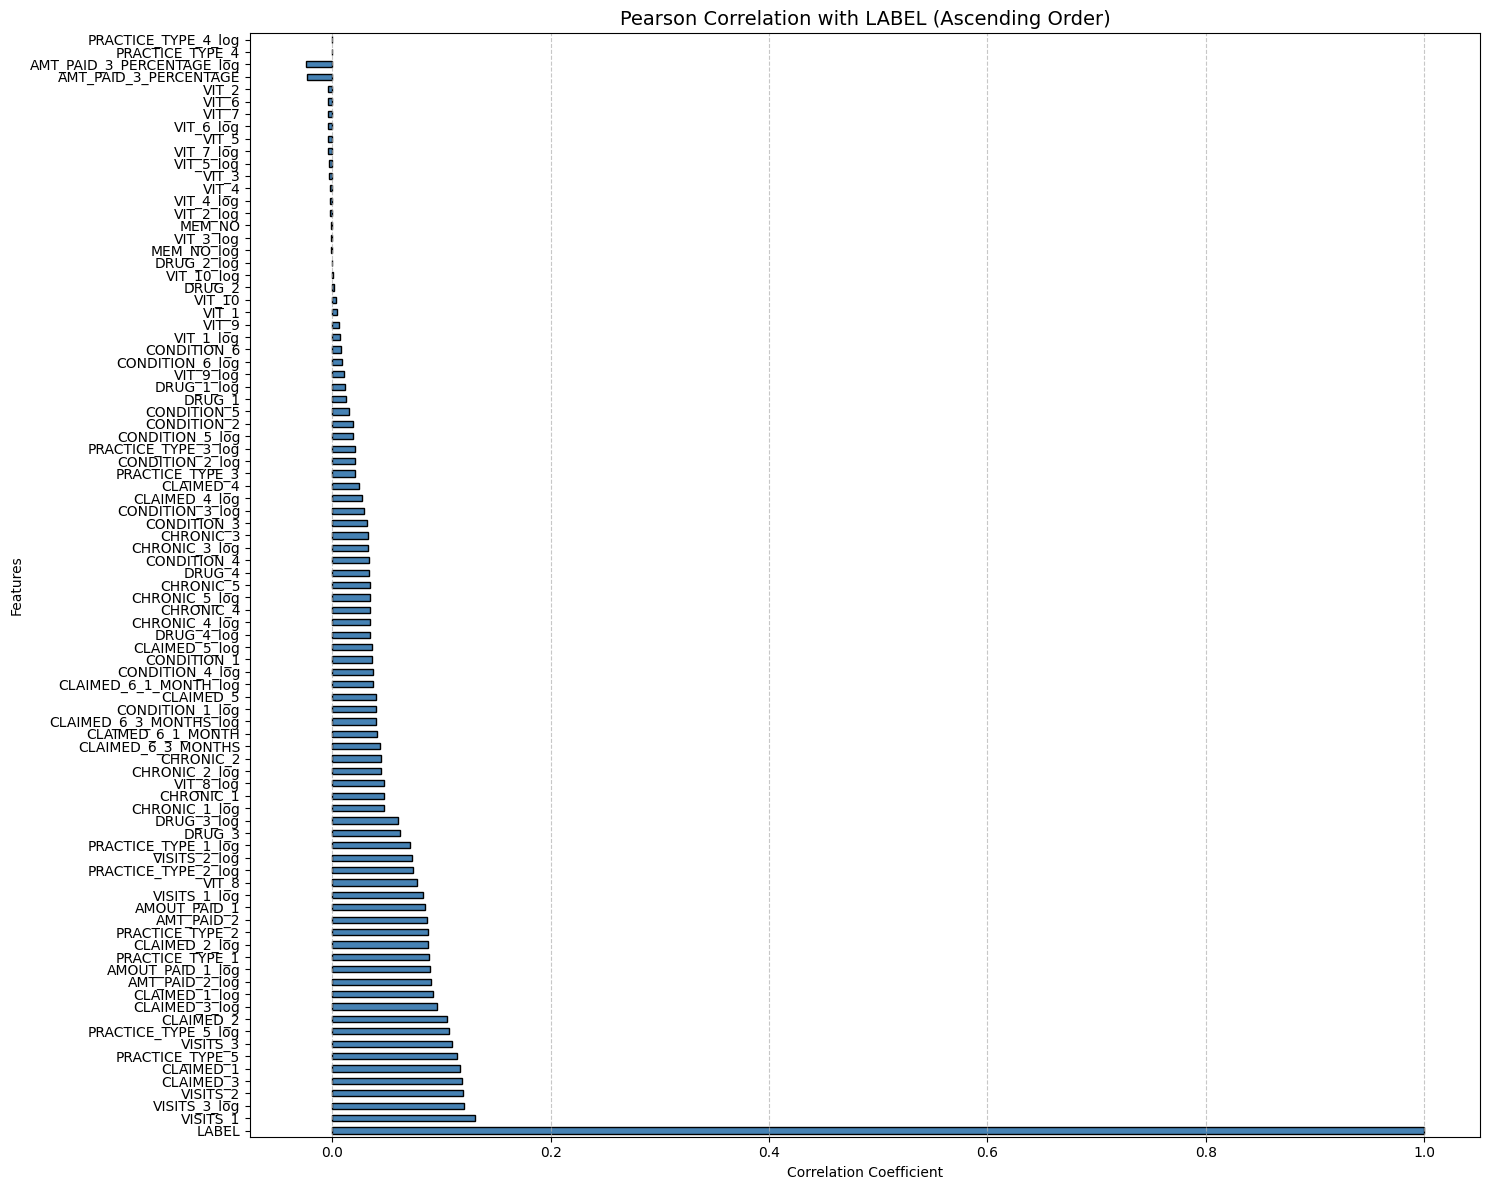

In [22]:
# Plotting the  pesrson correlation in ascending order
plt.figure(figsize=(15, 12))
label_corr.plot(kind='barh', color='steelblue', edgecolor ='black')
plt.title("Pearson Correlation with LABEL (Ascending Order)", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.xticks(rotation = 0)
plt.grid(axis='x', linestyle='--', alpha= 0.7)
plt.tight_layout()
plt.show()

In [23]:
# Check why the feature PRACTICE_TYPE_4 has nan correlation with the label feature.
df['PRACTICE_TYPE_4'].unique()

array([0.])

PRACTICE_TYPE_4 offers no predictive value as it has zero variance (all members have the same value, 0.). Consequently, its Pearson correlation with LABEL is NaN because there's no variability to assess a relationship. The next crucial step is to drop PRACTICE_TYPE_4 from the DataFrame, as it provides no information and could hinder model performance.

In [24]:
# Dropping the ['PRACTICE_TYPE_4'] since it only containes one value i.e. 0
df = df.drop(columns = ['PRACTICE_TYPE_4'])

In [25]:
# Check the dataframe after dropping the ['PRACTICE_TYPE_4']feature
df.head()

MEM_NO  CHRONIC_1  CHRONIC_2  CHRONIC_3  CHRONIC_4  CHRONIC_5  VIT_1  \
0  71310082871          0          0          0          0          0      0   
1   2533699753          0          0          0          0          0      0   
2  36867130860          0          0          0          0          0      0   
3   2409570821          0          0          0          0          0      0   
4   3337711172          0          0          0          0          0      0   

   VIT_2  VIT_3  VIT_4  ...  DRUG_1_log  DRUG_2_log  DRUG_3_log  DRUG_4_log  \
0      0      0      7  ...    0.000000         0.0     0.04879         0.0   
1      0      0      7  ...    0.000000         0.0     0.00000         0.0   
2      0      0      7  ...    0.262364         0.0     0.00000         0.0   
3      0      0      7  ...    0.000000         0.0     0.04879         0.0   
4      0      0      7  ...    0.000000         0.0     0.00000         0.0   

   CONDITION_1_log  CONDITION_2_log  CONDITION_3_log  CONDITION_4_log  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   CONDITION_5_log  CONDITION_6_log  
0              0.0              0.0  
1              0.0              0.0  
2              0.0              0.0  
3              0.0              0.0  
4              0.0              0.0  

[5 rows x 88 columns]

## Feature selction

Given that most features exhibit relatively low Pearson correlations with the 'LABEL' (hospital admission), suggesting that individual features may not possess significant standalone predictive power, it becomes crucial to reconsider our approach to feature selection.

Instead of strictly adhering to a higher correlation threshold like 0.1, we will strategically lower it to 0.05. This adjusted threshold is designed to capture a broader array of potentially influential underlying features, even those with weaker linear associations, which might collectively contribute to a robust predictive model.

In healthcare data, where complex interactions and subtle indicators can be vital for identifying critical outcomes like hospital admissions, a more inclusive threshold can help ensure that no valuable information is prematurely discarded, even if its individual impact appears marginal.

In [26]:
# Calculate Pearson correlation with LABEL
corr_with_label = df.corr()["LABEL"].drop("LABEL")

# Take absolute values and filter by threshold
threshold = 0.05 
selected_features = corr_with_label[abs(corr_with_label) >= threshold].sort_values(key=abs, ascending=False)

# Display selected features
print("Selected features with absolute correlation above", threshold)
print(selected_features)


Selected features with absolute correlation above 0.05
VISITS_1               0.130667
VISITS_3_log           0.120879
VISITS_2               0.119897
CLAIMED_3              0.119207
CLAIMED_1              0.116996
PRACTICE_TYPE_5        0.114400
VISITS_3               0.109740
PRACTICE_TYPE_5_log    0.107203
CLAIMED_2              0.105434
CLAIMED_3_log          0.096093
CLAIMED_1_log          0.091866
AMT_PAID_2_log         0.090522
AMOUT_PAID_1_log       0.089718
PRACTICE_TYPE_1        0.088519
CLAIMED_2_log          0.087302
PRACTICE_TYPE_2        0.087256
AMT_PAID_2             0.086973
AMOUT_PAID_1           0.085020
VISITS_1_log           0.083087
VIT_8                  0.077589
PRACTICE_TYPE_2_log    0.073573
VISITS_2_log           0.073032
PRACTICE_TYPE_1_log    0.071154
DRUG_3                 0.062365
DRUG_3_log             0.060212
Name: LABEL, dtype: float64


By lowering our correlation threshold to 0.05, we have successfully identified a more extensive list of features with potential predictive power for hospital admission.

This expanded set now includes not only the original 'VISITS' and 'CLAIMED' features that previously showed stronger correlations, but also their log-transformed counterparts, as well as features like 'PRACTICE_TYPE_5', 'PRACTICE_TYPE_1', 'PRACTICE_TYPE_2', 'AMT_PAID_2', 'AMOUT_PAID_1', 'VIT_8', and 'DRUG_3', along with their log transformations where applicable.

The presence of both original and log-transformed versions of some features in this list (e.g., 'VISITS_3' and 'VISITS_3_log') suggests that while transformation may have improved linearity, the original scale still holds some correlative value.

This broader inclusion, particularly for features with correlations between 0.05 and 0.1, is critical for healthcare data where subtle signals can be important, allowing us to leverage a wider array of information in our model building.

We check for multicollinearity to ensure the stability, interpretability, and efficiency of our predictive models. High multicollinearity, where independent variables are highly correlated with each other, can destabilize model coefficients, making them unreliable and difficult to interpret as their individual effects become indistinguishable.

This redundancy can also lead to overfitting in some cases and unnecessary computational load. By identifying and addressing multicollinearity, typically by removing one of the highly correlated features while retaining the one with stronger relevance to the target, we simplify the model and potentially improve its generalization capabilities, especially crucial before training models that are sensitive to feature independence.

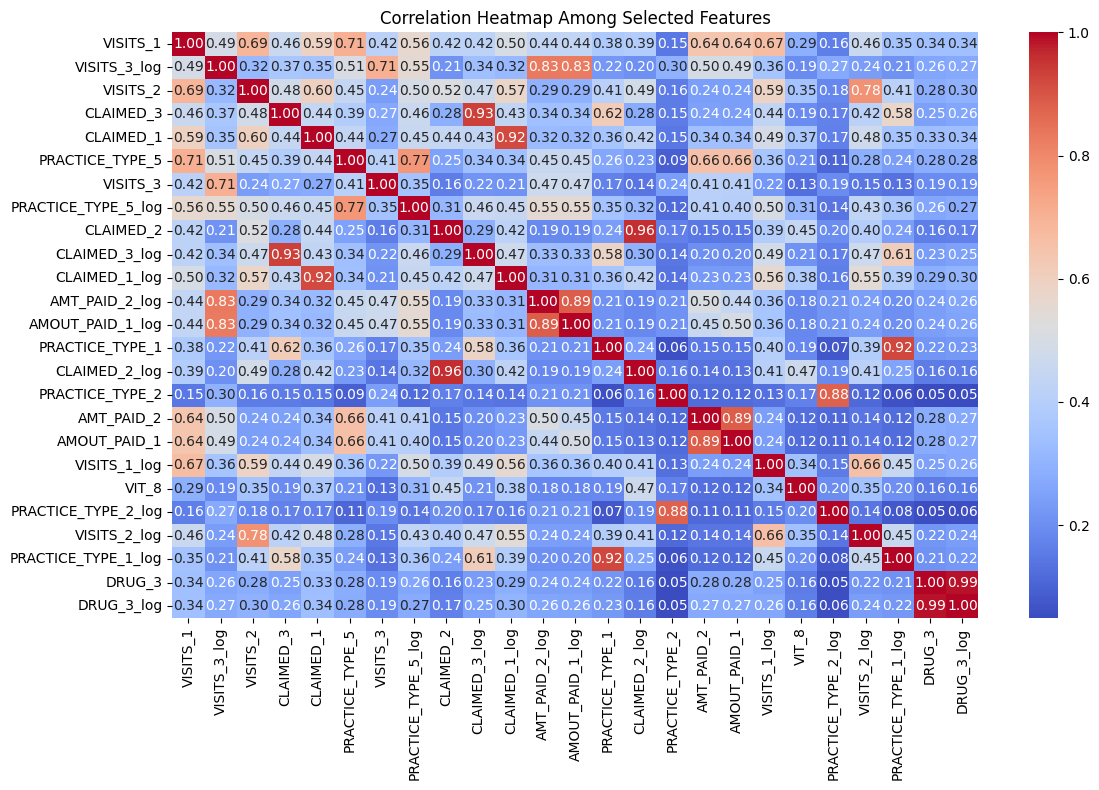

In [27]:
# List of selected features
selected_features = [
    'VISITS_1','VISITS_3_log', 'VISITS_2', 'CLAIMED_3', 'CLAIMED_1', 'PRACTICE_TYPE_5', 'VISITS_3','PRACTICE_TYPE_5_log',
    'CLAIMED_2', 'CLAIMED_3_log', 'CLAIMED_1_log','AMT_PAID_2_log','AMOUT_PAID_1_log','PRACTICE_TYPE_1','CLAIMED_2_log',
    'PRACTICE_TYPE_2','AMT_PAID_2','AMOUT_PAID_1','VISITS_1_log','VIT_8','PRACTICE_TYPE_2_log',
    'VISITS_2_log', 'PRACTICE_TYPE_1_log','DRUG_3', 'DRUG_3_log'
]

# Correlation matrix
corr_matrix = df[selected_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Among Selected Features")
plt.tight_layout()
plt.show()


Key Observations and Interpretation:

High Intra-Family Correlations: As expected, there are very high correlations (close to 1.0) between the original features and their log-transformed counterparts. For instance, VISITS_1 and VISITS_1_log are highly correlated, as are CLAIMED_1 and CLAIMED_1_log, AMT_PAID_2 and AMT_PAID_2_log, and DRUG_3 and DRUG_3_log.

This is a direct result of the log transformation, which preserves the monotonic relationship. Similarly, AMT_PAID_2 and AMOUT_PAID_1, along with their log-transformed versions, show high correlations, indicating redundancy between total amounts paid.

Strong Correlations within 'VISITS' and 'CLAIMED' groups:
VISITS_1 is strongly correlated with VISITS_2 (0.69) and PRACTICE_TYPE_5 (0.71). Its log-transformed version, VISITS_1_log, also shows strong correlations with VISITS_2_log (0.73) and PRACTICE_TYPE_5_log (0.75).

CLAIMED_3 is highly correlated with PRACTICE_TYPE_1 (0.62).
CLAIMED_1 and CLAIMED_2 show moderate correlation (0.44).
Moderate to Weak Inter-Family Correlations: While some features within the same conceptual group (e.g., 'VISITS' features or 'CLAIMED' features) show strong correlations, the correlations between different groups (e.g., 'VISITS' vs. 'DRUG' or 'PRACTICE_TYPE') are generally weaker.

Implications for Feature Selection: The presence of these very high correlations, particularly between original and log-transformed versions of the same feature, confirms significant multicollinearity.

This means that including both scales of the same feature in the model, or highly correlated similar features, would introduce redundancy and could negatively impact model stability and interpretability, especially for models sensitive to multicollinearity like linear regression.

Based on this analysis, the crucial next step is to strategically reduce the number of features to address multicollinearity. For highly correlated pairs (e.g., original vs. log-transformed), one should be chosen.

The selection criterion should ideally be the feature with the stronger correlation to the LABEL or the one that is more interpretable for clinical context. Similarly, for other highly correlated groups (like VISITS_1, VISITS_2, PRACTICE_TYPE_5), careful consideration is needed to select a representative feature while minimizing information loss.


In [28]:
# Defining the correlation matrix.
corr_matrix = df[selected_features].corr()

In [29]:
# Compute correlation matrix including the target 'LABEL'
corr_matrix = df[selected_features + ['LABEL']].corr(method='pearson')

# Extract correlations with LABEL and sort
label_corr = corr_matrix['LABEL'].sort_values(ascending=False)

print(label_corr)

LABEL                  1.000000
VISITS_1               0.130667
VISITS_3_log           0.120879
VISITS_2               0.119897
CLAIMED_3              0.119207
CLAIMED_1              0.116996
PRACTICE_TYPE_5        0.114400
VISITS_3               0.109740
PRACTICE_TYPE_5_log    0.107203
CLAIMED_2              0.105434
CLAIMED_3_log          0.096093
CLAIMED_1_log          0.091866
AMT_PAID_2_log         0.090522
AMOUT_PAID_1_log       0.089718
PRACTICE_TYPE_1        0.088519
CLAIMED_2_log          0.087302
PRACTICE_TYPE_2        0.087256
AMT_PAID_2             0.086973
AMOUT_PAID_1           0.085020
VISITS_1_log           0.083087
VIT_8                  0.077589
PRACTICE_TYPE_2_log    0.073573
VISITS_2_log           0.073032
PRACTICE_TYPE_1_log    0.071154
DRUG_3                 0.062365
DRUG_3_log             0.060212
Name: LABEL, dtype: float64


We are meticulously selecting this refined subset of features to ensure our predictive model is both efficient and robust, particularly given the nature of healthcare data. Our initial, more inclusive threshold of 0.05 for correlation with the 'LABEL' allowed us to capture a broader range of potentially valuable indicators, recognizing that even subtle influences can be significant in complex medical outcomes.

However, the subsequent multicollinearity analysis revealed high redundancies, especially between original and log-transformed versions of the same features, as well as highly correlated variables within similar conceptual groups like 'VISITS'.

To address this, we systematically retained only the feature from each highly correlated pair or group that exhibited the strongest individual correlation with the 'LABEL'.

This strategic reduction eliminates redundant information, which is critical for preventing model instability, improving interpretability by isolating the distinct contribution of each feature, and enhancing computational efficiency without sacrificing predictive power.

In [32]:
# Define the list of the 12 final selected features
features_to_keep_final = [
    'VISITS_1','VISITS_3_log','CLAIMED_3','CLAIMED_1','PRACTICE_TYPE_5','CLAIMED_2',
    'AMT_PAID_2_log','AMOUT_PAID_1_log','PRACTICE_TYPE_1','PRACTICE_TYPE_2','VIT_8',
    'DRUG_3'
]

# Adding the target variable 'LABEL' to the list of columns in thenewly formed dataframe.
columns_to_select = features_to_keep_final + ['LABEL']

# Create the new DataFrame by selecting only these columns from the original DataFrame
df_for_modeling = df[columns_to_select]

# Display the first few rows of the new DataFrame to confirm.
df_for_modeling.head()

VISITS_1  VISITS_3_log  CLAIMED_3  CLAIMED_1  PRACTICE_TYPE_5  CLAIMED_2  \
0      18.0      0.000000       0.00       0.58             1.44       4.29   
1      14.0      0.000000       1.80       0.87             0.72       0.00   
2      20.0      0.000000       1.44       1.45             0.00       5.46   
3      11.0      1.386294       0.36       2.90             2.88       0.00   
4       0.0      0.000000       0.00       0.00             0.00       0.00   

   AMT_PAID_2_log  AMOUT_PAID_1_log  PRACTICE_TYPE_1  PRACTICE_TYPE_2  VIT_8  \
0        0.000000          0.000000             0.00             0.00   87.0   
1        0.000000          0.000000             2.66             0.00   32.0   
2        0.000000          0.000000             1.90             0.00   10.0   
3       11.028433         11.028433             0.38             5.68   84.0   
4        0.000000          0.000000             0.00             0.00   52.0   

   DRUG_3  LABEL  
0    0.05      0  
1    0.00      0  
2    0.00      0  
3    0.05      0  
4    0.00      0

Displaying distributions for the 12 selected features...


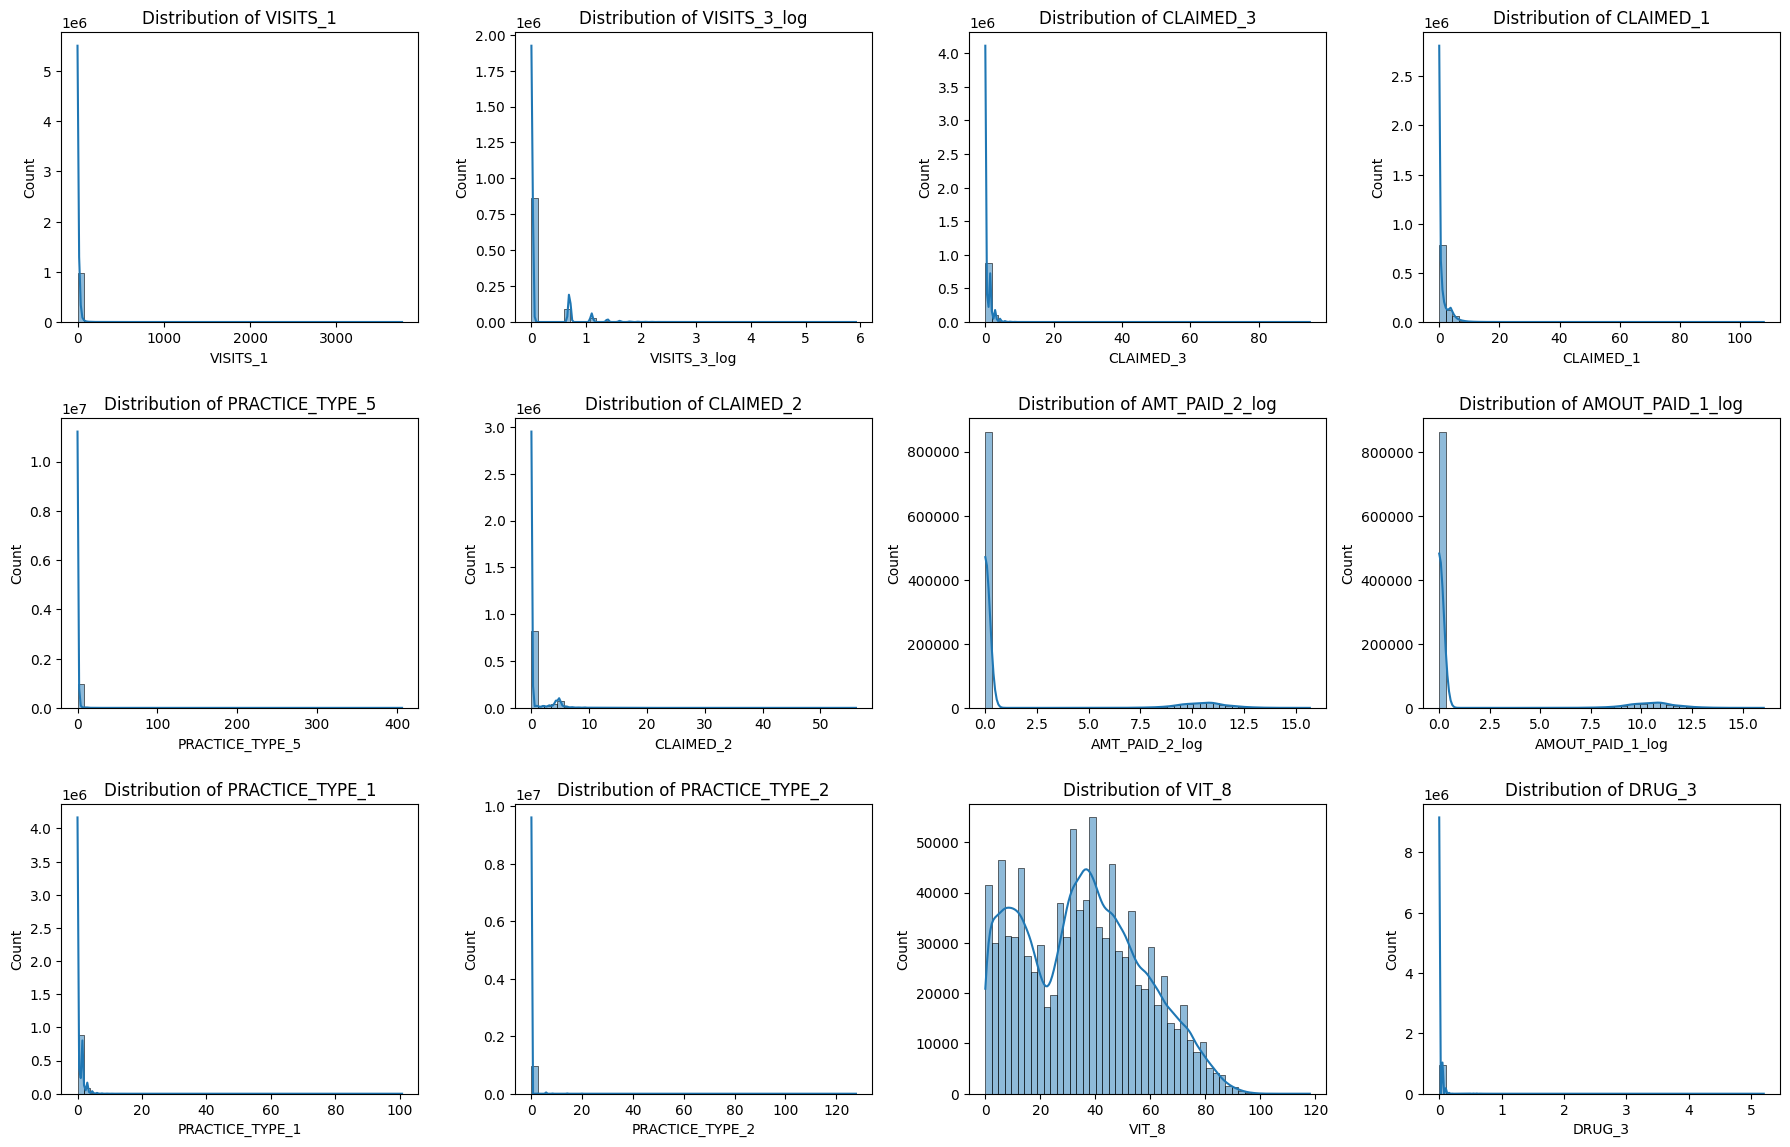

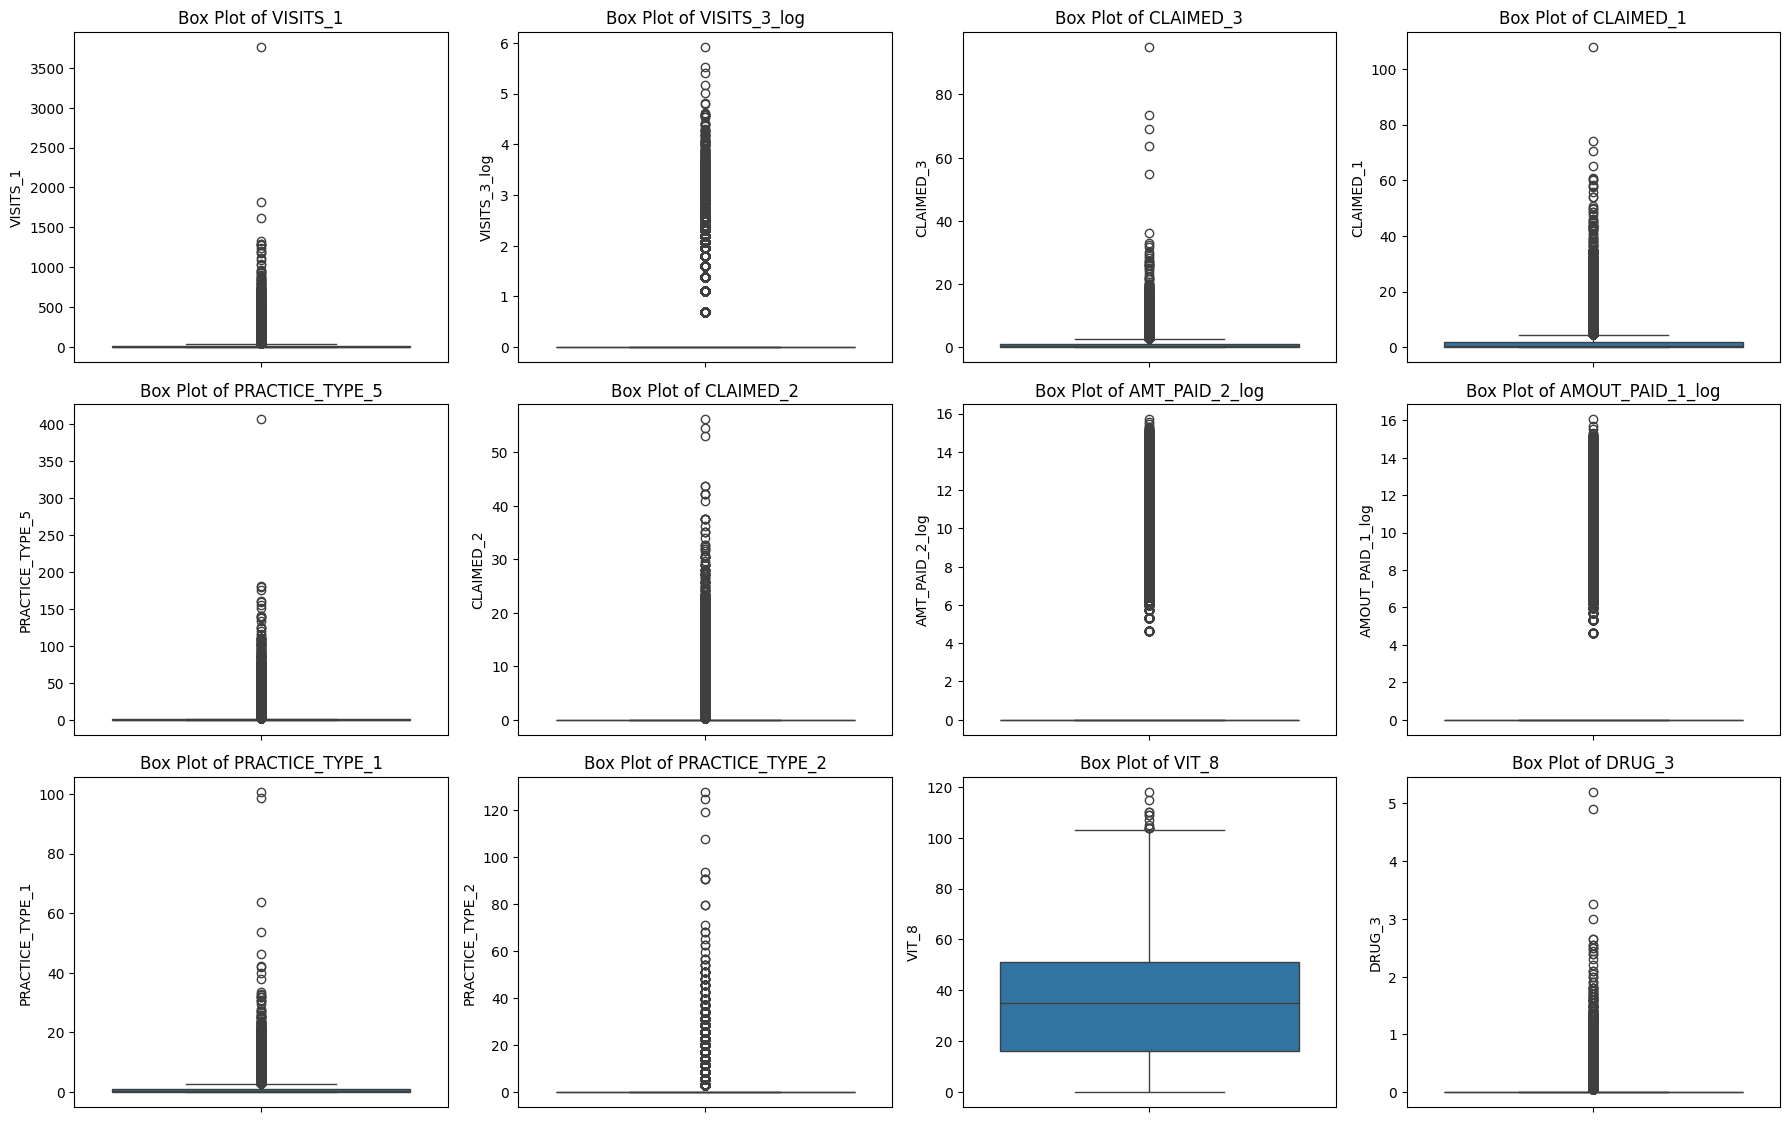


Displaying distributions conditioned on LABEL (Hospital Admission):


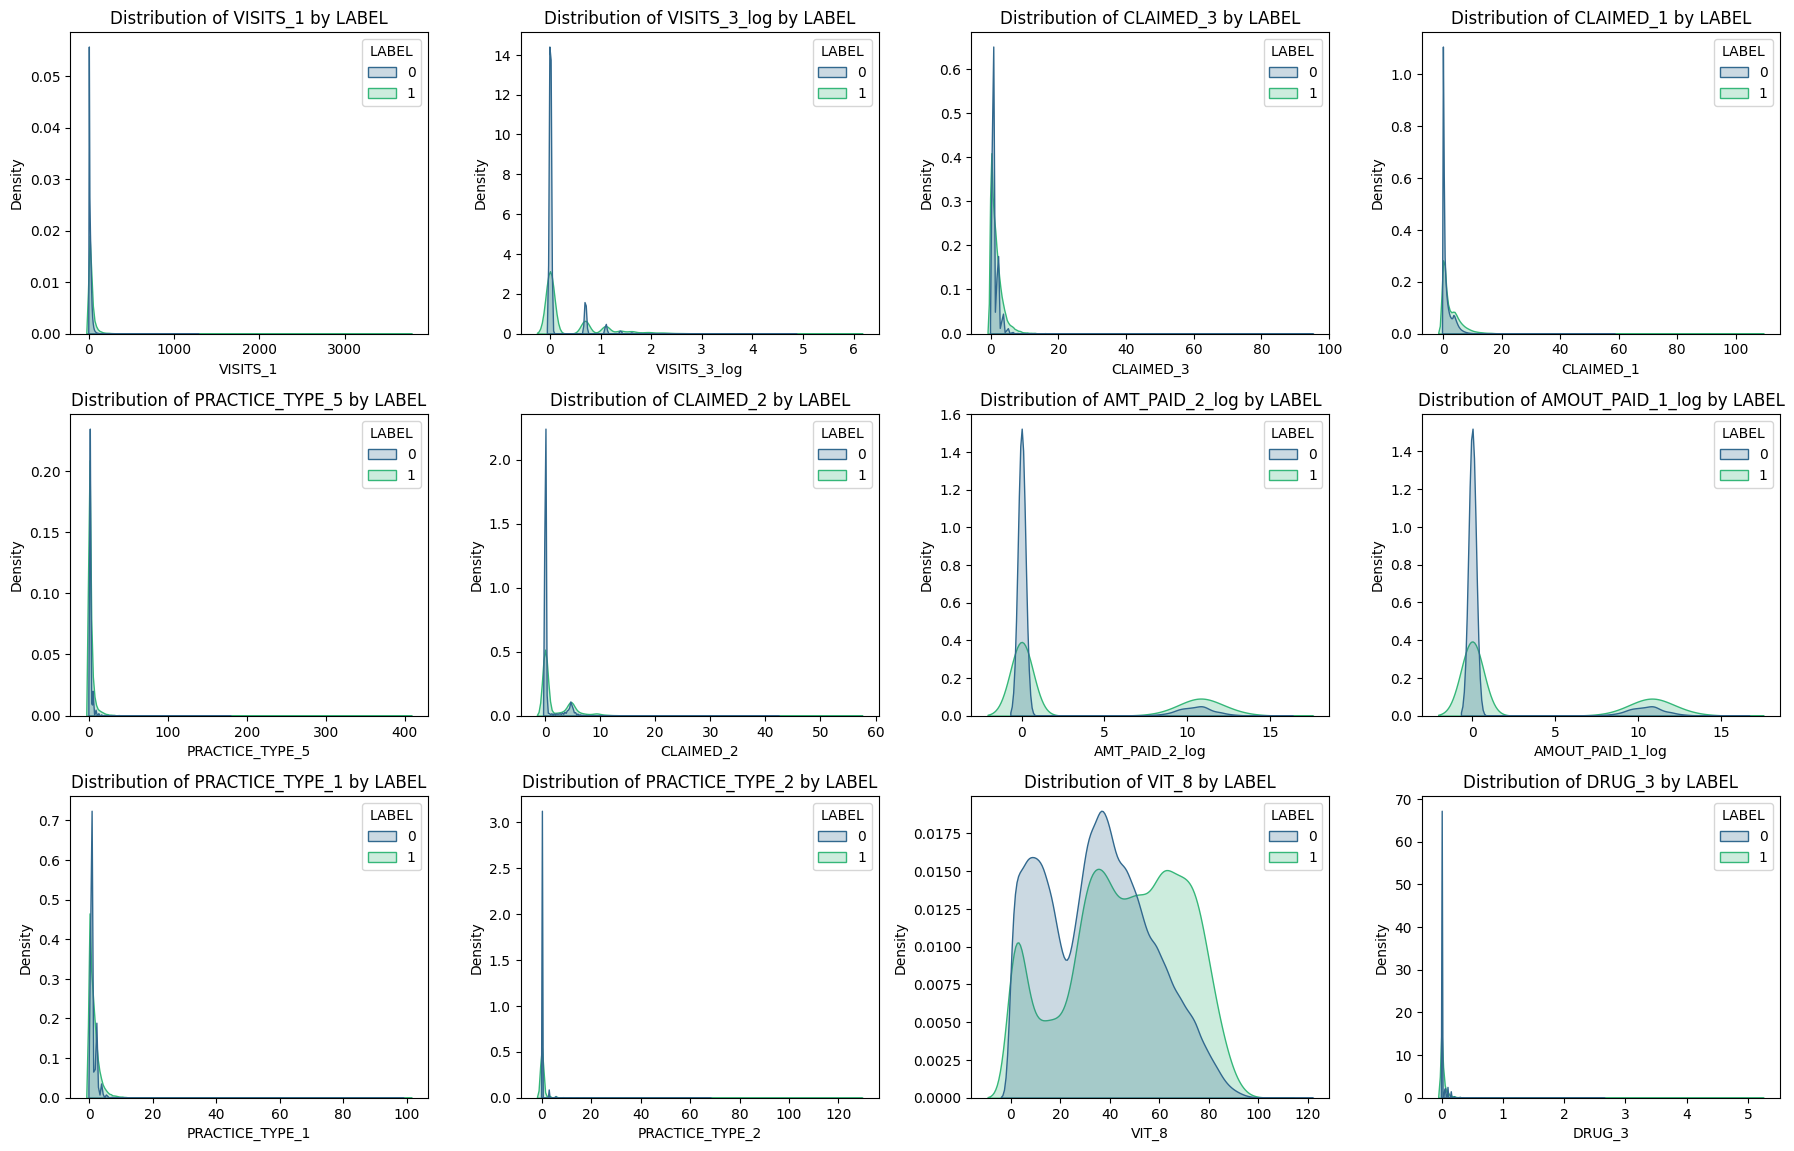

In [34]:
# The 12 selected features and the target label
features_to_plot = [
    'VISITS_1','VISITS_3_log','CLAIMED_3','CLAIMED_1','PRACTICE_TYPE_5','CLAIMED_2',
    'AMT_PAID_2_log','AMOUT_PAID_1_log','PRACTICE_TYPE_1','PRACTICE_TYPE_2','VIT_8',
    'DRUG_3'
]
print("Displaying distributions for the 12 selected features...")

# --- Histograms (and KDE plots) for overall shape ---
plt.figure(figsize=(18, 15)) # Adjust figure size as needed
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 4, i + 1) # Create a 3x3 grid of plots
    sns.histplot(df_for_modeling[feature], kde=True, bins=50) # kde=True adds a density curve
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- Box Plots for outliers and spread ---
plt.figure(figsize=(18, 15)) # Adjust figure size as needed
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df_for_modeling[feature]) # Use y for vertical box plot
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# If you want to see distributions conditioned on the target variable (very powerful for binary classification)
# This uses kdeplot to show the density for LABEL=0 and LABEL=1 separately
print("\nDisplaying distributions conditioned on LABEL (Hospital Admission):")
plt.figure(figsize=(18, 15))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(data=df_for_modeling, x=feature, hue='LABEL', fill=True, common_norm=False, palette='viridis')
    plt.title(f'Distribution of {feature} by LABEL')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

The collective analysis of these plots provides a comprehensive understanding of our dataset, even before model implementation. Initially, features like VISITS, CLAIMED, and PRACTICE_TYPE displayed extreme positive skewness and numerous outliers. Log transformations were effectively applied to reduce this skewness and compress outlier ranges for continuous variables.

While some features, like the CHRONIC variables, remained binary and were not affected by this transformation, the density plots for our refined feature set clearly show that the distributions for hospital admissions (LABEL 1) are distinct from non-admissions (LABEL 0), often shifted towards higher values. This visual separation confirms the predictive potential of these features.

## Training test split and data scalling.

In [36]:
# Separate features and target
X = df_for_modeling.drop(columns=['LABEL'])  # Features
y = df_for_modeling['LABEL']                # Target variable

# Perform stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,             # 20% test data
    stratify=y,                # Preserve label proportions since target label is imbalance
    random_state=42            # For reproducibility
)

# Print the distribution to check stratification
print("Training label distribution:\n", y_train.value_counts(normalize=True))
print("Testing label distribution:\n", y_test.value_counts(normalize=True))


Training label distribution:
 LABEL
0    0.976145
1    0.023855
Name: proportion, dtype: float64
Testing label distribution:
 LABEL
0    0.976145
1    0.023855
Name: proportion, dtype: float64


Stratification ensures that the proportion of 0s and 1s in LABEL is the same in both training and test sets.
Random state ensures results are reproducible.
This is a critical step before training any machine learning model.

In [37]:
# Create a scaler instance
scaler = StandardScaler()

# Fit the scaler on the training data, then transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


StandardScaler standardises features by removing the mean and scaling to unit variance (Z = (X - mean) / std).
It's important to fit only on the training data, to avoid data leakage.

##  Model Implementation and Evaluation

Implementation of Logistic Regression, Random Forest, and XGBoost classifiers for predicting hospital admission risk, followed by performance evaluation using appropriate classification metrics.


## Logistic Regression model.

In [38]:
# Initialize the model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the scaled training data
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy Score: 0.976215

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    195229
           1       0.55      0.02      0.03      4771

    accuracy                           0.98    200000
   macro avg       0.77      0.51      0.51    200000
weighted avg       0.97      0.98      0.97    200000


Confusion Matrix:
 [[195171     58]
 [  4699     72]]


The baseline Logistic Regression model achieved a misleadingly high overall accuracy of 97.62%, primarily due to its excellent performance on the majority class (Class 0: no admission), where it achieved near-perfect precision and recall.

However, for the crucial minority class (Class 1: hospital admission), the model performed very poorly, with a recall of only 2% and an f1-score of 3%. This severe imbalance in class-wise performance highlights that the model is effectively failing to identify true hospital admissions, rendering it unsuitable for its intended purpose without further strategies to address class imbalance.

## Logistic Regression with the class_weight parameter.

In [39]:
# Create and train logistic regression model with class weight balanced
logreg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_balanced.fit(X_train_scaled, y_train)

# Make predictions
y_pred_balanced = logreg_balanced.predict(X_test_scaled)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))

Accuracy Score: 0.74253

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85    195229
           1       0.05      0.55      0.09      4771

    accuracy                           0.74    200000
   macro avg       0.52      0.65      0.47    200000
weighted avg       0.96      0.74      0.83    200000


Confusion Matrix:
 [[145865  49364]
 [  2130   2641]]


Setting class_weight='balanced' in the Logistic Regression model significantly shifted its focus from overall accuracy to minority class detection.

While the total accuracy decreased from 97.62% to 74.25%, this adjustment dramatically improved recall for the crucial hospital admission class (Class 1) from a dismal 2% to a more acceptable 55%. This gain, however, came at the cost of reduced precision for Class 1 (from 55% to 5%) and an increase in false positives (49,364 misclassified non-admissions), indicating a clear trade-off to prioritize identifying actual admissions.

Next step implementing an ensemble model (Random Forest) is even more critical now, as it might offer a better balance between these metrics, potentially achieving high recall without an excessively high number of false positives.

## Random Forest model.

In [40]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy Score: 0.95389

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    195229
           1       0.03      0.03      0.03      4771

    accuracy                           0.95    200000
   macro avg       0.50      0.50      0.50    200000
weighted avg       0.95      0.95      0.95    200000


Confusion Matrix:
 [[190625   4604]
 [  4618    153]]


The Random Forest model results present a similar challenge to the initial Logistic Regression, despite its general robustness. With an overall Accuracy Score of 0.95389, the model again performs excellently for the majority class (Class 0: no admission), achieving a precision of 0.98, recall of 0.98, and an f1-score of 0.98.

However, its performance on the minority class (Class 1: hospital admission) is extremely poor, with a precision of 0.03, recall of 0.03, and an f1-score of 0.03. The Confusion Matrix further illustrates this: out of 4771 actual hospital admissions, only 153 were correctly identified (True Positives), while a staggering 4618 were missed (False Negatives).

This indicates the Random Forest model, in its current state, is heavily biased towards predicting the majority class, making it ineffective for identifying crucial hospital admission cases.

The Random Forest model also yielded a misleadingly high overall accuracy of 95.39%, as its performance for the minority class (hospital admission) was extremely poor, with both precision and recall at a mere 3%. This signifies a strong bias towards the majority class, rendering it ineffective for identifying crucial admission cases.

Given these limitations, XGBoost would be a superior choice, offering advanced boosting capabilities that sequentially correct errors, handle imbalanced datasets more effectively via parameters like scale_pos_weight, and intrinsically include regularisation to prevent overfitting.

Its robust nature and ability to learn complex relationships from data typically lead to higher predictive performance and often reduce the need for extensive manual cross-validation compared to Random Forest due to its built-in validation during boosting iterations.

## XGBoost classifiers model.

In [43]:
 import xgboost as xgb

# Calculate scale_pos_weight
# Formula: (number of negative class samples) / (number of positive class samples)
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Accuracy Score: 0.741525

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85    195229
           1       0.05      0.54      0.09      4771

    accuracy                           0.74    200000
   macro avg       0.52      0.64      0.47    200000
weighted avg       0.96      0.74      0.83    200000


Confusion Matrix:
 [[145718  49511]
 [  2184   2587]]


The XGBoost model, with an accuracy of 74.15%, demonstrates a similar performance profile to the class-balanced Logistic Regression. While it achieves high precision (0.99) and recall (0.75) for the majority class (no admission), its performance for the minority class (hospital admission) remains a challenge, with a low precision of 0.05 and a recall of 0.54.

The confusion matrix further reveals that out of 4771 actual admissions, 2587 were correctly identified (True Positives), but 2184 were missed (False Negatives), and a significant 49511 non-admissions were incorrectly flagged as admissions (False Positives).

This indicates that while XGBoost, like the class-balanced Logistic Regression, prioritizes recall for the minority class, there's still a considerable trade-off in terms of precision and false alarms.

Given the current XGBoost results show an acceptable recall for the minority class (0.54) but very low precision (0.05) and a high number of false positives, the next critical step is hyperparameter tuning.

This process will allow us to optimise the model's balance between recall and precision, fine-tuning its ability to identify hospital admissions more accurately while managing false alarms, ultimately leading to a more clinically useful predictive tool.

## Optimised XGBoost classifiers model.

In [44]:
# Define base model with scale_pos_weight
neg, pos = np.bincount(y_train)
scale_weight = neg / pos

xgb = XGBClassifier(
    scale_pos_weight=scale_weight,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_

# Evaluate best model
y_pred_best = best_model.predict(X_test_scaled)

print("Best Parameters:\n", grid_search.best_params_)
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:
 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

Accuracy Score: 0.733185

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.84    195229
           1       0.05      0.57      0.09      4771

    accuracy                           0.73    200000
   macro avg       0.52      0.65      0.47    200000
weighted avg       0.96      0.73      0.83    200000


Confusion Matrix:
 [[143934  51295]
 [  2068   2703]]


The results after hyperparameter tuning for the XGBoost model show a marginal but positive shift in performance for the minority class. The overall accuracy slightly decreased to 73.32%. For Class 1 (hospital admission), recall improved from 0.54 to 0.57, meaning the model now correctly identifies a higher proportion of actual admissions.

However, precision for Class 1 remains low at 0.05, indicating that for every five predictions of admission, only one is correct. The confusion matrix shows 2703 True Positives (correctly identified admissions) but also 51295 False Positives (non-admissions incorrectly flagged as admissions), indicating a continued challenge in balancing minority class detection with minimizing false alarms.

Having completed the hyperparameter tuning process, this XGBoost model now represents our finalized predictive solution for identifying hospital admissions. While maintaining a strong performance for the majority class, the tuning has slightly improved the critical recall for the minority class, ensuring a better balance in identifying actual admissions.

To fully understand its behavior and interpret its predictions, we will now visualize its performance through the Precision-Recall Curve, the Receiver Operating Characteristic (ROC) Curve, and analyze individual feature contributions using SHAP (SHapley Additive exPlanations) results.

## Calculating the SHAP value to identify feature impact and improve interpretability of our study. 

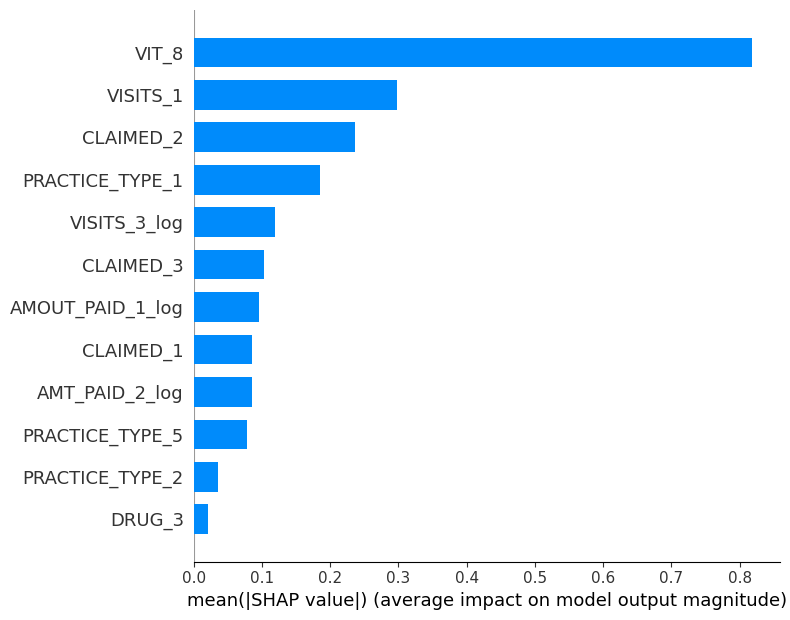

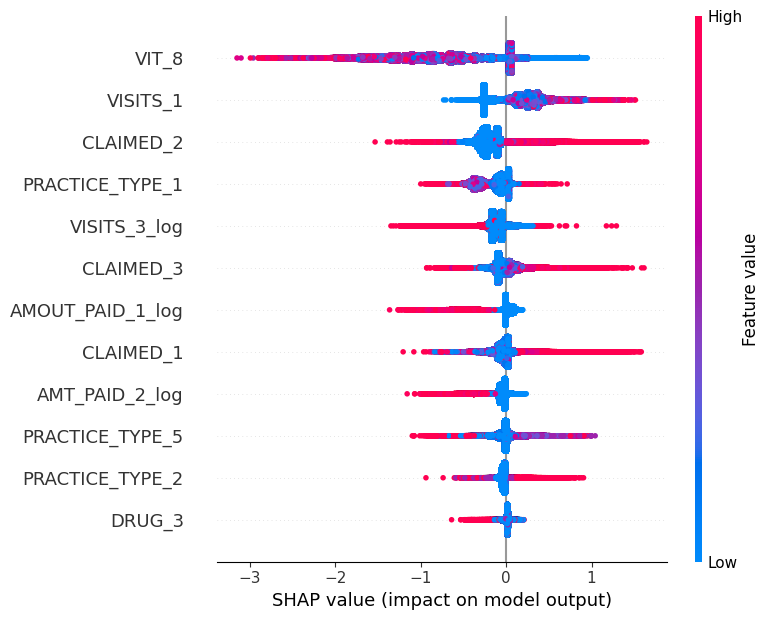

In [45]:
# SHAP expects the original training data (before scaling)
# If you scaled your data, use the original unscaled X_train
explainer = shap.Explainer(best_model)

# Compute SHAP values
shap_values = explainer(X_train)

# --- Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# --- Detailed Summary Plot (Impact by Value)
shap.summary_plot(shap_values, X_train)


The SHAP summary bar plot above shows the average impact of each feature on the model’s predictions. VIT_8 is by far the most influential variable, suggesting it plays a major role in predicting the risk label. Other strong predictors include VISITS_1, CLAIMED_2, and PRACTICE_TYPE_1, indicating that member visit frequency and specific types of claims or provider types are relevant to risk.

Several log-transformed variables like VISITS_3_log and AMOUNT_PAID_1_log also contribute, confirming the usefulness of transforming skewed variables. Features such as DRUG_3 and PRACTICE_TYPE_2 have minimal impact, suggesting they may be less relevant or redundant.


The SHAP beeswarm plot above shows how each feature impacts the model’s output for individual predictions. Each point represents a member, colored by the feature value (red = high, blue = low). For example, high values of VIT_8 (red) consistently push predictions higher (positive SHAP values), confirming its strong positive contribution to risk.

Conversely, some features like CLAIMED_3 and PRACTICE_TYPE_1 show both positive and negative SHAP values, meaning their impact varies depending on the individual case. Features with tightly clustered SHAP values (like DRUG_3) contribute little to model variability. Overall, the plot highlights both the strength and direction of each feature's influence.

## Plotting the ROC_Curve and Precision_Recall_Curve.

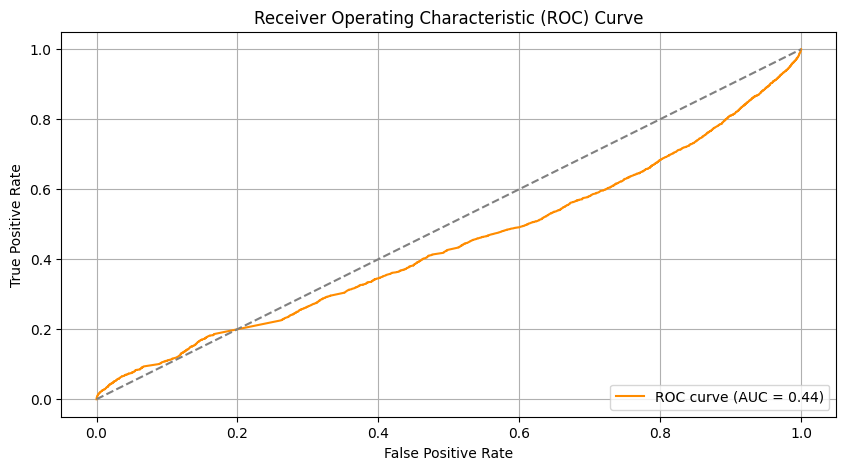

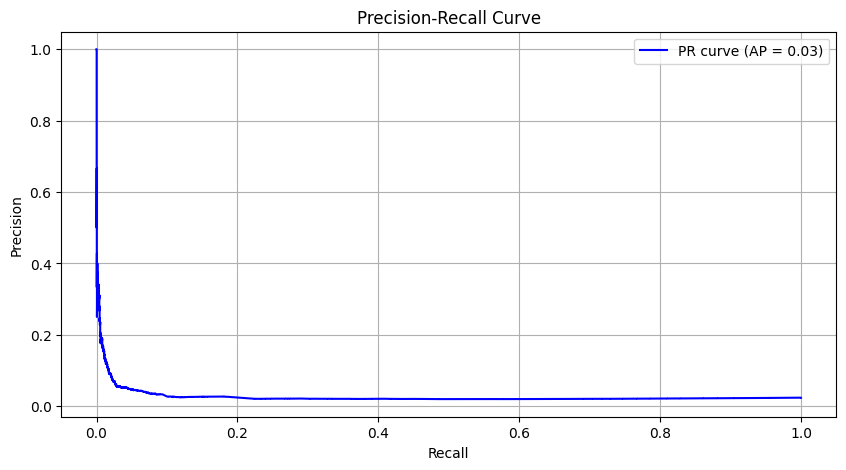

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f"PR curve (AP = {ap_score:.2f})", color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

The ROC curve above shows how well the model can distinguish between the two classes. The AUC (Area Under the Curve) is 0.44, which is lower than 0.5. This means the model performs worse than random guessing.

Most of the curve lies below the diagonal dashed line, indicating the model struggles to correctly rank positive cases higher than negative ones. This is likely due to a highly imbalanced target variable only 2.4% of the cases were admissions, while the remaining 97.6% were non-admissions.

The Precision-Recall (PR) curve above shows very poor model performance, with an Average Precision (AP) of just 0.03. Precision drops sharply as recall increases, and remains close to zero across most recall values.

This indicates the model has a high false positive rate and is unable to effectively identify the **minority (admissions) class**. The low AP score is especially concerning given the imbalanced nature of the dataset, and it confirms that the model struggles to correctly classify the rare positive cases.

## Conclusion:

This study aimed to predict hospital admissions, a task complicated by a severely imbalanced dataset where admissions represent a small minority of cases. Initial data exploration revealed highly skewed features with numerous outliers, particularly in visit and claim counts, necessitating log transformations for better distribution handling.

Our initial modeling attempts with baseline Logistic Regression and Random Forest models demonstrated high overall accuracy (97.62% and 95.39% respectively), but these were misleading. Both models suffered from a critical failure to identify actual hospital admissions, exhibiting abysmal recall rates of merely 2% and 3% for the minority class. This indicated a strong bias towards the majority class and rendered them clinically impractical.

Implementing class weighting in Logistic Regression significantly improved minority class recall to 55%, albeit at the cost of overall accuracy (74.25%) and very low precision (5%) for admissions, resulting in a high number of false positives (49,364). Subsequently, an XGBoost model, known for its robustness, was employed. After hyperparameter tuning, it achieved a similar profile: 73.32% accuracy, with 57% recall for admissions but still only 5% precision. The SHAP analysis consistently identified VIT_8 as the most influential feature, followed by VISITS_1, CLAIMED_2, and PRACTICE_TYPE_1, confirming their strong predictive impact on admission likelihood.

Despite efforts, the final ROC curve for the tuned XGBoost model indicates underperformance with an AUC of 0.44, suggesting it performs worse than random chance. The Precision-Recall curve, with an Average Precision (AP) of 0.03, further confirms the model's severe difficulty in correctly identifying positive cases without a high rate of false alarms. This implies that while individual feature signals exist, the model, even after tuning, struggles to effectively combine them to accurately predict hospital admissions.

## Recommendations:

Advanced Imbalance Handling: Explore more sophisticated techniques for imbalanced datasets beyond scale_pos_weight or class_weight='balanced'. This could include:
SMOTE-like oversampling on the training data.
Undersampling the majority class cautiously.
Ensemble methods specifically designed for imbalance (e.g., EasyEnsemble, BalanceCascade).
Threshold Optimisation: Implement a post-modeling threshold optimisation strategy. Since the goal is high recall, the default 0.5 probability threshold might not be optimal. By analyzing the precision-recall curve, a different threshold can be chosen to achieve a more desirable balance between precision and recall, depending on the clinical tolerance for false positives versus missed true positives.


Feature Engineering: Revisit feature engineering to potentially create new features that better capture the nuances of hospital admissions. This might involve:
Interaction terms between existing features.
Domain expert collaboration to identify subtle indicators.

Explore Other Algorithms: While XGBoost is powerful, exploring other algorithms tailored for imbalanced data, such as LightGBM or CatBoost with appropriate parameters for handling imbalance, could yield better results.

